In [1]:
#!pip install pandas
#%matplotlib inline
import math
import numpy as np
import pandas as pd
import pandasql as ps
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sn
from pandas.api.types import CategoricalDtype
import IPython.display as ipd
from tqdm.notebook import tqdm, trange
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import random
from collections import Counter
from collections import defaultdict
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import ast

from collections import defaultdict
from scipy.stats.stats import pearsonr

plt.rcParams['axes.formatter.useoffset']=False
pd.set_option('display.max_columns', None)
#plt.rcParams['figure.figsize'] = [10, 5]
#plt.rcParams['figure.dpi'] = 250

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [2]:
df = pd.read_csv('flat_df_no_nulli.csv', index_col=0)

In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoders = dict()
column2encode = ['ALBUM_type_']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [4]:
df['target']=[1 if genre == 'Rock' else 0 for genre in df['TRACK_genre_top']]

<AxesSubplot:>

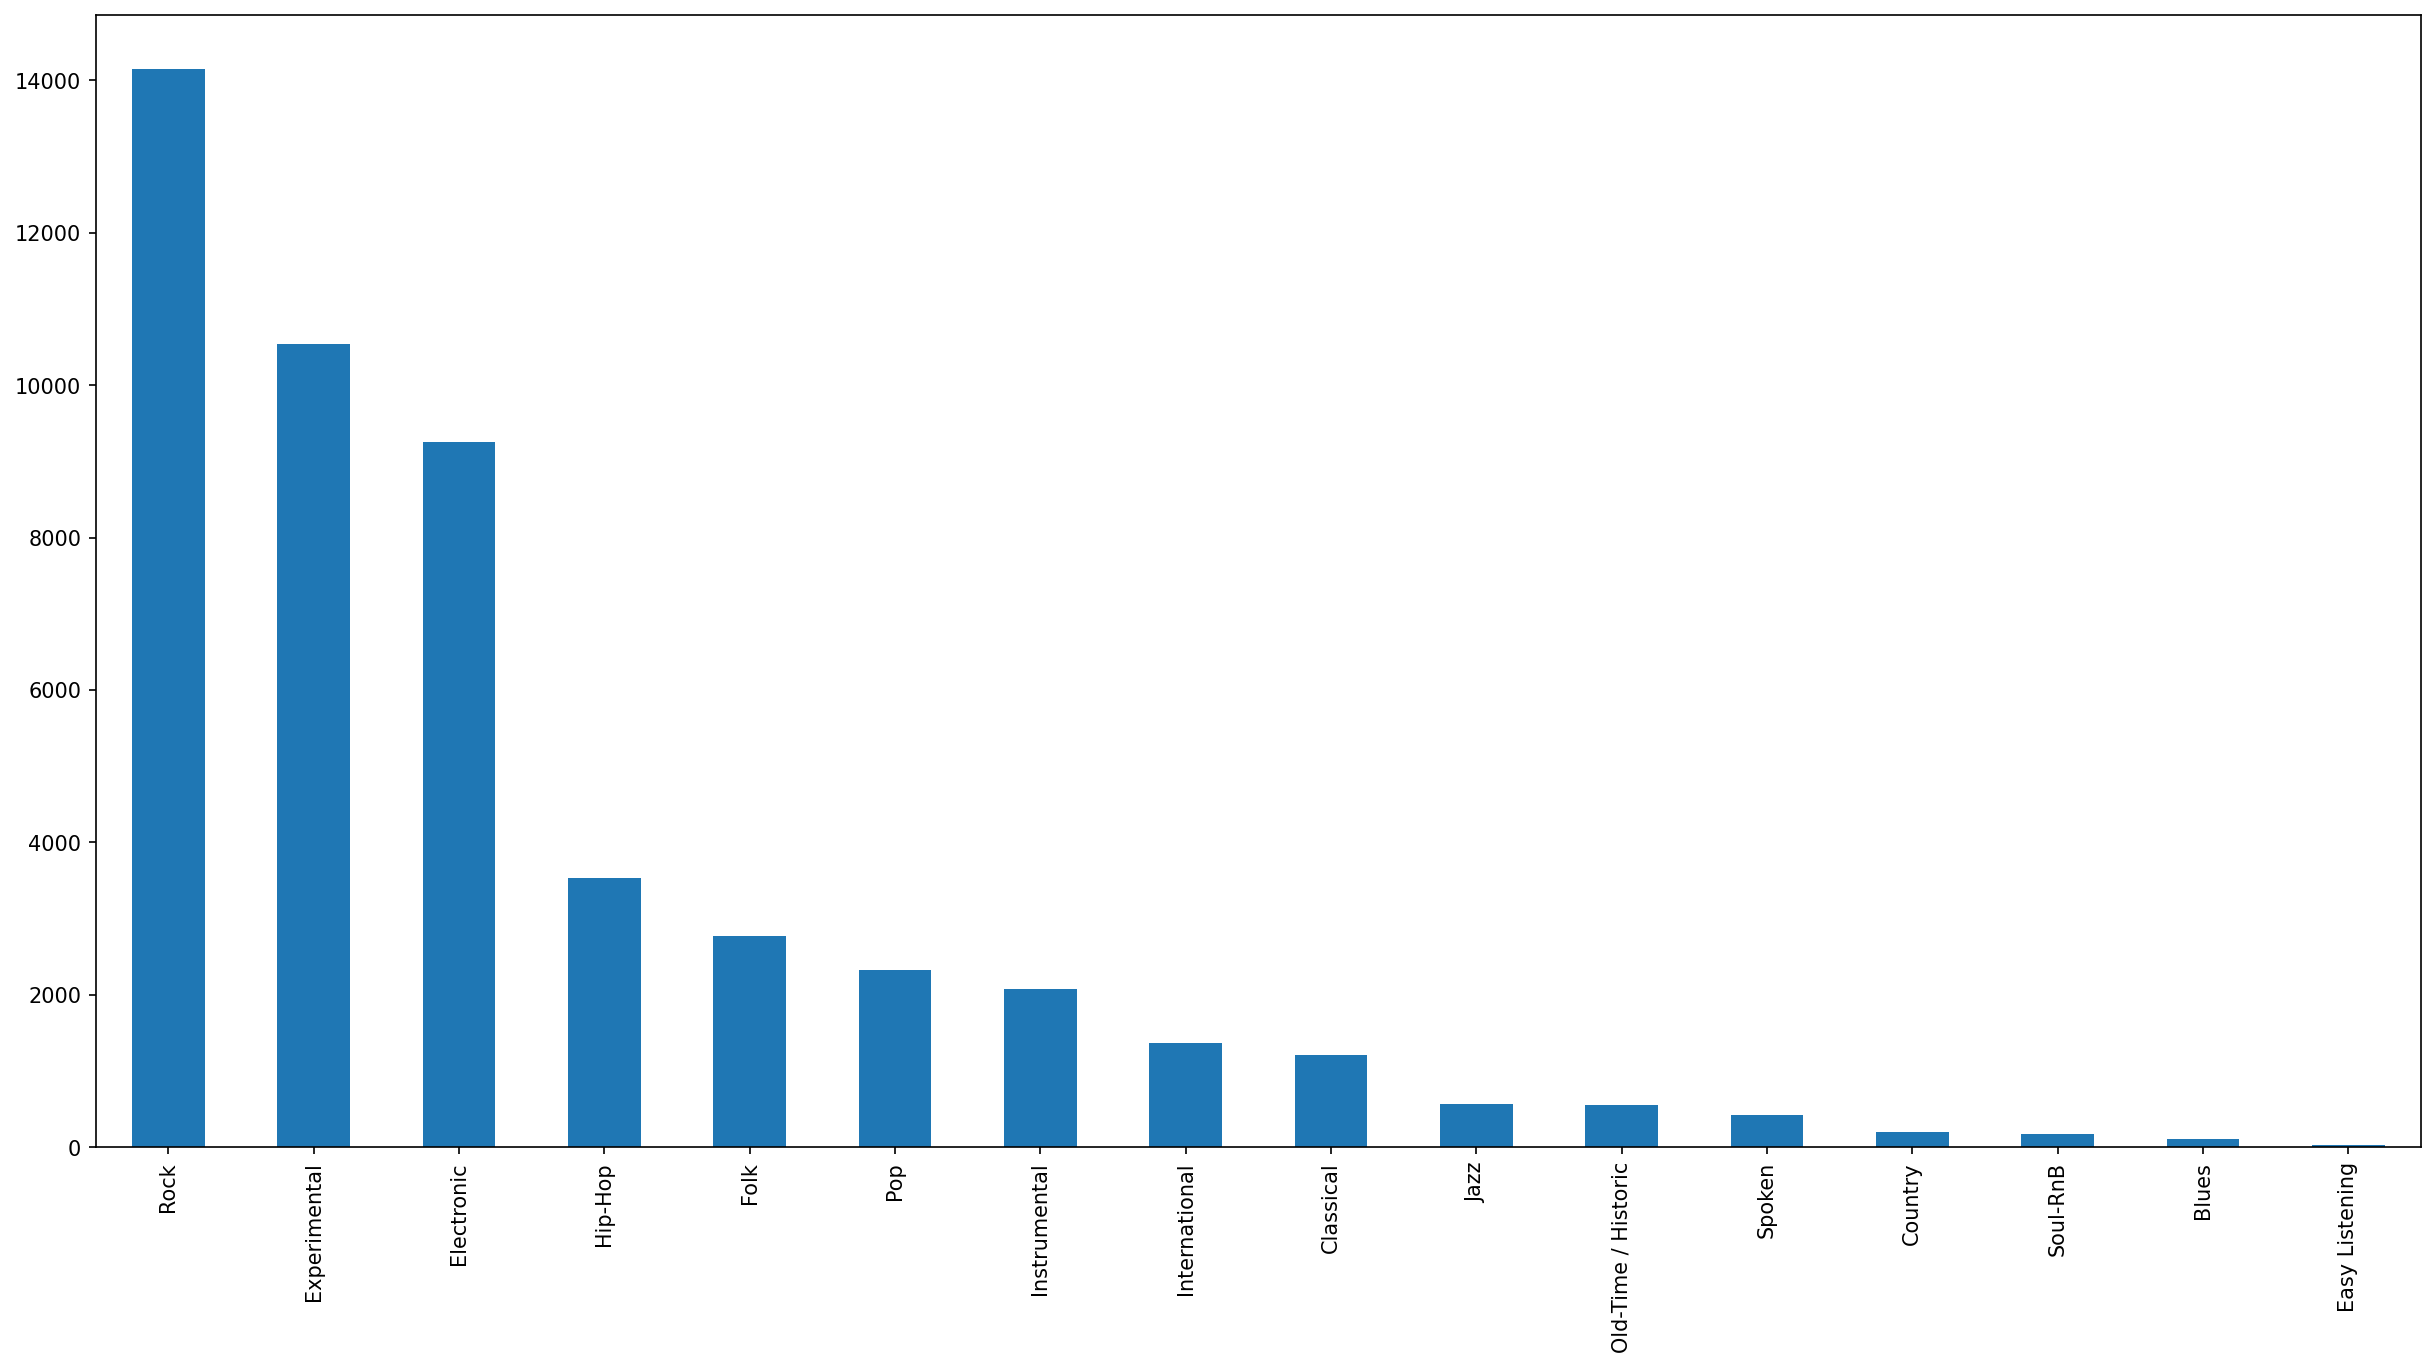

In [5]:
df.TRACK_genre_top.value_counts().plot(kind='bar')

In [4]:
df = df[df.TRACK_genre_top.isna() == False] #droppo i nulli

In [5]:
label_encoders = dict()
column2encode = ['TRACK_genre_top']

for col in column2encode:
    le = LabelEncoder()
    df['TRACK_genre_top_num'] = le.fit_transform(df[col])
    label_encoders[col] = le

In [6]:
df['TRACK_genre_top_num']=[0 if genre == 3 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 0 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 14 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 2 else genre for genre in df['TRACK_genre_top_num']]



df['TRACK_genre_top_num']=[0 if genre == 15 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 11 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 10 else genre for genre in df['TRACK_genre_top_num']]


df['TRACK_genre_top_num']=[3 if genre == 13 else genre for genre in df['TRACK_genre_top_num']] #rock 13 --> 3
df['TRACK_genre_top_num']=[2 if genre == 12 else genre for genre in df['TRACK_genre_top_num']] #pop 12 --> 2

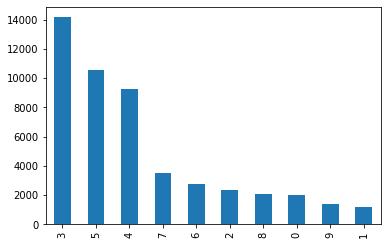

In [7]:
df.TRACK_genre_top_num.value_counts().plot(kind='bar')

In [8]:
features = [
 'chroma_censkurtosis',
 'chroma_censmax',
 'chroma_censmean',
 'chroma_censmedian',
 'chroma_censmin',
 'chroma_censskew',
 'chroma_censstd',
 'chroma_censcqtkurtosis',
 'chroma_cqtmax',
 'chroma_cqtmean',
 'chroma_cqtmedian',
 'chroma_cqtmin',
 'chroma_cqtskew',
 'chroma_cqtstd',
 'chroma_stftkurtosis',
 'chroma_stftmax',
 'chroma_stftmean',
 'chroma_stftmedian',
 'chroma_stftmin',
 'chroma_stftskew',
 'chroma_stftstd',
 'mfcckurtosis',
 'mfccmax',
 'mfccmean',
 'mfccmedian',
 'mfccmin',
 'mfccskew',
 'mfccstd',
 'spectral_contrastkurtosis',
 'spectral_contrastmax',
 'spectral_contrastmean',
 'spectral_contrastmedian',
 'spectral_contrastmin',
 'spectral_contrastskew',
 'spectral_contraststd',
 'tonnetzkurtosis',
 'tonnetzmax',
 'tonnetzmean',
 'tonnetzmedian',
 'tonnetzmin',
 'tonnetzskew',
 'tonnetzstd',
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_bandwidthmean01',
 'spectral_bandwidthmedian01',
 'spectral_bandwidthmin01',
 'spectral_bandwidthskew01',
 'spectral_bandwidthstd01',
 'spectral_centroidkurtosis01',
 'spectral_centroidmax01',
 'spectral_centroidmean01',
 'spectral_centroidmedian01',
 'spectral_centroidmin01',
 'spectral_centroidskew01',
 'spectral_centroidstd01',
 'spectral_rolloffkurtosis01',
 'spectral_rolloffmax01',
 'spectral_rolloffmean01',
 'spectral_rolloffmedian01',
 'spectral_rolloffmin01',
 'spectral_rolloffskew01',
 'spectral_rolloffstd01',
 'zcrkurtosis01',
 'zcrmax01',
 'zcrmean01',
 'zcrmedian01',
 'zcrmin01',
 'zcrskew01',
 'zcrstd01',
]


bitmap = [
    'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken',
]

nulli = [
     'ALBUM_date_released_year',
    'ALBUM_favorites',
     'ALBUM_listens',
 'ALBUM_tracks',
 'ALBUM_type',
 'ARTIST_favorites',
 'ARTIST_location',
 'TRACK_favorites',
  'ARTIST_location_',
    'TRACK_genres_soloTop'
]

nonNumerici = [
    'ALBUM_tags',
    'ALBUM_title',
    'ARTIST_location_',
    'ARTIST_name',
    'ARTIST_tags',
    'SET_subset',
    'TRACK_genre_top',
    'TRACK_genres',
    'TRACK_genres_all',
    'TRACK_genres_soloTop',
    'TRACK_tags',
    'TRACK_title',
    'TRACK_genres_soloTop'
]

In [9]:
def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'] + ['TRACK_genre_top_num'])

compl.sort()

compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ALBUM_type_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

# Naive Bayes

In [40]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

In [106]:
#Rimozione features correlate tra loro
cor_matrix = df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

In [236]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(to_drop)

['TRACK_listens', 'rmsemedian01', 'spectral_bandwidthmedian01', 'spectral_centroidmedian01', 'spectral_rolloffmean01', 'spectral_rolloffmedian01', 'spectral_rolloffmin01', 'spectral_rolloffskew01', 'spectral_rolloffstd01', 'zcrmedian01', 'ALBUM_tracks_', 'ALBUM_listens_', 'ALBUM_favorites_', 'ALBUM_date_released_year_', 'chroma_censmedian', 'chroma_censcqtkurtosis', 'chroma_cqtmedian', 'chroma_stftkurtosis', 'chroma_stftmedian', 'mfccmedian', 'spectral_contrastmedian', 'tonnetzmedian']


In [237]:
df1 = df.drop(columns=to_drop, axis=1)

In [238]:
class_name = 'TRACK_genre_top_num'

attributes = Diff(compl+features, to_drop)
X = df1[attributes].values
y = df1[class_name]

#scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler = RobustScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [239]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

In [240]:
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.32043563552729487
F1-score [0.196      0.43063584 0.11330472 0.59275643 0.09517846 0.22569089
 0.32114883 0.29869054 0.16122841 0.15944541]
              precision    recall  f1-score   support

           0       0.25      0.16      0.20       611
           1       0.29      0.82      0.43       364
           2       0.14      0.09      0.11       697
           3       0.72      0.50      0.59      4247
           4       0.37      0.05      0.10      2778
           5       0.59      0.14      0.23      3163
           6       0.25      0.44      0.32       832
           7       0.18      0.85      0.30      1061
           8       0.20      0.14      0.16       621
           9       0.10      0.45      0.16       409

    accuracy                           0.32     14783
   macro avg       0.31      0.37      0.26     14783
weighted avg       0.46      0.32      0.31     14783



In [20]:
import matplotlib.patches as mpatches

def grafico(mappa=list(), label="", color="blue", xline=None, xcolor='green', xlinestyle=":", xlabel="", 
            yline=None, ycolor='red', ylinestyle="--", ylabel=""):
    x = [0]
    y = [0]

    for i in percentuali:
        x.append(i)
        y.append(mappa[i])
    plt.plot(x,y, color=color)

    legenda = list()

    legenda.append(mpatches.Patch(color=color, label=label))

    if yline != None:
        plt.axhline(y=yline, color=ycolor, linestyle =ylinestyle)
        legenda.append(mpatches.Patch(color=ycolor, label=ylabel))

    if xline != None:
        plt.axvline(x=xline, color=xcolor, linestyle =xlinestyle)
        legenda.append(mpatches.Patch(color=xcolor, label=xlabel))

    plt.xlabel('% del training set')
    plt.ylabel(label)
    plt.legend(handles=legenda)

In [16]:
percentuali = list(range(1,101,2)) + [100]

def calcolaNRecord(length, percentage):
    return int((length*percentage)/100)


class_name = 'TRACK_genre_top_num'

attributes = compl + features
X = df[attributes].values
y = df[class_name]

#scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler = RobustScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)



from sklearn.svm import LinearSVC
from concurrent.futures import ThreadPoolExecutor
import time

def calcola(i):
    print("START ", i)
    #clf = GaussianNB()
    clf = LogisticRegression(C=100, random_state=0, max_iter=1000, class_weight='balanced', solver='liblinear', penalty='l2')

    indices = np.random.choice(X_train.shape[0], calcolaNRecord(len(X_train), i), replace=False)
    X_train_sampled = X_train[indices]
    y_train_sampled = y_train.iloc[indices]


    start_time = time.time()
    clf.fit(X_train_sampled, y_train_sampled)


    #print("---------------------------------------------------------\r\n\r\n", i, " ", calcolaNRecord(len(X_train), i))
    #print("--- %s seconds ---" % (time.time() - start_time))

    timeRes[i] = time.time() - start_time

    y_pred = clf.predict(X_test)

    accuracyRes[i] = accuracy_score(y_test, y_pred)
    f1Res[i] = f1_score(y_test, y_pred, average='weighted')

    #print('Accuracy %s' % accuracy_score(y_test, y_pred))
    #print('F1-score %s' % f1_score(y_test, y_pred, average=None))
    #print(classification_report(y_test, y_pred))
    print("STOP ", i)


accuracyRes = {}
f1Res = {}
timeRes = {}

future = {}
executor = ThreadPoolExecutor(2)

for i in percentuali:
    future[i] = executor.submit(calcola, i)

executor.shutdown(wait=True)

accuracyRes

START  1
START  3
STOP  1
START  5
STOP  3
START  7
STOP  5
START  9
STOP  7
START  11
STOP  9
START  13
STOP  11
START  15
STOP  13
START  17
STOP  15
START  19
STOP  17
START  21
STOP  19
START  23
STOP  21
START  25
STOP  23
START  27
STOP  25
START  29
STOP  27
START  31
STOP  29
START  33
STOP  31
START  35
STOP  33
START  37
STOP  35
START  39
STOP  37
START  41
STOP  39
START  43
STOP  41
START  45
STOP  43
START  47
STOP  45
START  49
STOP  47
START  51
STOP  49
START  53
STOP  53
START  55
STOP  51
START  57
STOP  55
START  59
STOP  57
START  61
STOP  59
START  63
STOP  61
START  65
STOP  63
START  67
STOP  65
START  69
STOP  67
START  71
STOP  69
START  73
STOP  71
START  75
STOP  73
START  77
STOP  75
START  79
STOP  77
START  81
STOP  79
START  83
STOP  81
START  85
STOP  83
START  87
STOP  85
START  89
STOP  87
START  91
STOP  89
START  93
STOP  91
START  95
STOP  93
START  97
STOP  95
START  99
STOP  97
START  100
STOP  99
STOP  100


{1: 0.44118243928837175,
 3: 0.49008996820672396,
 5: 0.5398768856118514,
 7: 0.5559088141784482,
 9: 0.5639586010958534,
 11: 0.569167286748292,
 13: 0.5799228843942367,
 15: 0.577487654738551,
 17: 0.5870932828248664,
 19: 0.5824934045863492,
 21: 0.5887844145302036,
 23: 0.5899343840898329,
 25: 0.5851315700466753,
 27: 0.5935195833051478,
 29: 0.5899343840898329,
 31: 0.5891226408712711,
 33: 0.5925725495501589,
 35: 0.5942636812554962,
 37: 0.5966312656429683,
 39: 0.5921666779408781,
 41: 0.5974430088615301,
 43: 0.5943989717919231,
 45: 0.5964283298383278,
 47: 0.5992017858350809,
 49: 0.5960224582290469,
 53: 0.5947371981329906,
 51: 0.5986606236893729,
 55: 0.5970371372522492,
 57: 0.5977812352025976,
 59: 0.598254752080092,
 61: 0.5989988500304404,
 63: 0.5988635594940134,
 65: 0.5987282689575865,
 67: 0.6010958533450586,
 69: 0.5985929784211594,
 71: 0.5987959142257999,
 73: 0.5992694311032943,
 75: 0.5998782385172157,
 77: 0.6005546911993506,
 79: 0.6004870459311371,
 81: 0

In [17]:
for i in percentuali:
    if accuracyRes[i] > accuracyRes[100]*.95:
        print(i)
        break

13


In [18]:
for i in percentuali:
    if f1Res[i] > f1Res[100]*.95:
        print(i)
        break

11


## Naive

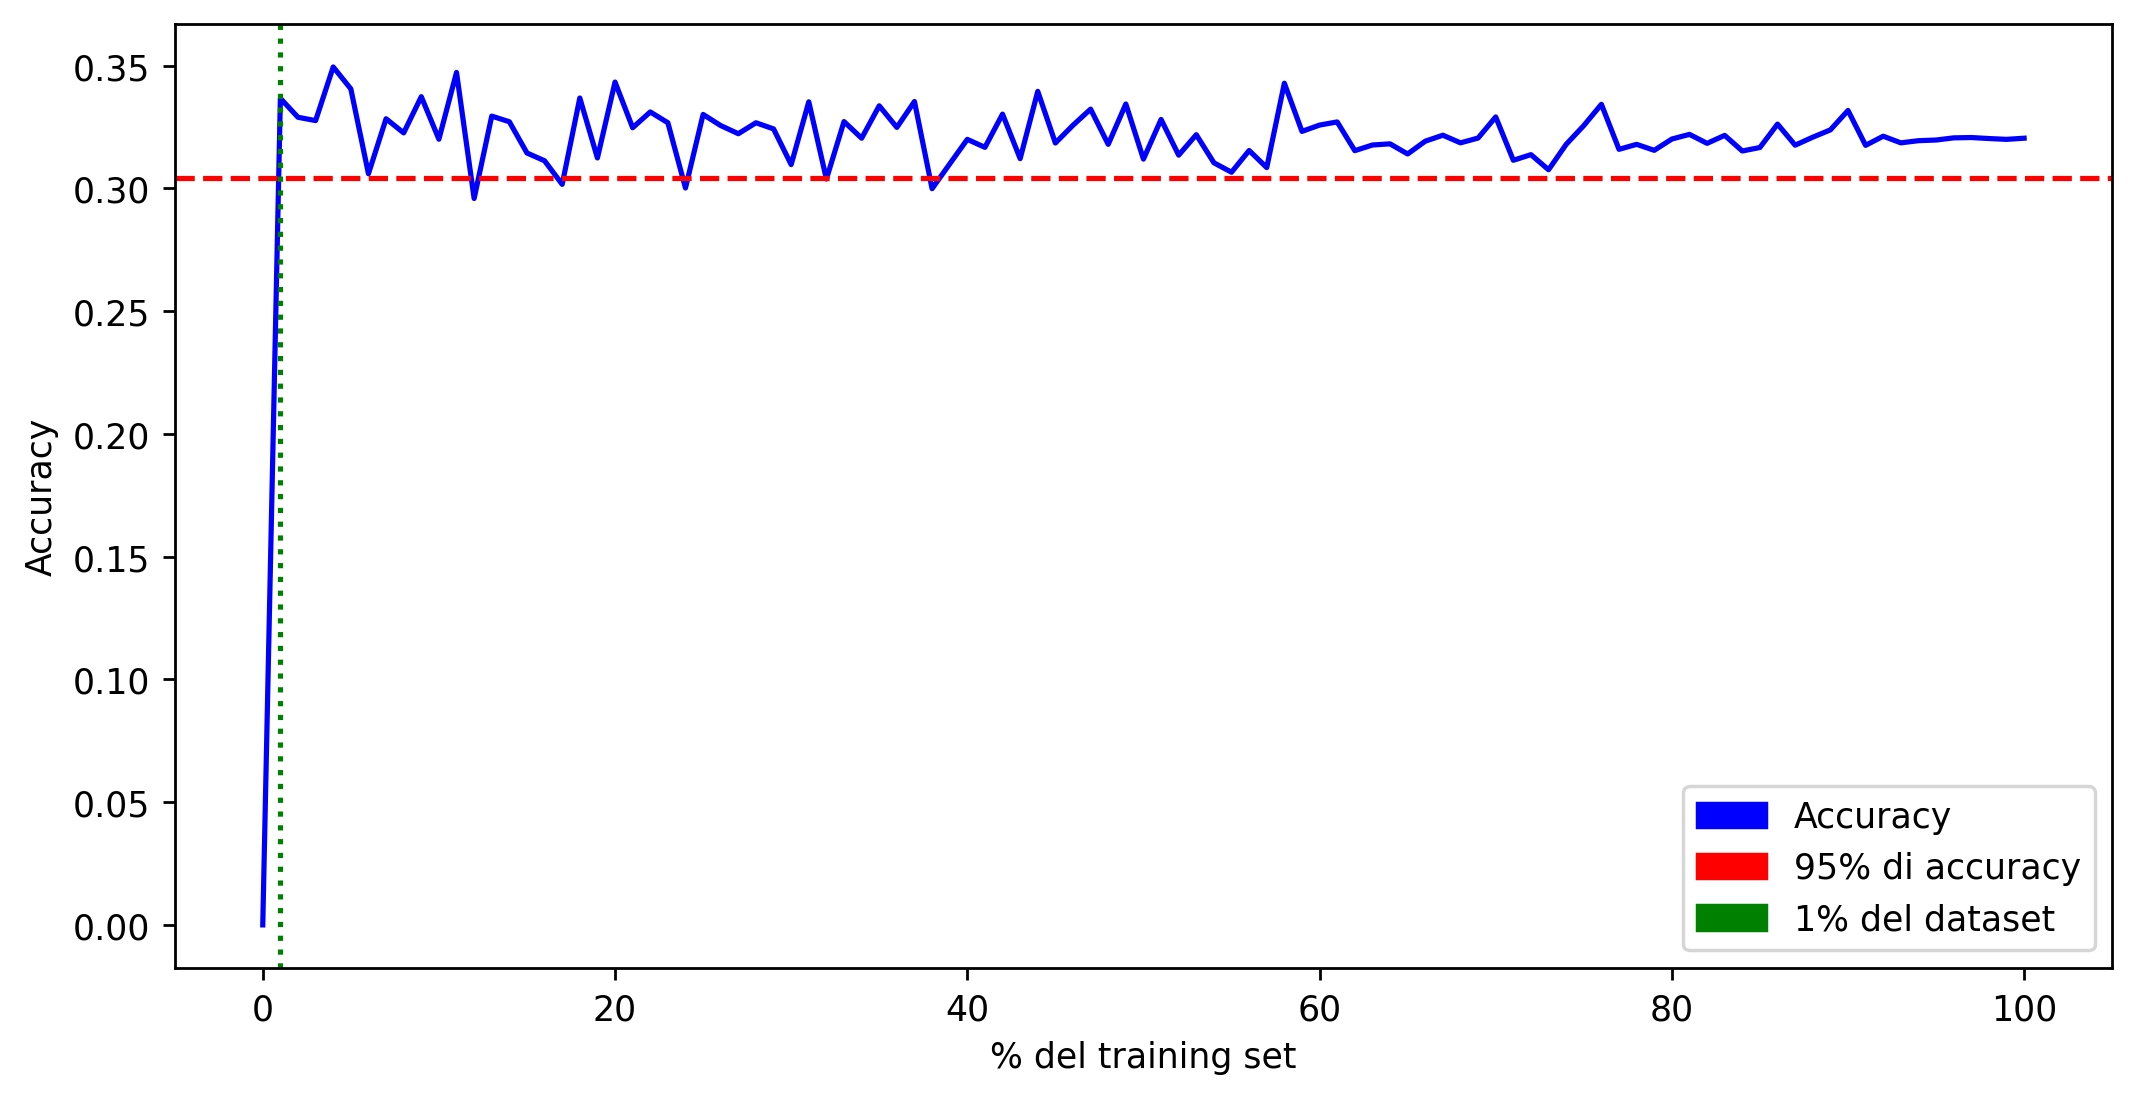

In [55]:
grafico(accuracyRes, yline=accuracyRes[100]*.95, ylabel="95% di accuracy", xline=1, xlabel="1% del dataset", label="Accuracy")
#plt.savefig("accuracy_naive.pdf", bbox_inches='tight')

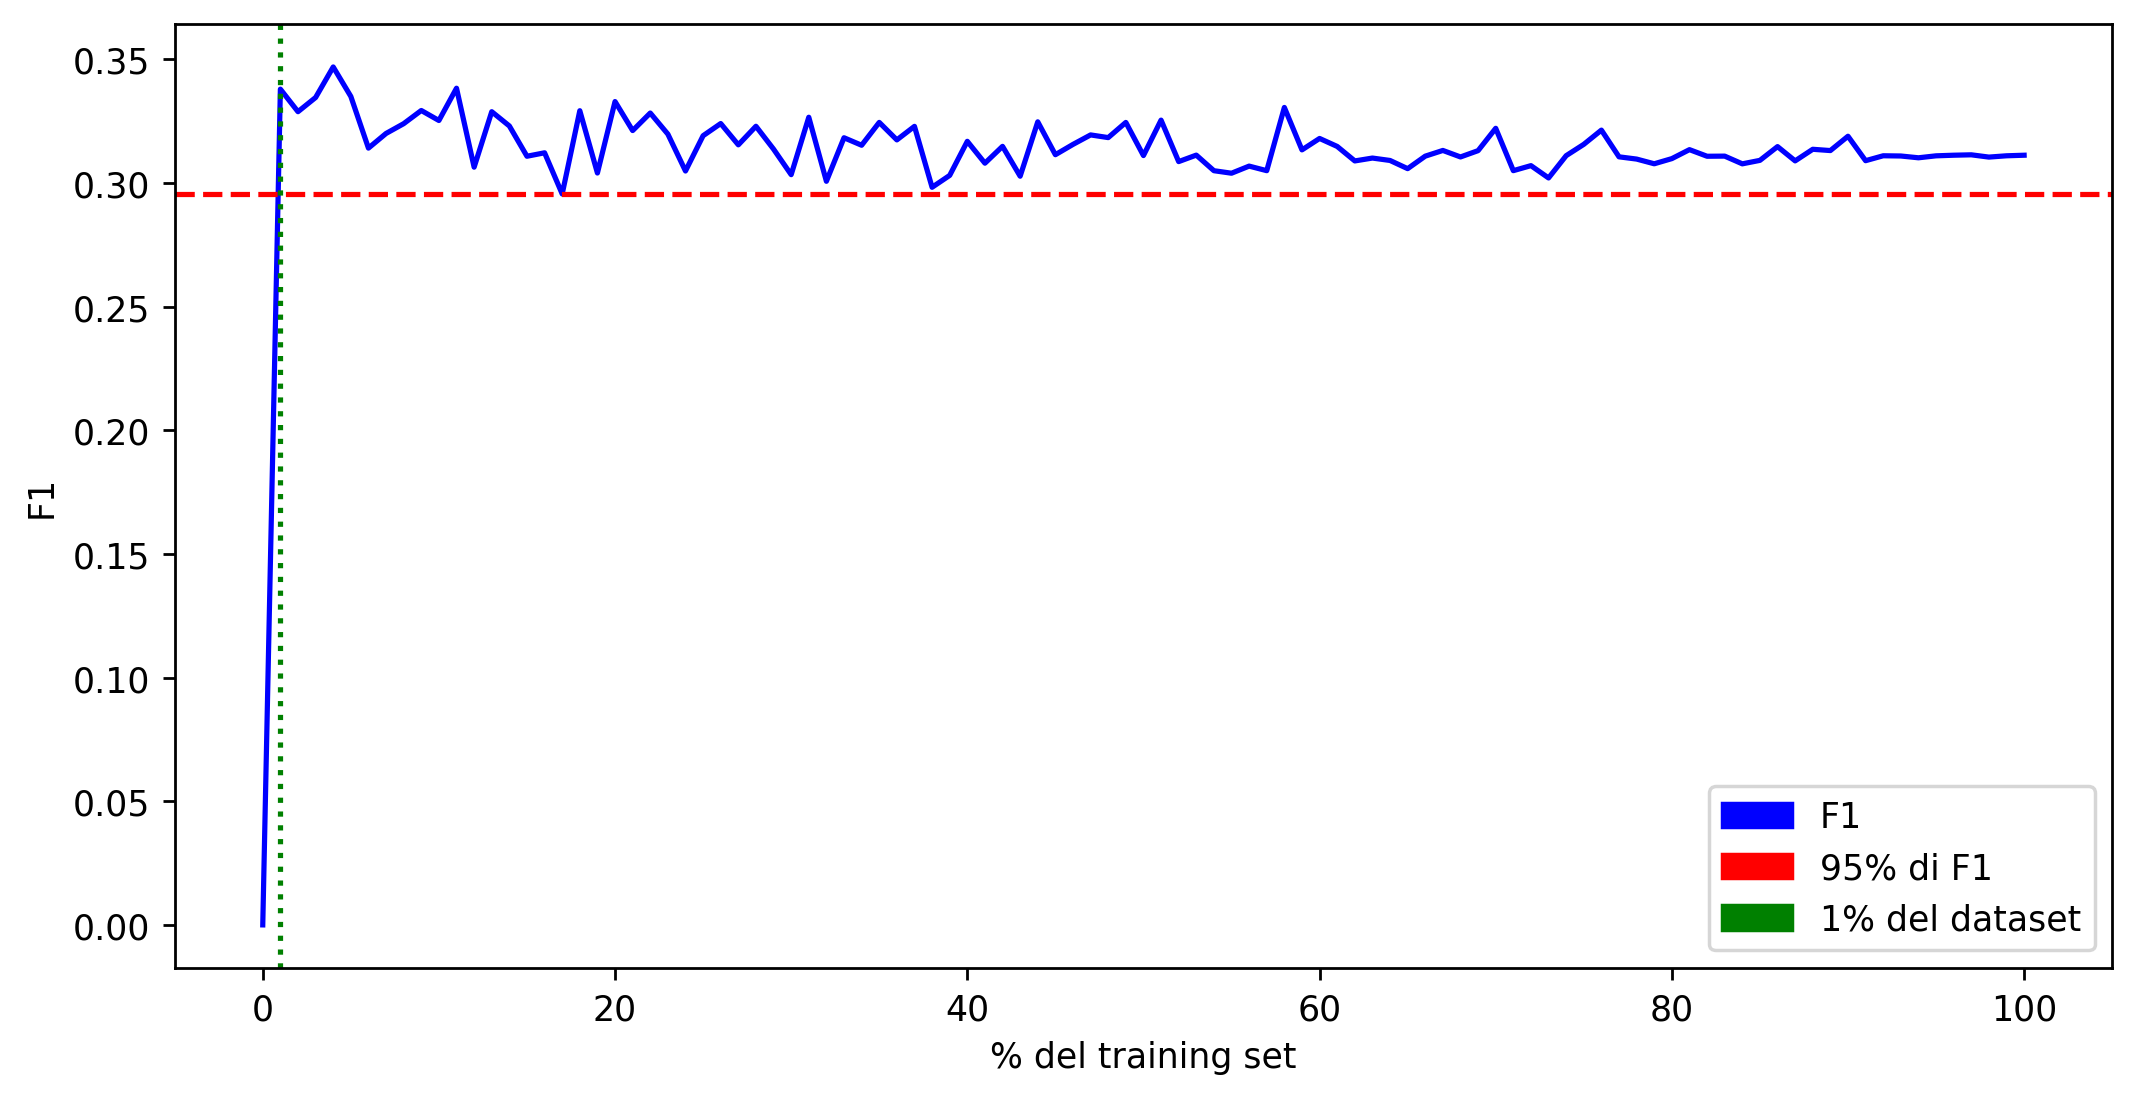

In [56]:
grafico(f1Res, yline=f1Res[100]*.95, ylabel="95% di F1", xline=1, xlabel="1% del dataset", label="F1")
#plt.savefig("f1_naive.pdf", bbox_inches='tight')

## Logistic regression

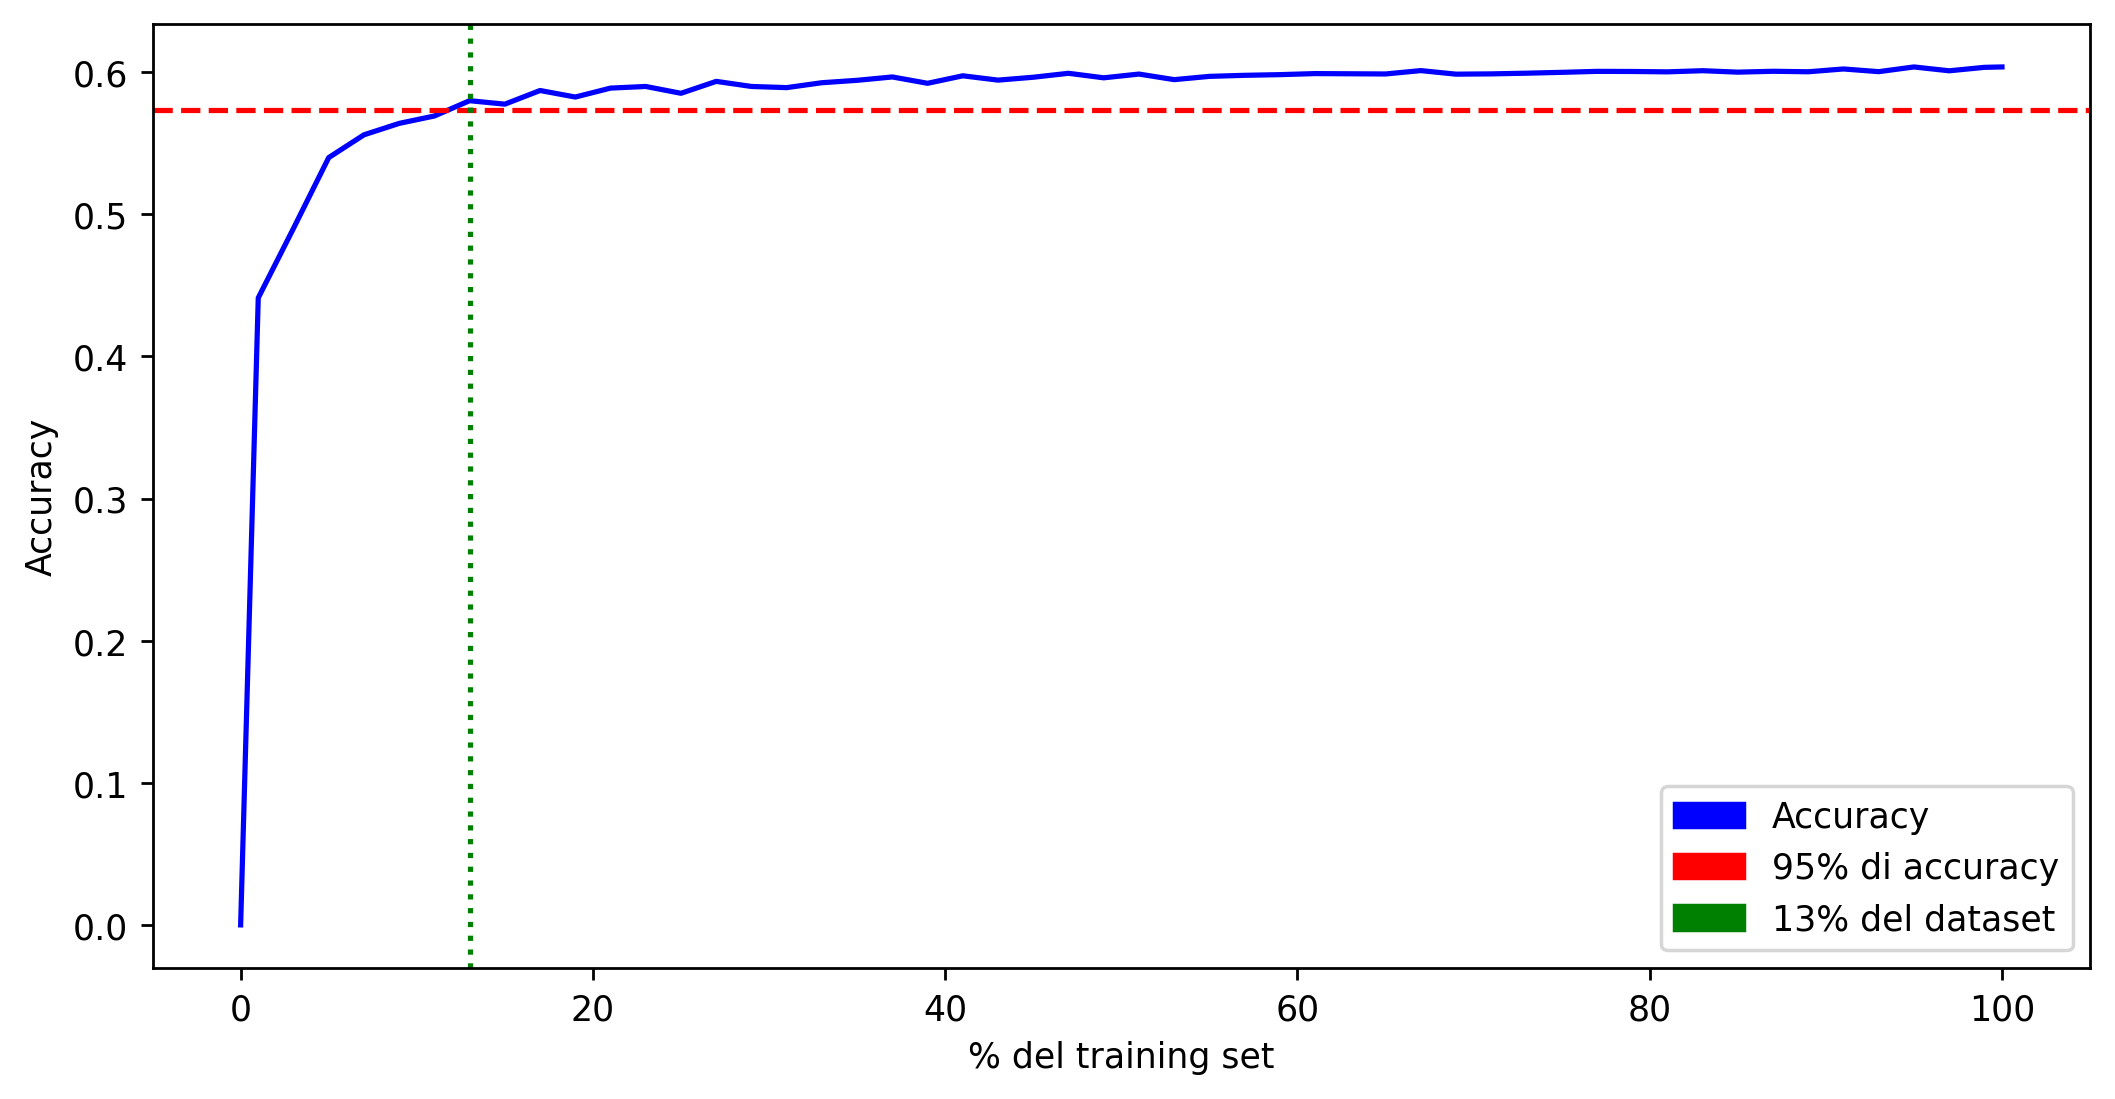

In [22]:
grafico(accuracyRes, yline=accuracyRes[100]*.95, ylabel="95% di accuracy", xline=13, xlabel="13% del dataset", label="Accuracy")
plt.savefig("accuracy_logistic.pdf", bbox_inches='tight')

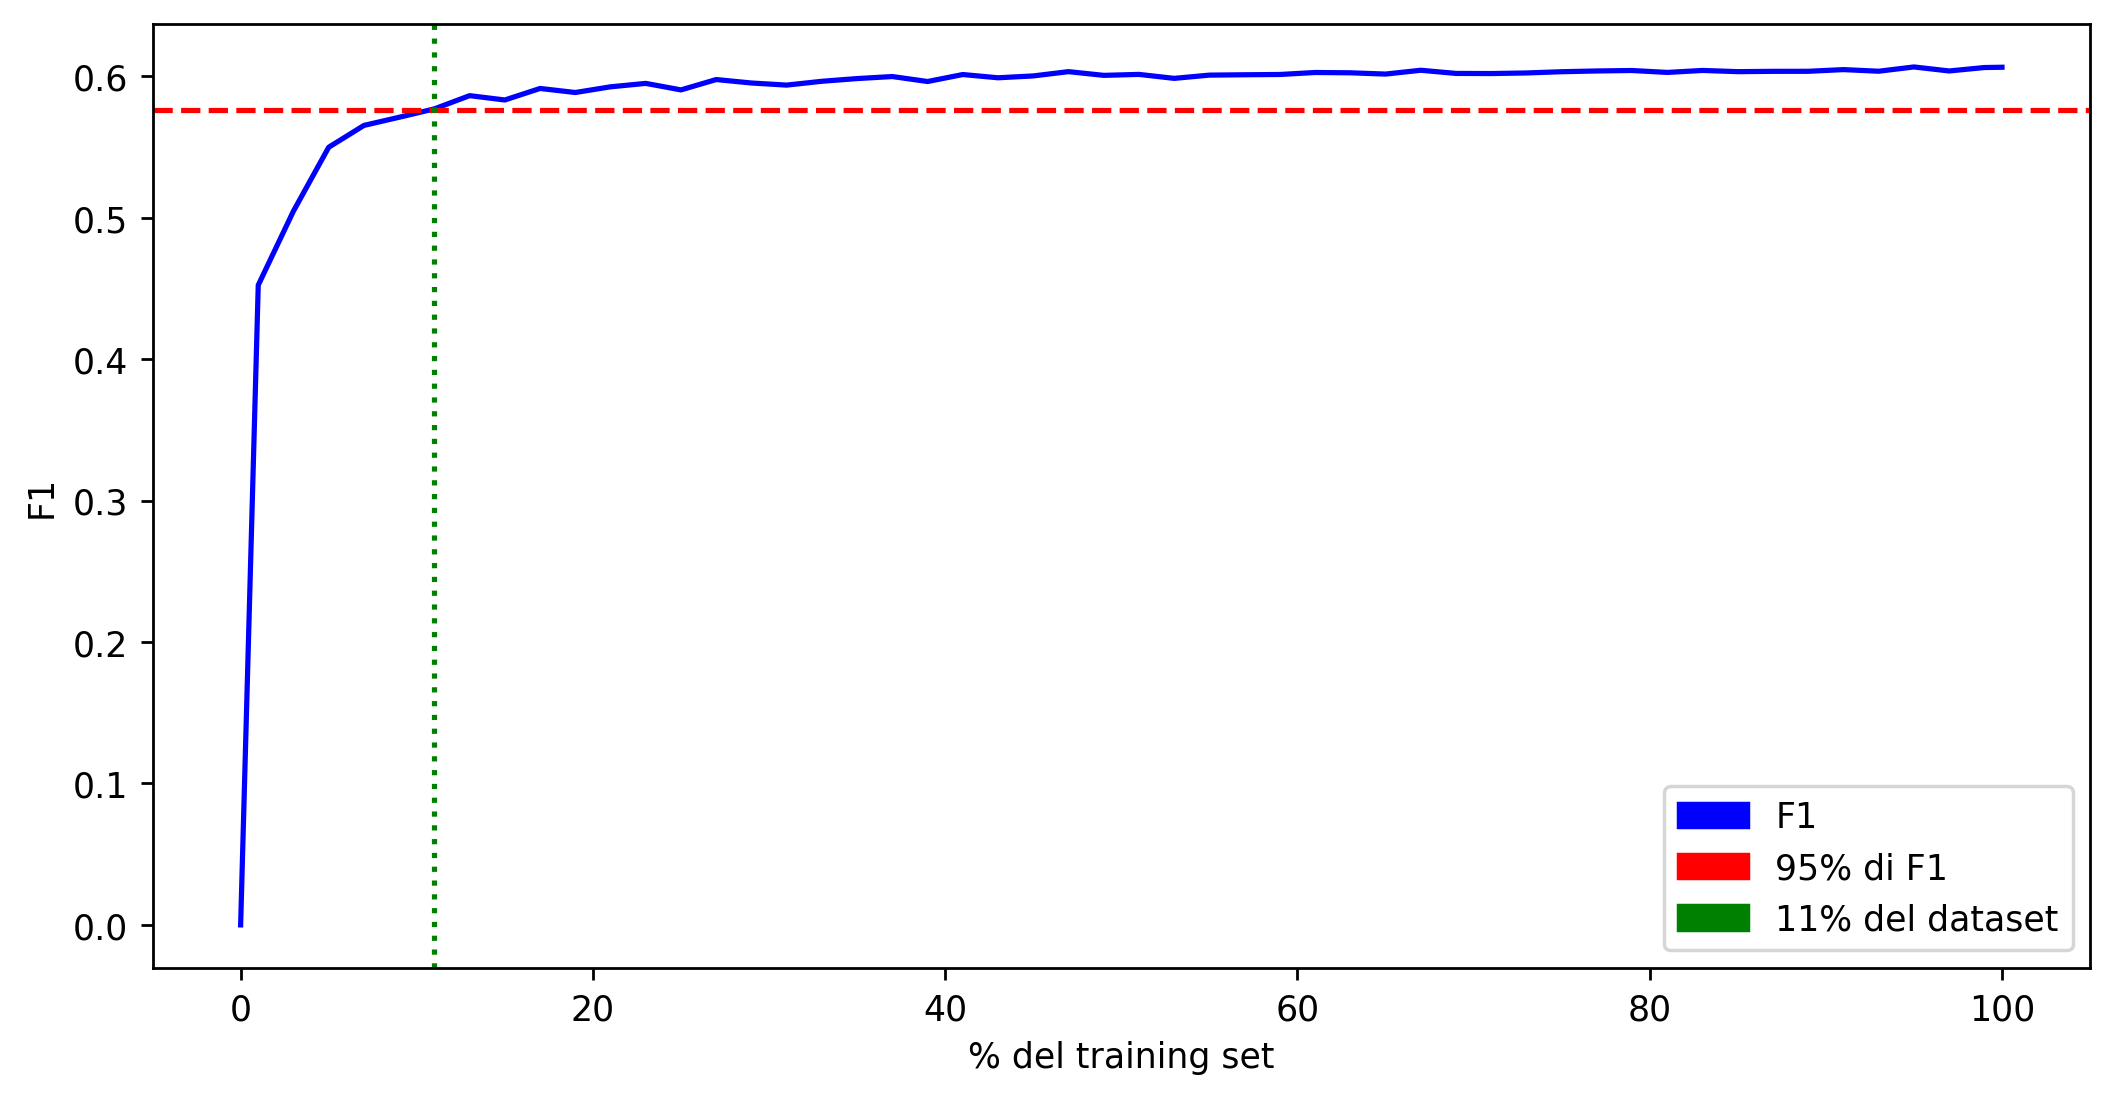

In [23]:
grafico(f1Res, yline=f1Res[100]*.95, ylabel="95% di F1", xline=11, xlabel="11% del dataset", label="F1")
plt.savefig("f1_logistic.pdf", bbox_inches='tight')

# Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [86]:
class_name = 'TRACK_genre_top_num'

attributes  = Diff(compl + features, ['TRACK_genre_top_num']) 
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

#scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [102]:
clf = LogisticRegression(C=100, random_state=0, max_iter=1000, class_weight='balanced', solver='liblinear', penalty='l2')
clf.fit(X_train, y_train)

LogisticRegression(C=100, class_weight='balanced', max_iter=1000,
                   random_state=0, solver='liblinear')

In [103]:
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.6034634377325306
F1-score [0.43745203 0.69318182 0.1793339  0.75619485 0.60034769 0.62919831
 0.4791562  0.59889409 0.4048913  0.39296188]
              precision    recall  f1-score   support

           0       0.41      0.47      0.44       611
           1       0.59      0.84      0.69       364
           2       0.22      0.15      0.18       697
           3       0.78      0.74      0.76      4247
           4       0.65      0.56      0.60      2778
           5       0.67      0.59      0.63      3163
           6       0.41      0.57      0.48       832
           7       0.55      0.66      0.60      1061
           8       0.35      0.48      0.40       621
           9       0.33      0.49      0.39       409

    accuracy                           0.60     14783
   macro avg       0.50      0.55      0.52     14783
weighted avg       0.62      0.60      0.61     14783



In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga'],
              'C': [0.01, 1, 10, 100, 1000]
             }

clf = LogisticRegression(random_state=0, max_iter=10000, class_weight='balanced')


grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=10, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.01, 1, 10, 100, 100],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy', verbose=10)

In [88]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.602 (std: 0.001)
Parameters: {'C': 10, 'solver': 'liblinear'}

Model with rank: 2
Mean validation score: 0.602 (std: 0.002)
Parameters: {'C': 100, 'solver': 'liblinear'}

Model with rank: 2
Mean validation score: 0.602 (std: 0.002)
Parameters: {'C': 100, 'solver': 'liblinear'}

Model with rank: 4
Mean validation score: 0.602 (std: 0.002)
Parameters: {'C': 1, 'solver': 'liblinear'}

Model with rank: 5
Mean validation score: 0.590 (std: 0.003)
Parameters: {'C': 0.01, 'solver': 'liblinear'}

Model with rank: 6
Mean validation score: 0.562 (std: 0.002)
Parameters: {'C': 1, 'solver': 'newton-cg'}

Model with rank: 7
Mean validation score: 0.561 (std: 0.002)
Parameters: {'C': 1, 'solver': 'lbfgs'}

Model with rank: 8
Mean validation score: 0.561 (std: 0.002)
Parameters: {'C': 10, 'solver': 'newton-cg'}

Model with rank: 9
Mean validation score: 0.561 (std: 0.002)
Parameters: {'C': 10, 'solver': 'lbfgs'}

Model with rank: 10
Mean validation score: 0

# RIPPER

In [10]:
import wittgenstein as lw
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

In [29]:
class_name = 'TRACK_genre_top_num'

attributes = compl + features

#scaler = StandardScaler()

X = df[attributes].values
#X = scaler.fit_transform(X)

#n_bins=10
#est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
#X = est.fit_transform(X)

y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [20]:
ripper_clf = lw.RIPPER(verbosity=5)
ripper_clf.fit(X_train, y_train, pos_class=0)
ripper_clf


0: fitting 56 unique vals into 10 bins
bin #0, floor idx 0 value: 1905.0, ceiling idx 3644 value: 2008.0
bin #1, floor idx 3645 value: 2008.0, ceiling idx 9773 value: 2010.0
bin #2, floor idx 9774 value: 2010.0, ceiling idx 16228 value: 2010.5
bin #3, floor idx 16229 value: 2010.5, ceiling idx 21681 value: 2013.0
bin #4, floor idx 21682 value: 2013.0, ceiling idx 28671 value: 2014.0
bin #5, floor idx 28672 value: 2014.0, ceiling idx 32649 value: 2016.0
bin #6, floor idx 32650 value: 2016.0, ceiling idx 34491 value: 2021.0
-bin sizes [3644, 6128, 6454, 5452, 6989, 3977, 1841]; dataVMR=0.01, binVMR=591
1: fitting 114 unique vals into 10 bins
bin #0, floor idx 0 value: 0.0, ceiling idx 15150 value: 0.6931471805599453
bin #1, floor idx 15151 value: 0.6931471805599453, ceiling idx 22960 value: 1.0986122886681098
bin #2, floor idx 22961 value: 1.0986122886681098, ceiling idx 26911 value: 1.3862943611198906
bin #3, floor idx 26912 value: 1.3862943611198906, ceiling idx 30453 value: 1.7917594

bin #1, floor idx 33753 value: -0.0019394953853213962, ceiling idx 34491 value: 1.5061636527961144
-bin sizes [33752, 738]; dataVMR=-1.72, binVMR=15801
20: fitting 34205 unique vals into 10 bins
bin #0, floor idx 0 value: -0.9980365644511752, ceiling idx 3450 value: -0.3571491824719524
bin #1, floor idx 3451 value: -0.35712813835643586, ceiling idx 6901 value: -0.25082018197678385
bin #2, floor idx 6902 value: -0.2507946861877516, ceiling idx 10352 value: -0.17157624344048664
bin #3, floor idx 10353 value: -0.1715342556880642, ceiling idx 13803 value: -0.10296391093489084
bin #4, floor idx 13804 value: -0.10292002138539537, ceiling idx 17254 value: -0.03570482948850194
bin #5, floor idx 17255 value: -0.035695918793284744, ceiling idx 20705 value: 0.030597834461139582
bin #6, floor idx 20706 value: 0.03060502103311978, ceiling idx 24156 value: 0.10200474732928286
bin #7, floor idx 24157 value: 0.10202946417405376, ceiling idx 27607 value: 0.1885532308473624
bin #8, floor idx 27608 value

bin #7, floor idx 24157 value: 37.13043153093171, ceiling idx 27607 value: 77.81590212561878
bin #8, floor idx 27608 value: 77.82117708562784, ceiling idx 31058 value: 134.6882177076183
bin #9, floor idx 31059 value: 134.69356367952682, ceiling idx 34491 value: 798.9300509651143
-bin sizes [3450, 3450, 3450, 3450, 3450, 3450, 3450, 3450, 3450, 3432]; dataVMR=-1051.92, binVMR=0.01
36: fitting 34204 unique vals into 10 bins
bin #0, floor idx 0 value: -555.9631752608586, ceiling idx 3450 value: -55.5814679057146
bin #1, floor idx 3451 value: -55.57465981814283, ceiling idx 6901 value: -39.635236944840344
bin #2, floor idx 6902 value: -39.62602188749087, ceiling idx 10352 value: -26.918175831969627
bin #3, floor idx 10353 value: -26.914633627886428, ceiling idx 13803 value: -15.648299377678333
bin #4, floor idx 13804 value: -15.647797134609112, ceiling idx 17254 value: -4.706085331044589
bin #5, floor idx 17255 value: -4.7043697897117775, ceiling idx 20705 value: 6.996155574502318
bin #6, 

bin #5, floor idx 17255 value: 0.004532784625566588, ceiling idx 20705 value: 0.03890536565914165
bin #6, floor idx 20706 value: 0.03890775912114768, ceiling idx 24156 value: 0.07685723171990767
bin #7, floor idx 24157 value: 0.0768983350137696, ceiling idx 27607 value: 0.12220359367900452
bin #8, floor idx 27608 value: 0.12222013912745075, ceiling idx 31058 value: 0.17967656935797874
bin #9, floor idx 31059 value: 0.1796796015743828, ceiling idx 34491 value: 0.5831645124682235
-bin sizes [3450, 3450, 3450, 3450, 3450, 3450, 3450, 3450, 3450, 3432]; dataVMR=1.8, binVMR=0.01
51: fitting 34205 unique vals into 10 bins
bin #0, floor idx 0 value: -10.33731666465402, ceiling idx 3450 value: -0.5793424108844579
bin #1, floor idx 3451 value: -0.5793322816572221, ceiling idx 6901 value: -0.3559448231382633
bin #2, floor idx 6902 value: -0.35592650161142003, ceiling idx 10352 value: -0.22499647548617707
bin #3, floor idx 10353 value: -0.22496345990810696, ceiling idx 13803 value: -0.12978501374

bin #9, floor idx 31059 value: 669.71862793, ceiling idx 34491 value: 2021.1788329999997
-bin sizes [3450, 3450, 3450, 3450, 3450, 3450, 3450, 3450, 3450, 3432]; dataVMR=69.9, binVMR=0.01
67: fitting 34197 unique vals into 10 bins
bin #0, floor idx 0 value: -1.9476768969999998, ceiling idx 3450 value: 0.14305509627000002
bin #1, floor idx 3451 value: 0.14312624931, ceiling idx 6901 value: 1.0968062878
bin #2, floor idx 6902 value: 1.0976842642, ceiling idx 10352 value: 2.21083498
bin #3, floor idx 10353 value: 2.2109467983, ceiling idx 13803 value: 3.7433395386000003
bin #4, floor idx 13804 value: 3.7434000969, ceiling idx 17254 value: 5.8724093437
bin #5, floor idx 17255 value: 5.8729019165, ceiling idx 20705 value: 9.1135797501
bin #6, floor idx 20706 value: 9.1137113571, ceiling idx 24156 value: 14.715763092000001
bin #7, floor idx 24157 value: 14.719865799, ceiling idx 27607 value: 24.566446304
bin #8, floor idx 27608 value: 24.568286896, ceiling idx 31058 value: 50.591743468999994

bin #9, floor idx 31061 value: 0.087207295001, ceiling idx 34491 value: 0.8780242800700001
-bin sizes [3450, 3450, 3450, 3452, 3450, 3450, 3450, 3450, 3450, 3430]; dataVMR=0.02, binVMR=0.01
84: fitting 644 unique vals into 10 bins
bin #0, floor idx 0 value: 0.0, ceiling idx 3670 value: 0.018798828125
bin #1, floor idx 3671 value: 0.01904296875, ceiling idx 7439 value: 0.025146484375
bin #2, floor idx 7440 value: 0.025390625, ceiling idx 10953 value: 0.030517578125
bin #3, floor idx 10954 value: 0.03076171875, ceiling idx 14674 value: 0.036376953125
bin #4, floor idx 14675 value: 0.03662109375, ceiling idx 18282 value: 0.042236328125
bin #5, floor idx 18283 value: 0.04248046875, ceiling idx 21791 value: 0.048583984375
bin #6, floor idx 21792 value: 0.048828125, ceiling idx 25242 value: 0.05615234375
bin #7, floor idx 25243 value: 0.05615234375, ceiling idx 28696 value: 0.06591796875
bin #8, floor idx 28697 value: 0.06591796875, ceiling idx 32181 value: 0.084716796875
bin #9, floor idx 3

prune value of [56=0.0-1.24^4=3.0^75=462.96-8257.98]: 0.2
prune value of [56=0.0-1.24^4=3.0]: -0.45
prune value of [56=0.0-1.24]: -0.84
pruned rule unchanged
updated ruleset: ...[12=-0.5--0.23^8=7.87-8.48^37=-0.41--0.1^55=2.21-2.8] V [56=0.0-1.24^4=3.0^75=462.96-8257.98^2=7.44-8.11]

rule theory bits| [56=0.0-1.24^4=3.0^75=462.96-8257.98^2=7.44-8.11] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 309 fp 33 fn 1149: exceptions_bits 7395
rule dl: 19.2
updated theory dl: 200
exceptions: 7395
total dl: 7595
mdl 7609 (diff -13.87 <= 64)
examples remaining: 1149 pos, 33034 neg

pos_growset 769 pos_pruneset 380
neg_growset 22132 neg_pruneset 10902
growing rule from initial rule: [True]
gain 249 12=-0.5--0.23
negs remaining: 2033
gain 55 24=-0.44--0.11
negs remaining: 755
gain 30.1 6=192000.0-256000.0
negs remaining: 231
gain 17.1 58=1.6-60.6
negs remaining: 54
gain 7.

total dl: 7444
mdl 7441 (diff 2.9 <= 64)
examples remaining: 1051 pos, 33013 neg

pos_growset 704 pos_pruneset 347
neg_growset 22118 neg_pruneset 10895
growing rule from initial rule: [True]
gain 216 31=-0.34--0.1
negs remaining: 2078
gain 40.3 24=-0.44--0.11
negs remaining: 761
gain 21.1 46=2.41-167.26
negs remaining: 106
gain 19 0=2013.0-2015.0
negs remaining: 7
gain 4.6 7=0.0-88.0
negs remaining: 0
grew rule: [31=-0.34--0.1^24=-0.44--0.11^46=2.41-167.26^0=2013.0-2015.0^7=0.0-88.0]
prune value of [31=-0.34--0.1^24=-0.44--0.11^46=2.41-167.26^0=2013.0-2015.0^7=0.0-88.0]: 1
prune value of [31=-0.34--0.1^24=-0.44--0.11^46=2.41-167.26^0=2013.0-2015.0]: 0.14
prune value of [31=-0.34--0.1^24=-0.44--0.11^46=2.41-167.26]: -0.69
prune value of [31=-0.34--0.1^24=-0.44--0.11]: -0.84
prune value of [31=-0.34--0.1]: -0.87
pruned rule unchanged
updated ruleset: ...[56=0.0-1.24^4=3.0^58=0.86-1.15^11=-0.92--0.56] V [31=-0.34--0.1^24=-0.44--0.11^46=2.41-167.26^0=2013.0-2015.0^7=0.0-88.0]

rule theory 

negs remaining: 47
gain 7.8 22=-0.09--0.09
negs remaining: 9
gain 4 5=5.0-9.0
negs remaining: 0
grew rule: [12=-0.5--0.23^31=-0.34--0.1^8=7.87-8.48^22=-0.09--0.09^5=5.0-9.0]
prune value of [12=-0.5--0.23^31=-0.34--0.1^8=7.87-8.48^22=-0.09--0.09^5=5.0-9.0]: 0
prune value of [12=-0.5--0.23^31=-0.34--0.1^8=7.87-8.48^22=-0.09--0.09]: -0.57
prune value of [12=-0.5--0.23^31=-0.34--0.1^8=7.87-8.48]: -0.67
prune value of [12=-0.5--0.23^31=-0.34--0.1]: -0.84
prune value of [12=-0.5--0.23]: -0.87
pruned rule unchanged
updated ruleset: ...[2=8.11-13.21^4=3.0^77=1776.49-2045.65^12=0.09-0.16] V [12=-0.5--0.23^31=-0.34--0.1^8=7.87-8.48^22=-0.09--0.09^5=5.0-9.0]

rule theory bits| [12=-0.5--0.23^31=-0.34--0.1^8=7.87-8.48^22=-0.09--0.09^5=5.0-9.0] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 516 fp 60 fn 969: exceptions_bits 6608
rule dl: 23.1
updated theory dl: 608
excep

 N 34492 p 599 fp 71 fn 897: exceptions_bits 6281
rule dl: 19.2
updated theory dl: 862
exceptions: 6281
total dl: 7142
mdl 7135 (diff 7 <= 64)
examples remaining: 897 pos, 32996 neg

pos_growset 600 pos_pruneset 297
neg_growset 22107 neg_pruneset 10889
growing rule from initial rule: [True]
gain 160 2=8.11-13.21
negs remaining: 2031
gain 32.9 31=-0.07--0.05
negs remaining: 205
gain 12.1 13=-0.06--0.03
negs remaining: 20
gain 6.8 81=19.51-31.95
negs remaining: 1
gain 1.1 57=0.0-0.0
negs remaining: 0
grew rule: [2=8.11-13.21^31=-0.07--0.05^13=-0.06--0.03^81=19.51-31.95^57=0.0-0.0]
prune value of [2=8.11-13.21^31=-0.07--0.05^13=-0.06--0.03^81=19.51-31.95^57=0.0-0.0]: 1
prune value of [2=8.11-13.21^31=-0.07--0.05^13=-0.06--0.03^81=19.51-31.95]: 1
prune value of [2=8.11-13.21^31=-0.07--0.05^13=-0.06--0.03]: -0.82
prune value of [2=8.11-13.21^31=-0.07--0.05]: -0.88
prune value of [2=8.11-13.21]: -0.91
pruned rule: [2=8.11-13.21^31=-0.07--0.05^13=-0.06--0.03^81=19.51-31.95]
updated ruleset: .

grew rule: [12=-0.5--0.23^78=53.83-107.67^87=0.0-0.02^64=300.0-398.12^11=-2.26--1.87]
prune value of [12=-0.5--0.23^78=53.83-107.67^87=0.0-0.02^64=300.0-398.12^11=-2.26--1.87]: 1
prune value of [12=-0.5--0.23^78=53.83-107.67^87=0.0-0.02^64=300.0-398.12]: -0.67
prune value of [12=-0.5--0.23^78=53.83-107.67^87=0.0-0.02]: -0.88
prune value of [12=-0.5--0.23^78=53.83-107.67]: -0.85
prune value of [12=-0.5--0.23]: -0.89
pruned rule unchanged
updated ruleset: ...[56=0.0-1.24^82=0.4-0.44^6=160000.0-192000.0^86=2.76-3.38^5=0.0-0.0] V [12=-0.5--0.23^78=53.83-107.67^87=0.0-0.02^64=300.0-398.12^11=-2.26--1.87]

rule theory bits| [12=-0.5--0.23^78=53.83-107.67^87=0.0-0.02^64=300.0-398.12^11=-2.26--1.87] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 686 fp 88 fn 827: exceptions_bits 5974
rule dl: 23.1
updated theory dl: 1138
exceptions: 5974
total dl: 7112
mdl 7106 (dif

rule theory bits| [3=0.0-1.0^33=111.12-924.15^38=-91.41--34.5^76=1087.96-1469.26^63=0.0-774.28] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 778 fp 110 fn 757: exceptions_bits 5672
rule dl: 23.1
updated theory dl: 1400
exceptions: 5672
total dl: 7072
mdl 7078 (diff -6.08 <= 64)
examples remaining: 757 pos, 32957 neg

pos_growset 507 pos_pruneset 250
neg_growset 22081 neg_pruneset 10876
growing rule from initial rule: [True]
gain 114 15=-0.03--0.03
negs remaining: 11924
gain 73.8 8=7.87-8.48
negs remaining: 1225
gain 24.7 14=-0.06--0.03
negs remaining: 110
gain 10.6 69=928.96-1049.82
negs remaining: 7
gain 3 7=465.0-3716.0
negs remaining: 0
grew rule: [15=-0.03--0.03^8=7.87-8.48^14=-0.06--0.03^69=928.96-1049.82^7=465.0-3716.0]
prune value of [15=-0.03--0.03^8=7.87-8.48^14=-0.06--0.03^69=928.96-1049.82^7=465.0-3716.0]: 1
prune value of [15=-0.03--0.03^8=7.87

gain 12.6 52=0.02-0.03
negs remaining: 22
gain 6 81=60.95-8438.01
negs remaining: 5
gain 2.3 1=0.0-0.69
negs remaining: 0
grew rule: [8=7.87-8.48^67=24.56-50.58^52=0.02-0.03^81=60.95-8438.01^1=0.0-0.69]
prune value of [8=7.87-8.48^67=24.56-50.58^52=0.02-0.03^81=60.95-8438.01^1=0.0-0.69]: 1
prune value of [8=7.87-8.48^67=24.56-50.58^52=0.02-0.03^81=60.95-8438.01]: -0.33
prune value of [8=7.87-8.48^67=24.56-50.58^52=0.02-0.03]: -0.75
prune value of [8=7.87-8.48^67=24.56-50.58]: -0.92
prune value of [8=7.87-8.48]: -0.93
pruned rule unchanged
updated ruleset: ...[56=0.0-1.24^22=-0.03--0.01^2=6.98-7.44^5=0.0-0.0] V [8=7.87-8.48^67=24.56-50.58^52=0.02-0.03^81=60.95-8438.01^1=0.0-0.69]

rule theory bits| [8=7.87-8.48^67=24.56-50.58^52=0.02-0.03^81=60.95-8438.01^1=0.0-0.69] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 842 fp 123 fn 706: exceptions_bits 5438
rule d

[31=-0.1--0.07 ^ 65=0.42-0.66 ^ 62=1516.28-1636.8 ^ 0=1905.0-2007.0 ^ 67=1.1-2.21]]

optimization run 1 of 2
optimizing ruleset...

calculate original ruleset potential dl...
find best potential dl for [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66] V [12=-0.5--0.23^24=-0.44--0.11^16=0.54-0.89^36=37.33-64.89] V [12=-0.5--0.23^24=-0.44--0.11^62=1309.84-1410.7^7=465.0-3716.0^70=674.63-807.91] V [31=-0.34--0.1^3=0.0-1.0^6=24000.0-160000.0^45=-6.8--3.2] V [12=-0.5--0.23^4=3.0^60=-1.96--0.71^37=-9.8--1.46] V [2=8.11-13.21^38=-91.41--34.5^34=71.9-124.54^85=0.01-0.26] V [31=-0.34--0.1^24=-0.44--0.11^82=0.4-0.44^4=4.0] V [12=-0.5--0.23^8=7.87-8.48^37=-0.41--0.1^55=2.21-2.8] V [56=0.0-1.24^4=3.0^75=462.96-8257.98^2=7.44-8.11] V [12=-0.5--0.23^24=-0.44--0.11^6=192000.0-256000.0^58=1.6-60.6^49=-0.01-0.0^7=335.0-465.0] V [12=-0.5--0.23^24=-0.44--0.11^6=192000.0-256000.0^37=-9.8--1.46^73=691.3-798.25^4=2.0] V [31=-0.34--0.1^4=3.0^0=

rule theory bits| [2=7.44-8.11^6=24000.0-160000.0^12=-0.23--0.17^3=0.0-1.0] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 562 fp 67 fn 930: exceptions_bits 6435
subset 0-33 | dl: 7173
rule theory bits| [12=-0.5--0.23^8=7.87-8.48^62=1636.8-1779.75^46=-0.27-0.52] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 568 fp 68 fn 925: exceptions_bits 6413
subset 0-34 | dl: 7171
rule theory bits| [8=8.48-15.01^5=0.0-0.0^30=1.73-98.79^38=-91.41--34.5] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 580 fp 69 fn 914: exceptions_bits 6361
subset 0-35 | dl: 7138
rule theory bits| [12=-0.5--0.23^30=-0.44--0.13^35=134.66-798.93^

 N 34492 p 729 fp 99 fn 795: exceptions_bits 5840
subset 0-58 | dl: 7105
rule theory bits| [56=0.0-1.24^1=0.0-0.69^59=0.92-1.21^25=-1.5--1.3^0=2007.0-2009.0] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 734 fp 101 fn 792: exceptions_bits 5830
subset 0-59 | dl: 7118
rule theory bits| [12=-0.5--0.23^3=1.0-2.0^76=2070.6-2323.8^56=0.0-1.24] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 739 fp 101 fn 787: exceptions_bits 5804
subset 0-60 | dl: 7112
rule theory bits| [31=-0.34--0.1^4=3.0^16=0.89-53.83^55=1.53-2.21^20=0.19-0.31] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 745 fp 101 fn 781: exceptions_bits 

best already included in optimization -- retaining original

examples remaining: 1250 pos, 33061 neg

creating replacement for 2 of 82: [12=-0.5--0.23^24=-0.44--0.11^16=0.54-0.89^36=37.33-64.89]
growing rule from initial rule: [True]
gain 314 12=-0.5--0.23
negs remaining: 2051
gain 72.1 24=-0.44--0.11
negs remaining: 765
gain 31.8 76=1805.16-2070.6
negs remaining: 77
gain 13 4=2.0
negs remaining: 6
gain 3.5 21=0.12-0.23
negs remaining: 0
grew rule: [12=-0.5--0.23^24=-0.44--0.11^76=1805.16-2070.6^4=2.0^21=0.12-0.23]
prune value of [12=-0.5--0.23^24=-0.44--0.11^76=1805.16-2070.6^4=2.0^21=0.12-0.23]: 0.96
prune value of [12=-0.5--0.23^24=-0.44--0.11^76=1805.16-2070.6^4=2.0]: 0.96
prune value of [12=-0.5--0.23^24=-0.44--0.11^76=1805.16-2070.6]: 0.96
prune value of [12=-0.5--0.23^24=-0.44--0.11]: 0.93
prune value of [12=-0.5--0.23]: 0.88
grew replacement [12=-0.5--0.23^24=-0.44--0.11^76=1805.16-2070.6^4=2.0^21=0.12-0.23]
pruned replacement is [12=-0.5--0.23^24=-0.44--0.11^76=1805.16-2070.6^

prune value of [12=-0.5--0.23^24=-0.44--0.11^56=0.0-1.24^73=691.3-798.25^4=2.0^0=2009.0-2010.0]: 0.97
prune value of [12=-0.5--0.23^24=-0.44--0.11^56=0.0-1.24^73=691.3-798.25^4=2.0]: 0.97
prune value of [12=-0.5--0.23^24=-0.44--0.11^56=0.0-1.24^73=691.3-798.25]: 0.96
prune value of [12=-0.5--0.23^24=-0.44--0.11^56=0.0-1.24]: 0.96
prune value of [12=-0.5--0.23^24=-0.44--0.11]: 0.94
prune value of [12=-0.5--0.23]: 0.88
grew replacement [12=-0.5--0.23^24=-0.44--0.11^56=0.0-1.24^73=691.3-798.25^4=2.0^0=2009.0-2010.0]
pruned replacement is [12=-0.5--0.23^24=-0.44--0.11^56=0.0-1.24^73=691.3-798.25^4=2.0]
creating revision for 9 of 82: [56=0.0-1.24^4=3.0^75=462.96-8257.98^2=7.44-8.11]
growing rule from initial rule: [56=0.0-1.24^4=3.0^75=462.96-8257.98^2=7.44-8.11]
grew rule: [56=0.0-1.24^4=3.0^75=462.96-8257.98^2=7.44-8.11]
prune value of [56=0.0-1.24^4=3.0^75=462.96-8257.98^2=7.44-8.11]: 0.97
prune value of [56=0.0-1.24^4=3.0^75=462.96-8257.98]: 0.97
prune value of [56=0.0-1.24^4=3.0]: 0.96

grew rule: [12=-0.5--0.23^24=-0.44--0.11^83=0.02-0.03^64=300.0-398.12^44=0.75-1.24^49=0.02-0.04]
prune value of [12=-0.5--0.23^24=-0.44--0.11^83=0.02-0.03^64=300.0-398.12^44=0.75-1.24^49=0.02-0.04]: 0.97
prune value of [12=-0.5--0.23^24=-0.44--0.11^83=0.02-0.03^64=300.0-398.12^44=0.75-1.24]: 0.97
prune value of [12=-0.5--0.23^24=-0.44--0.11^83=0.02-0.03^64=300.0-398.12]: 0.97
prune value of [12=-0.5--0.23^24=-0.44--0.11^83=0.02-0.03]: 0.96
prune value of [12=-0.5--0.23^24=-0.44--0.11]: 0.94
prune value of [12=-0.5--0.23]: 0.89
grew revision [12=-0.5--0.23^24=-0.44--0.11^31=-0.34--0.1^70=930.38-1048.38^79=0.88-1.18^32=-6.94--5.21]
pruned revision is [12=-0.5--0.23^24=-0.44--0.11^31=-0.34--0.1^70=930.38-1048.38^79=0.88-1.18^32=-6.94--5.21]

calculate potential dl for ds with replacement [12=-0.5--0.23^24=-0.44--0.11^31=-0.34--0.1^70=930.38-1048.38^79=0.88-1.18^32=-6.94--5.21]
calculate potential dl for ds with revision [12=-0.5--0.23^24=-0.44--0.11^83=0.02-0.03^64=300.0-398.12^44=0.75-1.

grew rule: [12=-0.5--0.23^8=8.48-15.01^65=0.92-1.27^34=-69.83--46.17]
prune value of [12=-0.5--0.23^8=8.48-15.01^65=0.92-1.27^34=-69.83--46.17]: 0.97
prune value of [12=-0.5--0.23^8=8.48-15.01^65=0.92-1.27]: 0.97
prune value of [12=-0.5--0.23^8=8.48-15.01]: 0.96
prune value of [12=-0.5--0.23]: 0.89
grew revision [3=0.0-1.0^6=24000.0-160000.0^4=4.0^29=-0.02--0.02^5=9.0-15.0^0=2007.0-2009.0]
pruned revision is [3=0.0-1.0^6=24000.0-160000.0^4=4.0^29=-0.02--0.02^5=9.0-15.0^0=2007.0-2009.0]

calculate potential dl for ds with replacement [3=0.0-1.0^6=24000.0-160000.0^4=4.0^29=-0.02--0.02^5=9.0-15.0^0=2007.0-2009.0]
calculate potential dl for ds with revision [12=-0.5--0.23^8=8.48-15.01^65=0.92-1.27^34=-69.83--46.17]

rule 23 of 82
original: [12=-0.5--0.23^8=8.48-15.01^65=0.92-1.27^34=-69.83--46.17]) | 6891 bits
replacement: [3=0.0-1.0^6=24000.0-160000.0^4=4.0^29=-0.02--0.02^5=9.0-15.0^0=2007.0-2009.0] | 7180 bits
revision: unchanged | 6891 bits
*best: unchanged | 6891 bits
best already incl

gain 168 12=-0.5--0.23
negs remaining: 2063
gain 41.2 8=7.87-8.48
negs remaining: 188
gain 11.9 63=1608.71-1772.7
negs remaining: 8
gain 4 3=1.0-2.0
negs remaining: 0
grew rule: [12=-0.5--0.23^8=7.87-8.48^63=1608.71-1772.7^3=1.0-2.0]
prune value of [12=-0.5--0.23^8=7.87-8.48^63=1608.71-1772.7^3=1.0-2.0]: 0.97
prune value of [12=-0.5--0.23^8=7.87-8.48^63=1608.71-1772.7]: 0.97
prune value of [12=-0.5--0.23^8=7.87-8.48]: 0.96
prune value of [12=-0.5--0.23]: 0.89
grew replacement [12=-0.5--0.23^8=7.87-8.48^63=1608.71-1772.7^3=1.0-2.0]
pruned replacement is [12=-0.5--0.23^8=7.87-8.48^63=1608.71-1772.7^3=1.0-2.0]
creating revision for 30 of 82: [2=8.11-13.21^0=2009.0-2010.0^68=5249.03-5491.41^69=791.1-928.96^84=0.02-0.02]
growing rule from initial rule: [2=8.11-13.21^0=2009.0-2010.0^68=5249.03-5491.41^69=791.1-928.96^84=0.02-0.02]
grew rule: [2=8.11-13.21^0=2009.0-2010.0^68=5249.03-5491.41^69=791.1-928.96^84=0.02-0.02]
prune value of [2=8.11-13.21^0=2009.0-2010.0^68=5249.03-5491.41^69=791.1-

creating revision for 37 of 82: [12=-0.5--0.23^52=0.03-0.06^36=20.74-37.33^86=6.38-75.71]
growing rule from initial rule: [12=-0.5--0.23^52=0.03-0.06^36=20.74-37.33^86=6.38-75.71]
gain 0.89 62=1067.35-1204.32
negs remaining: 0
grew rule: [12=-0.5--0.23^52=0.03-0.06^36=20.74-37.33^86=6.38-75.71^62=1067.35-1204.32]
prune value of [12=-0.5--0.23^52=0.03-0.06^36=20.74-37.33^86=6.38-75.71^62=1067.35-1204.32]: 0.97
prune value of [12=-0.5--0.23^52=0.03-0.06^36=20.74-37.33^86=6.38-75.71]: 0.97
prune value of [12=-0.5--0.23^52=0.03-0.06^36=20.74-37.33]: 0.97
prune value of [12=-0.5--0.23^52=0.03-0.06]: 0.96
prune value of [12=-0.5--0.23]: 0.89
grew revision [12=-0.5--0.23^30=-0.44--0.13^1=1.61-2.94^54=13.81-15.13]
pruned revision is [12=-0.5--0.23^30=-0.44--0.13^1=1.61-2.94^54=13.81-15.13]

calculate potential dl for ds with replacement [12=-0.5--0.23^30=-0.44--0.13^1=1.61-2.94^54=13.81-15.13]
calculate potential dl for ds with revision [12=-0.5--0.23^52=0.03-0.06^36=20.74-37.33^86=6.38-75.71]

prune value of [2=7.44-8.11^0=2007.0-2009.0^82=0.65-1.0]: 0.97
prune value of [2=7.44-8.11^0=2007.0-2009.0]: 0.96
prune value of [2=7.44-8.11]: 0.89
grew revision [31=-0.34--0.1^48=-0.0-0.01^83=0.04-0.04^8=7.46-7.87^29=-0.02--0.02]
pruned revision is [31=-0.34--0.1^48=-0.0-0.01^83=0.04-0.04^8=7.46-7.87]

calculate potential dl for ds with replacement [31=-0.34--0.1^48=-0.0-0.01^83=0.04-0.04^8=7.46-7.87]
calculate potential dl for ds with revision [2=7.44-8.11^0=2007.0-2009.0^82=0.65-1.0^77=3219.21-4037.48]

rule 45 of 82
original: [2=7.44-8.11^0=2007.0-2009.0^82=0.65-1.0^77=3219.21-4037.48^27=-0.28--0.18]) | 6891 bits
replacement: [31=-0.34--0.1^48=-0.0-0.01^83=0.04-0.04^8=7.46-7.87] | 7155 bits
revision: [2=7.44-8.11^0=2007.0-2009.0^82=0.65-1.0^77=3219.21-4037.48] | 7139 bits
*best: unchanged | 6891 bits
best already included in optimization -- retaining original

examples remaining: 874 pos, 32988 neg

creating replacement for 45 of 82: [56=0.0-1.24^4=3.0^48=-0.01--0.0^6=256000.0-320

pruned revision is [56=0.0-1.24^4=3.0^77=2045.65-2357.89^16=-0.07-0.1]

calculate potential dl for ds with replacement [56=0.0-1.24^4=3.0^77=2045.65-2357.89^16=-0.07-0.1]
calculate potential dl for ds with revision [56=0.0-1.24^82=0.4-0.44^6=160000.0-192000.0^86=2.76-3.38^5=0.0-0.0]

rule 52 of 82
original: [56=0.0-1.24^82=0.4-0.44^6=160000.0-192000.0^86=2.76-3.38^5=0.0-0.0]) | 6891 bits
replacement: [56=0.0-1.24^4=3.0^77=2045.65-2357.89^16=-0.07-0.1] | 7158 bits
revision: unchanged | 6891 bits
*best: unchanged | 6891 bits
best already included in optimization -- retaining original

examples remaining: 831 pos, 32979 neg

creating replacement for 52 of 82: [12=-0.5--0.23^78=53.83-107.67^87=0.0-0.02^64=300.0-398.12^11=-2.26--1.87]
growing rule from initial rule: [True]
gain 131 8=8.48-15.01
negs remaining: 1992
gain 28.9 1=2.94-7.3
negs remaining: 336
gain 19.7 24=-0.44--0.11
negs remaining: 30
gain 7.5 43=0.02-1.4
negs remaining: 1
gain 1.1 6=256000.0-320000.0
negs remaining: 0
grew ru

calculate potential dl for ds with replacement [12=-0.5--0.23^1=1.61-2.94^34=4.38-35.24^31=-0.1--0.07]
calculate potential dl for ds with revision [56=0.0-1.24^24=-0.44--0.11^83=0.06-0.06^79=2.04-2.84^27=0.24-0.39]

rule 59 of 82
original: [56=0.0-1.24^24=-0.44--0.11^83=0.06-0.06^79=2.04-2.84]) | 6891 bits
replacement: [12=-0.5--0.23^1=1.61-2.94^34=4.38-35.24^31=-0.1--0.07] | 7129 bits
revision: [56=0.0-1.24^24=-0.44--0.11^83=0.06-0.06^79=2.04-2.84^27=0.24-0.39] | 7133 bits
*best: unchanged | 6891 bits
best already included in optimization -- retaining original

examples remaining: 795 pos, 32968 neg

creating replacement for 59 of 82: [56=0.0-1.24^1=0.0-0.69^59=0.92-1.21^25=-1.5--1.3^0=2007.0-2009.0]
growing rule from initial rule: [True]
gain 119 12=-0.5--0.23
negs remaining: 2008
gain 27.5 57=0.0-0.03
negs remaining: 152
gain 16 65=0.66-0.92
negs remaining: 13
gain 4.8 0=2013.0-2015.0
negs remaining: 0
grew rule: [12=-0.5--0.23^57=0.0-0.03^65=0.66-0.92^0=2013.0-2015.0]
prune value o

*best: unchanged | 6891 bits
best already included in optimization -- retaining original

examples remaining: 754 pos, 32957 neg

creating replacement for 66 of 82: [2=8.11-13.21^5=0.0-1.0^21=-1.18--0.43^24=0.12-0.69]
growing rule from initial rule: [True]
gain 103 8=7.87-8.48
negs remaining: 2114
gain 29 5=5.0-9.0
negs remaining: 229
gain 15.5 12=-0.23--0.17
negs remaining: 14
gain 5.7 81=12.89-19.51
negs remaining: 1
gain 0.89 0=2010.0-2012.0
negs remaining: 0
grew rule: [8=7.87-8.48^5=5.0-9.0^12=-0.23--0.17^81=12.89-19.51^0=2010.0-2012.0]
prune value of [8=7.87-8.48^5=5.0-9.0^12=-0.23--0.17^81=12.89-19.51^0=2010.0-2012.0]: 0.98
prune value of [8=7.87-8.48^5=5.0-9.0^12=-0.23--0.17^81=12.89-19.51]: 0.98
prune value of [8=7.87-8.48^5=5.0-9.0^12=-0.23--0.17]: 0.98
prune value of [8=7.87-8.48^5=5.0-9.0]: 0.97
prune value of [8=7.87-8.48]: 0.89
grew replacement [8=7.87-8.48^5=5.0-9.0^12=-0.23--0.17^81=12.89-19.51^0=2010.0-2012.0]
pruned replacement is [8=7.87-8.48^5=5.0-9.0^12=-0.23--0.17

prune value of [31=-0.34--0.1^0=2007.0-2009.0^6=256000.0-320000.0^5=3.0-5.0]: 0.98
prune value of [31=-0.34--0.1^0=2007.0-2009.0^6=256000.0-320000.0]: 0.98
prune value of [31=-0.34--0.1^0=2007.0-2009.0]: 0.96
prune value of [31=-0.34--0.1]: 0.89
grew replacement [31=-0.34--0.1^0=2007.0-2009.0^6=256000.0-320000.0^5=3.0-5.0^8=5.5-5.95]
pruned replacement is [31=-0.34--0.1^0=2007.0-2009.0^6=256000.0-320000.0^5=3.0-5.0^8=5.5-5.95]
creating revision for 73 of 82: [31=-0.34--0.1^41=2.45-5.47^1=0.69-1.1^75=9463.84-9539.21]
growing rule from initial rule: [31=-0.34--0.1^41=2.45-5.47^1=0.69-1.1^75=9463.84-9539.21]
gain 0.97 6=256000.0-320000.0
negs remaining: 0
grew rule: [31=-0.34--0.1^41=2.45-5.47^1=0.69-1.1^75=9463.84-9539.21^6=256000.0-320000.0]
prune value of [31=-0.34--0.1^41=2.45-5.47^1=0.69-1.1^75=9463.84-9539.21^6=256000.0-320000.0]: 0.98
prune value of [31=-0.34--0.1^41=2.45-5.47^1=0.69-1.1^75=9463.84-9539.21]: 0.98
prune value of [31=-0.34--0.1^41=2.45-5.47^1=0.69-1.1]: 0.98
prune va

gain 25.9 34=4.38-35.24
negs remaining: 173
gain 9.4 18=-0.93--0.78
negs remaining: 9
gain 4.5 35=37.12-77.81
negs remaining: 2
gain 1.2 7=160.0-186.0
negs remaining: 0
grew rule: [2=8.11-13.21^34=4.38-35.24^18=-0.93--0.78^35=37.12-77.81^7=160.0-186.0]
prune value of [2=8.11-13.21^34=4.38-35.24^18=-0.93--0.78^35=37.12-77.81^7=160.0-186.0]: 0.98
prune value of [2=8.11-13.21^34=4.38-35.24^18=-0.93--0.78^35=37.12-77.81]: 0.98
prune value of [2=8.11-13.21^34=4.38-35.24^18=-0.93--0.78]: 0.98
prune value of [2=8.11-13.21^34=4.38-35.24]: 0.97
prune value of [2=8.11-13.21]: 0.89
grew replacement [2=8.11-13.21^34=4.38-35.24^18=-0.93--0.78^35=37.12-77.81^7=160.0-186.0]
pruned replacement is [2=8.11-13.21^34=4.38-35.24^18=-0.93--0.78^35=37.12-77.81^7=160.0-186.0]
creating revision for 80 of 82: [15=-0.03--0.03^12=-0.5--0.23^38=-8.68--2.11^80=904.44-1041.15^50=-0.11--0.07^34=71.9-124.54]
growing rule from initial rule: [15=-0.03--0.03^12=-0.5--0.23^38=-8.68--2.11^80=904.44-1041.15^50=-0.11--0.07^3

[31=-0.1--0.07 ^ 65=0.42-0.66 ^ 62=1516.28-1636.8 ^ 0=1905.0-2007.0 ^ 67=1.1-2.21]]

No changes were made. Halting optimization.
1425 pos left. Growing final rules...
growing ruleset...

pos_growset 954 pos_pruneset 471
neg_growset 22154 neg_pruneset 10913
growing rule from initial rule: [True]
gain 483 3=0.0-1.0
negs remaining: 3876
gain 428 30=1.73-98.79
negs remaining: 413
gain 184 38=-91.41--34.5
negs remaining: 60
gain 43.2 5=0.0-0.0
negs remaining: 6
gain 6.3 41=9.5-31.96
negs remaining: 0
grew rule: [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^41=9.5-31.96]
prune value of [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^41=9.5-31.96]: 0.92
prune value of [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0]: 0.84
prune value of [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5]: 0.41
prune value of [3=0.0-1.0^30=1.73-98.79]: -0.35
prune value of [3=0.0-1.0]: -0.82
pruned rule unchanged
updated ruleset: ...[31=-0.1--0.07^65=0.42-0.66^62=1516.28-1636.8^0=1905.0-2007.0^67=1.1-2.21] V 

[12=-0.5--0.23 ^ 4=3.0 ^ 58=1.6-60.6 ^ 5=1.0-3.0 ^ 0=2010.0-2012.0]]

Optimizing dl...
find best potential dl for [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66] V [12=-0.5--0.23^24=-0.44--0.11^16=0.54-0.89^36=37.33-64.89] V [12=-0.5--0.23^24=-0.44--0.11^62=1309.84-1410.7^7=465.0-3716.0^70=674.63-807.91] V [31=-0.34--0.1^3=0.0-1.0^6=24000.0-160000.0^45=-6.8--3.2] V [12=-0.5--0.23^4=3.0^60=-1.96--0.71^37=-9.8--1.46] V [2=8.11-13.21^38=-91.41--34.5^34=71.9-124.54^85=0.01-0.26] V [31=-0.34--0.1^24=-0.44--0.11^82=0.4-0.44^4=4.0] V [12=-0.5--0.23^8=7.87-8.48^37=-0.41--0.1^55=2.21-2.8] V [56=0.0-1.24^4=3.0^75=462.96-8257.98^2=7.44-8.11] V [12=-0.5--0.23^24=-0.44--0.11^6=192000.0-256000.0^58=1.6-60.6^49=-0.01-0.0^7=335.0-465.0] V [12=-0.5--0.23^24=-0.44--0.11^6=192000.0-256000.0^37=-9.8--1.46^73=691.3-798.25^4=2.0] V [31=-0.34--0.1^4=3.0^0=2010.0-2012.0^49=0.01-0.02^85=0.0-0.0] V [3=0.0-1.0^28=-1.41--0.54^45=-6.8--3.2^78=570.6

 N 34492 p 552 fp 65 fn 938: exceptions_bits 6469
subset 0-32 | dl: 7188
rule theory bits| [2=7.44-8.11^6=24000.0-160000.0^12=-0.23--0.17^3=0.0-1.0] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 562 fp 67 fn 930: exceptions_bits 6435
subset 0-33 | dl: 7173
rule theory bits| [12=-0.5--0.23^8=7.87-8.48^62=1636.8-1779.75^46=-0.27-0.52] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 568 fp 68 fn 925: exceptions_bits 6413
subset 0-34 | dl: 7171
rule theory bits| [8=8.48-15.01^5=0.0-0.0^30=1.73-98.79^38=-91.41--34.5] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 580 fp 69 fn 914: exceptions_bits 6361
subset 0-35 | d

 N 34492 p 729 fp 99 fn 795: exceptions_bits 5840
subset 0-58 | dl: 7105
rule theory bits| [56=0.0-1.24^1=0.0-0.69^59=0.92-1.21^25=-1.5--1.3^0=2007.0-2009.0] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 734 fp 101 fn 792: exceptions_bits 5830
subset 0-59 | dl: 7118
rule theory bits| [12=-0.5--0.23^3=1.0-2.0^76=2070.6-2323.8^56=0.0-1.24] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 739 fp 101 fn 787: exceptions_bits 5804
subset 0-60 | dl: 7112
rule theory bits| [31=-0.34--0.1^4=3.0^16=0.89-53.83^55=1.53-2.21^20=0.19-0.31] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [3=0.0-1.0^30=1.73-98.79^38=-91.41--34.5^5=0.0-0.0^80=50.92-576.72] V [12=-0.5--0.23^4=3.0^5=1.0-3.0^65=0.42-0.66]...: 
 N 34492 p 745 fp 101 fn 781: exceptions_bits 

[2=7.44-8.11 ^ 78=301.46-570.63 ^ 11=-2.26--1.87 ^ 6=192000.0-256000.0 ^ 30=1.73-98.79]]



<RIPPER(random_state=None, max_rules=None, k=2, n_discretize_bins=10, max_rule_conds=None, dl_allowance=64, verbosity=5, max_total_conds=None, prune_size=0.33)>

In [21]:
ripper_clf.score(X_test, y_test)

0.9663126564296828

In [30]:
from sklearn.multiclass import OneVsRestClassifier

In [31]:
clf = OneVsRestClassifier(lw.RIPPER(prune_size=0.4,
                                    max_rules=50,
                                    k=2,
                                    n_discretize_bins=10,
                                    max_rule_conds=3,
                                    dl_allowance=128,
                                    max_total_conds=None
                                   ),
                          n_jobs=-1).fit(X_train, y_train)

In [32]:
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [4060, 12309, 14634]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False

base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [3647, 14429]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False

base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [3311, 5652, 7079, 8323, 8546, 9222, 9892, 11872, 12964, 13027, 13648]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



Accuracy 0.5190421430020971
F1-score [0.384      0.56286044 0.155      0.63886124 0.50481283 0.55903399
 0.2880117  0.27948113 0.37423313 0.26537217]
              precision    recall  f1-score   support

           0       0.64      0.27      0.38       611
           1       0.49      0.67      0.56       364
           2       0.60      0.09      0.15       697
           3       0.55      0.76      0.64      4247
           4       0.50      0.51      0.50      2778
           5       0.53      0.59      0.56      3163
           6       0.37      0.24      0.29       832
           7       0.37      0.22      0.28      1061
           8       0.51      0.29      0.37       621
           9       0.39      0.20      0.27       409

    accuracy                           0.52     14783
   macro avg       0.50      0.38      0.40     14783
weighted avg       0.51      0.52      0.49     14783



In [37]:
def props(cls):   
  return [i for i in cls.__dict__.keys() if i[:1] != '_']

properties = props(clf.estimators_[0])

In [38]:
clf.estimators_[0]

<RIPPER(k=2, verbosity=0, random_state=None, prune_size=0.4, n_discretize_bins=10, max_total_conds=None, max_rule_conds=3, dl_allowance=128, max_rules=50)>

In [39]:
properties

['VALID_HYPERPARAMETERS',
 'algorithm_name',
 'prune_size',
 'n_discretize_bins',
 'max_rules',
 'max_rule_conds',
 'max_total_conds',
 'random_state',
 'verbosity',
 'k',
 'dl_allowance',
 'class_feat',
 'pos_class',
 'bin_transformer_',
 'possible_conds',
 'ruleset_',
 'selected_features_',
 'trainset_features_',
 'classes_']

In [41]:
clf.estimators_[0].bin_transformer_

{0: [(1905.0, 2007.0), (2007.0, 2009.0), (2009.0, 2010.0), (2010.0, 2012.0), (2012.0, 2013.0), (2013.0, 2015.0), (2015.0, 2021.0)], 1: [(0.0, 0.0), (0.0, 0.6931471805599453), (0.6931471805599453, 1.0986122886681098), (1.0986122886681098, 1.6094379124341005), (1.6094379124341005, 2.9444389791664403), (2.9444389791664403, 7.301822342137933)], 2: [(1.0986122886681098, 4.61512051684126), (4.61512051684126, 5.153291594497778), (5.153291594497778, 5.552959584921617), (5.552959584921617, 5.921578419643817), (5.921578419643817, 6.259581464064922), (6.259581464064922, 6.6052979209482015), (6.6052979209482015, 6.97914527506881), (6.97914527506881, 7.444248649496705), (7.444248649496705, 8.105005537547246), (8.105005537547246, 13.205330420422802)], 3: [(0.0, 1.0), (1.0, 2.0), (2.0, 4.0), (4.0, 6.0), (6.0, 8.0), (8.0, 12.0), (12.0, 35.0), (35.0, 255.0)], 5: [(0.0, 0.0), (0.0, 1.0), (1.0, 3.0), (3.0, 5.0), (5.0, 9.0), (9.0, 15.0), (15.0, 30.0), (30.0, 963.0)], 6: [(24000.0, 160000.0), (160000.0, 19

In [79]:
bins = pd.IntervalIndex.from_tuples(clf.estimators_[0].bin_transformer_.bins_[0])

In [80]:
pd.cut(X_train[:,0], bins)

[(2010.0, 2012.0], (2009.0, 2010.0], (2009.0, 2010.0], (2010.0, 2012.0], (2012.0, 2013.0], ..., (2009.0, 2010.0], (2009.0, 2010.0], (2010.0, 2012.0], (2009.0, 2010.0], (2010.0, 2012.0]]
Length: 34492
Categories (7, interval[float64]): [(1905.0, 2007.0] < (2007.0, 2009.0] < (2009.0, 2010.0] < (2010.0, 2012.0] < (2012.0, 2013.0] < (2013.0, 2015.0] < (2015.0, 2021.0]]

In [54]:
properties = props(clf.estimators_[0].bin_transformer_)

In [51]:
properties

['n_discretize_bins', 'names_precision', 'verbosity', 'bins_']

In [52]:
clf.estimators_[0].bin_transformer_.bins_

{0: [(1905.0, 2007.0),
  (2007.0, 2009.0),
  (2009.0, 2010.0),
  (2010.0, 2012.0),
  (2012.0, 2013.0),
  (2013.0, 2015.0),
  (2015.0, 2021.0)],
 1: [(0.0, 0.0),
  (0.0, 0.6931471805599453),
  (0.6931471805599453, 1.0986122886681098),
  (1.0986122886681098, 1.6094379124341005),
  (1.6094379124341005, 2.9444389791664403),
  (2.9444389791664403, 7.301822342137933)],
 2: [(1.0986122886681098, 4.61512051684126),
  (4.61512051684126, 5.153291594497778),
  (5.153291594497778, 5.552959584921617),
  (5.552959584921617, 5.921578419643817),
  (5.921578419643817, 6.259581464064922),
  (6.259581464064922, 6.6052979209482015),
  (6.6052979209482015, 6.97914527506881),
  (6.97914527506881, 7.444248649496705),
  (7.444248649496705, 8.105005537547246),
  (8.105005537547246, 13.205330420422802)],
 3: [(0.0, 1.0),
  (1.0, 2.0),
  (2.0, 4.0),
  (4.0, 6.0),
  (6.0, 8.0),
  (8.0, 12.0),
  (12.0, 35.0),
  (35.0, 255.0)],
 5: [(0.0, 0.0),
  (0.0, 1.0),
  (1.0, 3.0),
  (3.0, 5.0),
  (5.0, 9.0),
  (9.0, 15.0),


In [44]:
clf.estimators_[0].classes_

array(['not 1', '1'], dtype='<U5')

In [ ]:
clf_ = OneVsRestClassifier(lw.RIPPER(prune_size=0.4,
                                    max_rules=50,
                                    k=2,
                                    n_discretize_bins=None,
                                    max_rule_conds=3,
                                    dl_allowance=128,
                                    max_total_conds=None
                                   ),
                          n_jobs=-1).fit(X_train, y_train)

In [15]:
clf_.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [16]:
clf_.estimators_

[<RIPPER(dl_allowance=128, k=2, max_total_conds=None, random_state=None, verbosity=0, max_rules=50, prune_size=0.6, n_discretize_bins=None, max_rule_conds=4)>,
 <RIPPER(dl_allowance=128, k=2, max_total_conds=None, random_state=None, verbosity=0, prune_size=0.6, max_rules=50, n_discretize_bins=None, max_rule_conds=4)>,
 <RIPPER(dl_allowance=128, k=2, max_total_conds=None, random_state=None, verbosity=0, max_rules=50, prune_size=0.6, n_discretize_bins=None, max_rule_conds=4)>,
 <RIPPER(dl_allowance=128, k=2, max_total_conds=None, random_state=None, verbosity=0, prune_size=0.6, max_rules=50, n_discretize_bins=None, max_rule_conds=4)>,
 <RIPPER(dl_allowance=128, k=2, max_total_conds=None, random_state=None, verbosity=0, max_rules=50, prune_size=0.6, n_discretize_bins=None, max_rule_conds=4)>,
 <RIPPER(dl_allowance=128, k=2, max_total_conds=None, random_state=None, verbosity=0, prune_size=0.6, max_rules=50, n_discretize_bins=None, max_rule_conds=4)>,
 <RIPPER(dl_allowance=128, k=2, max_tota

In [34]:
i=0
result = []
for ripper_clf in clf_.estimators_:
    for rule in ripper_clf.ruleset_:
        covered_instances = rule.covers(pd.DataFrame(X_train))
        index = covered_instances.index
        pos_index = np.where(y_train.values[index] == i)
        neg_index = np.where(y_train.values[index] != i)
        covering = rule.num_covered(pd.DataFrame(X_train))
        precision = len(pos_index[0]) / covering
        total = total + covering
        
        result.append((rule, covering, len(pos_index[0]), len(neg_index[0]), precision, i))
    i=i+1

In [38]:
ruleset_df = pd.DataFrame(result, columns=["rule", "cover", "positive", "negative", "precision", "class"])

In [39]:
ruleset_df

,rule,cover,positive,negative,precision,class
0,[56=0.0^4=15.0^65=6.0^48=10.0],81,39,42,0.481481,0
1,[30=2.0^35=7.0^73=0.0^83=1.0],172,122,50,0.709302,0
2,[56=0.0^83=1.0^62=2.0^78=1.0],32,29,3,0.906250,0
3,[56=0.0^83=1.0^35=8.0^82=7.0],69,27,42,0.391304,0
4,[56=0.0^4=15.0^2=10.0^86=3.0],31,19,12,0.612903,0
...,...,...,...,...,...,...
247,[30=2.0^64=4.0^72=4.0^82=7.0],142,37,105,0.260563,9
248,[70=2.0^23=2.0^6=11.0^73=2.0],203,26,177,0.128079,9
249,[30=2.0^35=6.0^73=1.0^1=6.0],39,19,20,0.487179,9
250,[8=12.0^73=1.0^65=6.0^5=1.0],13,12,1,0.923077,9


In [19]:
clf.estimators_[0].ruleset_.count_conds()

135

In [36]:
clf.estimators_[0].ruleset_.out_pretty()

[[3=0.0-1.0 ^ 30=1.73-98.79 ^ 38=-91.41--34.5] V
[12=-0.5--0.23 ^ 4=3.0 ^ 44=1.24-10.07] V
[12=-0.5--0.23 ^ 4=3.0 ^ 23=-0.36--0.14] V
[12=-0.5--0.23 ^ 76=1805.16-2070.6 ^ 8=8.48-15.01] V
[31=-0.34--0.1 ^ 4=4.0 ^ 5=9.0-15.0] V
[31=-0.34--0.1 ^ 3=0.0-1.0 ^ 6=24000.0-160000.0] V
[12=-0.5--0.23 ^ 24=-0.44--0.11 ^ 6=192000.0-256000.0] V
[8=8.48-15.01 ^ 38=-91.41--34.5 ^ 5=0.0-0.0] V
[2=8.11-13.21 ^ 0=2009.0-2010.0 ^ 28=-0.54--0.33] V
[8=7.87-8.48 ^ 29=-0.01--0.01 ^ 25=-0.36-0.26] V
[12=-0.23--0.17 ^ 52=-0.05--0.03 ^ 67=2.21-3.74] V
[2=8.11-13.21 ^ 4=3.0 ^ 84=0.05-0.06] V
[2=7.44-8.11 ^ 0=1905.0-2007.0 ^ 24=-0.07--0.05] V
[2=7.44-8.11 ^ 6=24000.0-160000.0 ^ 14=-0.06--0.03] V
[56=0.0-1.24 ^ 4=3.0 ^ 48=-0.01--0.0] V
[56=0.0-1.24 ^ 4=3.0 ^ 54=10.1-11.4] V
[56=0.0-1.24 ^ 27=0.05-0.14 ^ 82=0.51-0.65] V
[56=0.0-1.24 ^ 30=-0.44--0.13 ^ 87=0.06-0.07] V
[8=8.48-15.01 ^ 24=-0.44--0.11 ^ 1=2.94-7.3] V
[56=0.0-1.24 ^ 2=6.61-6.98 ^ 24=-0.44--0.11] V
[8=8.48-15.01 ^ 38=-91.41--34.5 ^ 16=-0.07-0.1] V
[1=1.

In [ ]:
ripper_clf.fit(X_train, y_train, feature_names=attributes, class_feat='Other', pos_class=1)
ripper_clf

In [ ]:
ripper_clf.ruleset_.out_pretty()

In [81]:
pickle.dump(clf, open("ripper", 'wb'))

# Orange (Rule based clf)

In [288]:
import Orange
from Orange.data.pandas_compat import table_from_frame

In [289]:
class_name = 'TRACK_genre_top'

attributes = compl + features
X = df[attributes].values
y = df[class_name].values

In [290]:
data = Orange.data.Table.from_file('orange_data.tab')
data

[[2009.0, 0.346574 - 0.89588, 6.24707 - 6.58961, 2.5 - 3.5, 0, ... | 0],
 [2011.0, 0.346574 - 0.89588, 6.24707 - 6.58961, 9.5 - 14.5, 0, ... | 3],
 [2016.0, 1.86883 - 2.01268, 6.96082 - 7.42088, 4.5 - 5.5, 0, ... | 1],
 [2005.0, < 0.346574, 5.5393 - 5.90672, 5.5 - 7.5, 0, ... | 3],
 [2010.0, 2.2499 - 2.67355, ≥ 8.07106, ≥ 14.5, 0, ... | 5],
 ...
]

In [291]:
data.domain.class_vars

(DiscreteVariable(name='TRACK_genre_top_num',
                  values=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')),)

In [292]:
train, test = Orange.evaluation.testing.sample(data, n=0.2, stratified=True, replace=True, random_state=0)
X_test = test.X[:,]
y_test = test.Y[:,]
train.X[:,].shape

(9855, 88)

In [293]:
#cn2_learner = Orange.classification.rules.CN2Learner()
#cn2_classifier = cn2_learner(train)

# consider up to 10 solution streams at one time
#cn2_learner.rule_finder.search_algorithm.beam_width = 10

# continuous value space is constrained to reduce computation time
#cn2_learner.rule_finder.search_strategy.constrain_continuous = True

# found rules must cover at least 15 examples
#cn2_learner.rule_finder.general_validator.min_covered_examples = 15

# found rules may combine at most 2 selectors (conditions)
#cn2_learner.rule_finder.general_validator.max_rule_length = 2

cn2_classifier = pickle.load(open('modelli\cn2.sav', 'rb'))

In [248]:
for rule in cn2_classifier.rule_list:
    print(rule, rule.curr_class_dist.tolist())

IF ALBUM_date_released_year_==1991.0 THEN TRACK_genre_top_num=3  [0, 0, 0, 7, 0, 0, 0, 0, 0, 0]
IF ALBUM_date_released_year_==1993.0 THEN TRACK_genre_top_num=3  [0, 0, 0, 10, 0, 0, 0, 0, 0, 0]
IF ALBUM_date_released_year_==1982.0 AND ALBUM_listens_!=5.5393 - 5.90672 THEN TRACK_genre_top_num=5  [0, 0, 0, 0, 0, 6, 0, 0, 0, 0]
IF TRACK_bitrate==56000 AND ALBUM_tracks_!=1.5 - 2.5 THEN TRACK_genre_top_num=8  [0, 0, 0, 0, 0, 0, 0, 0, 5, 0]
IF ALBUM_date_released_year_==1998.0 AND ALBUM_listens_==4.61015 - 5.14458 THEN TRACK_genre_top_num=5  [0, 0, 0, 0, 0, 5, 0, 0, 0, 0]
IF ALBUM_date_released_year_==1998.0 AND ALBUM_listens_==< 4.61015 THEN TRACK_genre_top_num=5  [0, 0, 0, 0, 0, 11, 0, 0, 0, 0]
IF ALBUM_date_released_year_==1995.0 AND ALBUM_listens_==4.61015 - 5.14458 THEN TRACK_genre_top_num=3  [0, 0, 0, 5, 0, 0, 0, 0, 0, 0]
IF ALBUM_date_released_year_==1995.0 AND tonnetzstd==-0.0461134 - -0.0346299 THEN TRACK_genre_top_num=3  [0, 0, 0, 5, 0, 0, 0, 0, 0, 0]
IF ALBUM_date_released_year_==1

IF spectral_contrastmedian==< -10.2105 AND tonnetzkurtosis==0.53518 - 2.39874 AND chroma_cqtmin!=< -0.0921648 THEN TRACK_genre_top_num=4  [0, 0, 0, 0, 5, 0, 0, 0, 0, 0]
IF chroma_cqtmedian==-0.31006 - -0.214717 AND spectral_contraststd==< -3.16844 AND ALBUM_listens_==< 4.61015 THEN TRACK_genre_top_num=5  [0, 0, 0, 0, 0, 5, 0, 0, 0, 0]
IF mfccmean==-129.14 - -96.3982 AND spectral_rolloffmin01==69.9829 - 102.283 AND chroma_censmin==< -0.0280348 AND ALBUM_listens_!=6.24707 - 6.58961 THEN TRACK_genre_top_num=3  [0, 0, 0, 5, 0, 0, 0, 0, 0, 0]
IF ALBUM_date_released_year_==2004.0 AND rmsestd01==2.17848 - 2.47654 AND ALBUM_listens_!=5.14458 - 5.5393 THEN TRACK_genre_top_num=2  [0, 0, 4, 0, 0, 1, 0, 0, 0, 0]
IF ALBUM_date_released_year_==2004.0 AND chroma_stftstd==< -0.0976666 AND ALBUM_listens_!=4.61015 - 5.14458 THEN TRACK_genre_top_num=5  [1, 0, 0, 0, 0, 4, 0, 0, 0, 0]
IF mfccmean==-129.14 - -96.3982 AND chroma_stftmin==-0.0166159 - -0.014888 AND ALBUM_date_released_year_!=2014.0 THEN TRACK

IF ALBUM_tracks_==≥ 14.5 AND spectral_bandwidthmedian01==774.319 - 980.468 AND chroma_cqtskew!=-0.596099 - -0.363777 AND ALBUM_date_released_year_!=2015.0 THEN TRACK_genre_top_num=2  [0, 0, 6, 0, 0, 0, 0, 0, 0, 0]
IF zcrmax01==< 0.167725 AND chroma_cqtmin==-0.013372 - 0.00303296 AND chroma_cqtmedian!=0.230481 - 0.37841 THEN TRACK_genre_top_num=8  [0, 0, 0, 0, 0, 0, 0, 0, 5, 0]
IF zcrstd01==0.0153732 - 0.0200686 AND mfccskew==< -1.46021 AND ALBUM_listens_==7.42088 - 8.07106 THEN TRACK_genre_top_num=8  [0, 0, 0, 0, 0, 0, 0, 0, 5, 0]
IF spectral_bandwidthmedian01==1778.56 - 2037.73 AND rmsestd01==2.85891 - 3.47256 AND spectral_rolloffkurtosis01!=0.481741 - 1.32465 THEN TRACK_genre_top_num=4  [0, 0, 0, 0, 5, 0, 0, 0, 0, 0]
IF mfccmean==-46.8671 - -22.6126 AND zcrmax01==0.440186 - 0.505615 AND spectral_contrastmedian==-5.88631 - -4.01543 THEN TRACK_genre_top_num=6  [0, 0, 0, 0, 0, 0, 5, 0, 0, 0]
IF chroma_censmin==0.018857 - 0.0520658 AND ALBUM_listens_==7.42088 - 8.07106 THEN TRACK_genre_t

In [301]:
best = list()
for rule in cn2_classifier.rule_list:
        if(np.max(rule.curr_class_dist.tolist())>10) :
            best.append(rule)
        print(rule, rule.quality, rule.curr_class_dist.tolist())

IF ALBUM_date_released_year_==1991.0 THEN TRACK_genre_top_num=3  -0.0 [0, 0, 0, 7, 0, 0, 0, 0, 0, 0]
IF ALBUM_date_released_year_==1993.0 THEN TRACK_genre_top_num=3  -0.0 [0, 0, 0, 10, 0, 0, 0, 0, 0, 0]
IF ALBUM_date_released_year_==1982.0 AND ALBUM_listens_!=5.5393 - 5.90672 THEN TRACK_genre_top_num=5  -0.0 [0, 0, 0, 0, 0, 6, 0, 0, 0, 0]
IF TRACK_bitrate==56000 AND ALBUM_tracks_!=1.5 - 2.5 THEN TRACK_genre_top_num=8  -0.0 [0, 0, 0, 0, 0, 0, 0, 0, 5, 0]
IF ALBUM_date_released_year_==1998.0 AND ALBUM_listens_==4.61015 - 5.14458 THEN TRACK_genre_top_num=5  -0.0 [0, 0, 0, 0, 0, 5, 0, 0, 0, 0]
IF ALBUM_date_released_year_==1998.0 AND ALBUM_listens_==< 4.61015 THEN TRACK_genre_top_num=5  -0.0 [0, 0, 0, 0, 0, 11, 0, 0, 0, 0]
IF ALBUM_date_released_year_==1995.0 AND ALBUM_listens_==4.61015 - 5.14458 THEN TRACK_genre_top_num=3  -0.0 [0, 0, 0, 5, 0, 0, 0, 0, 0, 0]
IF ALBUM_date_released_year_==1995.0 AND tonnetzstd==-0.0461134 - -0.0346299 THEN TRACK_genre_top_num=3  -0.0 [0, 0, 0, 5, 0, 0, 0, 

IF ALBUM_favorites_==≥ 2.67355 AND spectral_contrastmax==-13.5438 - -9.43327 AND TRACK_bitrate==320000 THEN TRACK_genre_top_num=8  -0.0 [0, 0, 0, 0, 0, 0, 0, 0, 5, 0]
IF chroma_stftstd==≥ 0.103931 AND spectral_rolloffkurtosis01==0.481741 - 1.32465 AND ALBUM_favorites_!=< 0.346574 AND ALBUM_date_released_year_!=2012.0 THEN TRACK_genre_top_num=3  -0.0 [0, 0, 0, 5, 0, 0, 0, 0, 0, 0]
IF spectral_centroidmin01==1.79443 - 82.1884 AND chroma_cqtmean==-0.35844 - -0.251231 AND spectral_contrastskew!=0.173985 - 0.443731 AND ALBUM_favorites_!=0.89588 - 1.24245 THEN TRACK_genre_top_num=4  -0.0 [0, 0, 0, 0, 5, 0, 0, 0, 0, 0]
IF spectral_centroidmin01==1.79443 - 82.1884 AND chroma_cqtmean==-0.35844 - -0.251231 AND ALBUM_date_released_year_!=2013.0 THEN TRACK_genre_top_num=5  -0.0 [0, 0, 0, 0, 0, 5, 0, 0, 0, 0]
IF chroma_stftskew==< -1.81093 AND ALBUM_date_released_year_==2016.0 AND chroma_censmax!=-0.114192 - -0.0654017 AND ARTIST_favorites_!=0.5 - 1.5 THEN TRACK_genre_top_num=7  -0.0 [0, 0, 0, 0, 0

IF mfccskew==< -1.46021 AND spectral_contrastmax==≥ 12.2405 AND TRACK_interest!=≥ 8.45372 AND ALBUM_date_released_year_!=2014.0 THEN TRACK_genre_top_num=5  -0.0 [0, 0, 0, 0, 0, 5, 0, 0, 0, 0]
IF mfccskew==< -1.46021 AND rmsemean01==< 1.52415 THEN TRACK_genre_top_num=6  -0.7219280948873623 [0, 1, 0, 0, 0, 0, 4, 0, 0, 0]
IF zcrkurtosis01==12.9139 - 19.5878 AND spectral_centroidmax01==5664.34 - 5787.57 THEN TRACK_genre_top_num=4  -0.7219280948873623 [0, 0, 0, 0, 4, 1, 0, 0, 0, 0]
IF mfccskew==< -1.46021 AND chroma_censcqtkurtosis!=-0.270048 - 0.389424 AND ALBUM_favorites_!=0.346574 - 0.89588 THEN TRACK_genre_top_num=8  -0.7219280948873623 [0, 0, 0, 0, 1, 0, 0, 0, 4, 0]
IF rmsemin01==0.000480744 - 0.00108009 AND chroma_censkurtosis!=< -2.26464 AND ALBUM_favorites_!=2.2499 - 2.67355 THEN TRACK_genre_top_num=0  -0.7219280948873623 [4, 1, 0, 0, 0, 0, 0, 0, 0, 0]
IF tonnetzmean==-0.000942943 - 0.0103275 AND ALBUM_listens_!=5.90672 - 6.24707 THEN TRACK_genre_top_num=3  -0.9709505944546686 [0, 0

In [303]:
for rule in best:
    print(rule, rule.quality, rule.curr_class_dist.tolist())

IF ALBUM_date_released_year_==1998.0 AND ALBUM_listens_==< 4.61015 THEN TRACK_genre_top_num=5  -0.0 [0, 0, 0, 0, 0, 11, 0, 0, 0, 0]
IF mfccskew==≥ 1.99933 AND spectral_bandwidthkurtosis01==-0.709762 - -0.285927 THEN TRACK_genre_top_num=3  -0.0 [0, 0, 0, 11, 0, 0, 0, 0, 0, 0]
IF ALBUM_listens_==< 4.61015 AND ALBUM_date_released_year_==2016.0 AND ALBUM_tracks_!=3.5 - 4.5 THEN TRACK_genre_top_num=5  -0.0 [0, 0, 0, 0, 0, 18, 0, 0, 0, 0]
IF ALBUM_type_==2 AND mfccmedian==-137.48 - -103.183 AND ALBUM_date_released_year_==2009.0 THEN TRACK_genre_top_num=3  -0.0 [0, 0, 0, 19, 0, 0, 0, 0, 0, 0]
IF ALBUM_type_==2 AND mfccmean==-129.14 - -96.3982 AND ALBUM_date_released_year_==2011.0 THEN TRACK_genre_top_num=3  -0.0 [0, 0, 0, 20, 0, 0, 0, 0, 0, 0]
IF ALBUM_type_==2 AND mfccmedian==-137.48 - -103.183 AND ALBUM_date_released_year_==2010.0 THEN TRACK_genre_top_num=3  -0.0 [0, 0, 0, 11, 0, 0, 0, 0, 0, 0]
IF ALBUM_type_==2 AND mfccmedian==-137.48 - -103.183 AND ALBUM_date_released_year_==2012.0 THEN T

In [286]:
len(cn2_classifier.rule_list)

1806

In [284]:
y_pred = cn2_classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
np.unique(y_pred, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([  707,   390,   947, 15521,  8133,  9976,   871,  2632,   848,
          336], dtype=int64))

In [285]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.35953023958772085
F1-score [0.16652858 0.33913043 0.08216292 0.49054657 0.34673111 0.39245486
 0.1161455  0.17396022 0.17939679 0.06202619]
              precision    recall  f1-score   support

         0.0       0.28      0.12      0.17      1707
         1.0       0.60      0.24      0.34       990
         2.0       0.12      0.06      0.08      1901
         3.0       0.43      0.57      0.49     11612
         4.0       0.34      0.36      0.35      7591
         5.0       0.36      0.42      0.39      8579
         6.0       0.21      0.08      0.12      2263
         7.0       0.18      0.17      0.17      2898
         8.0       0.27      0.13      0.18      1705
         9.0       0.13      0.04      0.06      1115

    accuracy                           0.36     40361
   macro avg       0.29      0.22      0.23     40361
weighted avg       0.34      0.36      0.34     40361



In [ ]:
from Orange.evaluation import CrossValidation, TestOnTestData

res = TestOnTestData(train, test, [cn2_learner])

In [ ]:
Orange.evaluation.scoring.CA(res)[0]

In [ ]:
Orange.evaluation.F1(res, average='weighted')[0]

In [ ]:
Orange.evaluation.Precision(res, average='weighted')[0]

In [ ]:
Orange.evaluation.Recall(res, average='weighted')[0]

In [ ]:
Orange.evaluation.AUC(res)[0]

# Linear SVM

In [53]:
from sklearn.svm import LinearSVC

class_name = 'TRACK_genre_top_num'

attributes = Diff(compl + features, ['TRACK_genre_top_num'])
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# no scaler 4710
#scaler = StandardScaler()    #0.5561117499830887
#scaler = MinMaxScaler()     #0.09592099032672664
scaler = RobustScaler()     #0.5977135899343841

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [54]:
clf = LinearSVC(C=1000, random_state=42, class_weight='balanced', max_iter= 10000, verbose = 10, dual=False)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

[LibLinear]Accuracy 0.5977135899343841
F1-score [0.43037975 0.66322314 0.14470842 0.75305856 0.58786446 0.62440678
 0.46653347 0.58175974 0.39183673 0.36692015]
              precision    recall  f1-score   support

           0       0.42      0.45      0.43       611
           1       0.53      0.88      0.66       364
           2       0.29      0.10      0.14       697
           3       0.76      0.75      0.75      4247
           4       0.65      0.54      0.59      2778
           5       0.67      0.58      0.62      3163
           6       0.40      0.56      0.47       832
           7       0.51      0.68      0.58      1061
           8       0.34      0.46      0.39       621
           9       0.30      0.47      0.37       409

    accuracy                           0.60     14783
   macro avg       0.49      0.55      0.50     14783
weighted avg       0.61      0.60      0.60     14783



In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l1', 'l2'],
              'multi_class': ['ovr', 'crammer_singer'],
              'C': [1, 10, 100, 1000]
             }
clf = LinearSVC(random_state=42, class_weight='balanced', max_iter= 10000, verbose = 10, dual=False)

clf.fit(X_train, y_train)


grid_search = GridSearchCV(clf, param_grid, n_jobs=22, verbose=10, scoring='accuracy', cv=2)
grid_search.fit(X_train, y_train)

[LibLinear]Fitting 2 folds for each of 16 candidates, totalling 32 fits
[LibLinear]

GridSearchCV(cv=2,
             estimator=LinearSVC(class_weight='balanced', dual=False,
                                 max_iter=10000, random_state=42, verbose=10),
             n_jobs=22,
             param_grid={'C': [1, 10, 100, 1000],
                         'multi_class': ['ovr', 'crammer_singer'],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=10)

In [56]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.598 (std: 0.000)
Parameters: {'C': 1000, 'multi_class': 'ovr', 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.598 (std: 0.000)
Parameters: {'C': 1, 'multi_class': 'ovr', 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.598 (std: 0.000)
Parameters: {'C': 10, 'multi_class': 'ovr', 'penalty': 'l2'}

Model with rank: 4
Mean validation score: 0.598 (std: 0.000)
Parameters: {'C': 100, 'multi_class': 'ovr', 'penalty': 'l2'}

Model with rank: 5
Mean validation score: 0.598 (std: 0.000)
Parameters: {'C': 10, 'multi_class': 'ovr', 'penalty': 'l1'}

Model with rank: 6
Mean validation score: 0.598 (std: 0.000)
Parameters: {'C': 1, 'multi_class': 'ovr', 'penalty': 'l1'}

Model with rank: 7
Mean validation score: 0.598 (std: 0.001)
Parameters: {'C': 1000, 'multi_class': 'ovr', 'penalty': 'l1'}

Model with rank: 8
Mean validation score: 0.597 (std: 0.000)
Parameters: {'C': 100, 'multi_class': 'ovr', 'penalty': 'l1'}

Model with r

# Nonlinear SVM

In [35]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [36]:
class_name = 'TRACK_genre_top_num'

attributes = Diff(compl + features, ['TRACK_genre_top_num']) 
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [37]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [79]:
clf = SVC(gamma='auto', class_weight='balanced', verbose = True, cache_size=2048)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

[LibSVM]Accuracy 0.6468240546573767
F1-score [0.5620915  0.8035488  0.30777967 0.75889538 0.63354037 0.69022869
 0.55346535 0.65074627 0.49129853 0.59960159]
              precision    recall  f1-score   support

           0       0.51      0.63      0.56       611
           1       0.75      0.87      0.80       364
           2       0.25      0.39      0.31       697
           3       0.87      0.67      0.76      4247
           4       0.71      0.57      0.63      2778
           5       0.70      0.68      0.69      3163
           6       0.47      0.67      0.55       832
           7       0.59      0.72      0.65      1061
           8       0.42      0.59      0.49       621
           9       0.51      0.74      0.60       409

    accuracy                           0.65     14783
   macro avg       0.58      0.65      0.61     14783
weighted avg       0.69      0.65      0.66     14783



In [82]:
from sklearn.model_selection import GridSearchCV

param_grid = {'gamma': ['auto', 'scaler'],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [1, 10, 100],
              'coef0': range(0, 3, 1),
             }
clf = SVC(gamma='auto', class_weight='balanced')

clf.fit(X_train, y_train)

SVC(class_weight='balanced', gamma='auto')

In [83]:
grid_search = GridSearchCV(clf, param_grid, n_jobs=20, verbose=10, scoring='accuracy', cv=2)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


/home/cri98li/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.56868259 0.64006146 0.62655108 0.26945379        nan        nan
        nan        nan 0.56734895 0.64994781 0.67131509 0.24385365
        nan        nan        nan        nan 0.56726197 0.63814798
 0.67180796 0.24344776        nan        nan        nan        nan]
  warnings.warn(


GridSearchCV(cv=2, estimator=SVC(class_weight='balanced', gamma='auto'),
             n_jobs=20,
             param_grid={'C': [1, 10, 100], 'coef0': range(1, 2),
                         'gamma': ['auto', 'scaler'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=10)

In [84]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.672 (std: 0.001)
Parameters: {'C': 100, 'coef0': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.671 (std: 0.001)
Parameters: {'C': 10, 'coef0': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.650 (std: 0.001)
Parameters: {'C': 10, 'coef0': 1, 'gamma': 'auto', 'kernel': 'poly'}

Model with rank: 4
Mean validation score: 0.640 (std: 0.000)
Parameters: {'C': 1, 'coef0': 1, 'gamma': 'auto', 'kernel': 'poly'}

Model with rank: 5
Mean validation score: 0.638 (std: 0.001)
Parameters: {'C': 100, 'coef0': 1, 'gamma': 'auto', 'kernel': 'poly'}

Model with rank: 6
Mean validation score: 0.627 (std: 0.002)
Parameters: {'C': 1, 'coef0': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Model with rank: 7
Mean validation score: 0.569 (std: 0.003)
Parameters: {'C': 1, 'coef0': 1, 'gamma': 'auto', 'kernel': 'linear'}

Model with rank: 8
Mean validation score: 0.567 (std: 0.001)
Parameters: {'C': 10, 'c

# Random Forest

In [35]:
df0 = pd.read_csv('df con features originali e senza bitmap.csv', index_col=0)
featuresdf = pd.read_csv('fma_metadata_progetto/features.csv', index_col=0, header=[0, 1, 2])
flat_features = pd.DataFrame()

for l1 in featuresdf.columns:
    name = ""
    for l2 in l1:
        name = name + l2
        
    flat_features[name] = featuresdf[l1]
    
df0 = pd.merge(df, flat_features, left_index=True, right_index=True)

In [36]:
tmp = [
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_bandwidthmean01',
 'spectral_bandwidthmedian01',
 'spectral_bandwidthmin01',
 'spectral_bandwidthskew01',
 'spectral_bandwidthstd01',
 'spectral_centroidkurtosis01',
 'spectral_centroidmax01',
 'spectral_centroidmean01',
 'spectral_centroidmedian01',
 'spectral_centroidmin01',
 'spectral_centroidskew01',
 'spectral_centroidstd01',
 'spectral_rolloffkurtosis01',
 'spectral_rolloffmax01',
 'spectral_rolloffmean01',
 'spectral_rolloffmedian01',
 'spectral_rolloffmin01',
 'spectral_rolloffskew01',
 'spectral_rolloffstd01',
 'zcrkurtosis01',
 'zcrmax01',
 'zcrmean01',
 'zcrmedian01',
 'zcrmin01',
 'zcrskew01',
 'zcrstd01',]
tmp = [x + "_y" for x in tmp]

In [37]:
class_name = 'TRACK_genre_top_num'

attributes = Diff(compl + list(flat_features.columns), ['TRACK_genre_top_num'] + features) + tmp
X = df0[attributes].values
y = df0[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)


In [45]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1400, 
                             criterion='gini', 
                             max_depth=30, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=0,
                             class_weight = 'balanced',
                             verbose=3,
                             n_jobs=-1,
                             oob_score=True)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

#Model with rank: 1
#Mean validation score: 0.642 (std: 0.007)
#Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1400}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 1400building tree 2 of 1400

building tree 3 of 1400
building tree 4 of 1400
building tree 5 of 1400
building tree 6 of 1400
building tree 7 of 1400
building tree 8 of 1400
building tree 9 of 1400
building tree 10 of 1400
building tree 11 of 1400
building tree 12 of 1400
building tree 13 of 1400
building tree 14 of 1400
building tree 15 of 1400
building tree 16 of 1400
building tree 17 of 1400
building tree 18 of 1400
building tree 19 of 1400
building tree 20 of 1400
building tree 21 of 1400
building tree 22 of 1400
building tree 23 of 1400
building tree 24 of 1400

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s



building tree 25 of 1400
building tree 26 of 1400
building tree 27 of 1400
building tree 28 of 1400
building tree 29 of 1400
building tree 30 of 1400
building tree 31 of 1400
building tree 32 of 1400
building tree 33 of 1400
building tree 34 of 1400
building tree 35 of 1400
building tree 36 of 1400
building tree 37 of 1400
building tree 38 of 1400
building tree 39 of 1400
building tree 40 of 1400
building tree 41 of 1400
building tree 42 of 1400
building tree 43 of 1400
building tree 44 of 1400
building tree 45 of 1400
building tree 46 of 1400
building tree 47 of 1400
building tree 48 of 1400
building tree 49 of 1400
building tree 50 of 1400
building tree 51 of 1400
building tree 52 of 1400
building tree 53 of 1400
building tree 54 of 1400
building tree 55 of 1400
building tree 56 of 1400
building tree 57 of 1400
building tree 58 of 1400
building tree 59 of 1400
building tree 60 of 1400
building tree 61 of 1400
building tree 62 of 1400
building tree 63 of 1400
building tree 64 of 1400

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   36.0s


building tree 121 of 1400
building tree 122 of 1400
building tree 123 of 1400
building tree 124 of 1400
building tree 125 of 1400
building tree 126 of 1400
building tree 127 of 1400
building tree 128 of 1400
building tree 129 of 1400
building tree 130 of 1400
building tree 131 of 1400
building tree 132 of 1400
building tree 133 of 1400
building tree 134 of 1400
building tree 135 of 1400
building tree 136 of 1400
building tree 137 of 1400
building tree 138 of 1400
building tree 139 of 1400
building tree 140 of 1400
building tree 141 of 1400
building tree 142 of 1400
building tree 143 of 1400
building tree 144 of 1400
building tree 145 of 1400
building tree 146 of 1400
building tree 147 of 1400
building tree 148 of 1400
building tree 149 of 1400
building tree 150 of 1400
building tree 151 of 1400
building tree 152 of 1400
building tree 153 of 1400
building tree 154 of 1400
building tree 155 of 1400
building tree 156 of 1400
building tree 157 of 1400
building tree 158 of 1400
building tre

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.4min


building tree 281 of 1400
building tree 282 of 1400
building tree 283 of 1400
building tree 284 of 1400
building tree 285 of 1400
building tree 286 of 1400
building tree 287 of 1400
building tree 288 of 1400
building tree 289 of 1400
building tree 290 of 1400
building tree 291 of 1400
building tree 292 of 1400
building tree 293 of 1400
building tree 294 of 1400
building tree 295 of 1400
building tree 296 of 1400
building tree 297 of 1400
building tree 298 of 1400
building tree 299 of 1400
building tree 300 of 1400
building tree 301 of 1400
building tree 302 of 1400
building tree 303 of 1400
building tree 304 of 1400
building tree 305 of 1400
building tree 306 of 1400
building tree 307 of 1400
building tree 308 of 1400
building tree 309 of 1400
building tree 310 of 1400
building tree 311 of 1400
building tree 312 of 1400
building tree 313 of 1400
building tree 314 of 1400
building tree 315 of 1400
building tree 316 of 1400
building tree 317 of 1400
building tree 318 of 1400
building tre

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  2.5min


building tree 504 of 1400
building tree 505 of 1400
building tree 506 of 1400
building tree 507 of 1400
building tree 508 of 1400
building tree 509 of 1400
building tree 510 of 1400
building tree 511 of 1400
building tree 512 of 1400
building tree 513 of 1400
building tree 514 of 1400
building tree 515 of 1400
building tree 516 of 1400
building tree 517 of 1400
building tree 518 of 1400
building tree 519 of 1400
building tree 520 of 1400
building tree 521 of 1400
building tree 522 of 1400
building tree 523 of 1400
building tree 524 of 1400
building tree 525 of 1400
building tree 526 of 1400
building tree 527 of 1400
building tree 528 of 1400
building tree 529 of 1400
building tree 530 of 1400
building tree 531 of 1400
building tree 532 of 1400
building tree 533 of 1400
building tree 534 of 1400
building tree 535 of 1400
building tree 536 of 1400
building tree 537 of 1400
building tree 538 of 1400
building tree 539 of 1400
building tree 540 of 1400
building tree 541 of 1400
building tre

[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.0min



building tree 793 of 1400
building tree 794 of 1400
building tree 795 of 1400
building tree 796 of 1400
building tree 797 of 1400
building tree 798 of 1400
building tree 799 of 1400
building tree 800 of 1400
building tree 801 of 1400
building tree 802 of 1400
building tree 803 of 1400
building tree 804 of 1400
building tree 805 of 1400
building tree 806 of 1400
building tree 807 of 1400
building tree 808 of 1400
building tree 809 of 1400
building tree 810 of 1400
building tree 811 of 1400
building tree 812 of 1400
building tree 813 of 1400
building tree 814 of 1400
building tree 815 of 1400
building tree 816 of 1400
building tree 817 of 1400
building tree 818 of 1400building tree 819 of 1400

building tree 820 of 1400
building tree 821 of 1400
building tree 822 of 1400
building tree 823 of 1400
building tree 824 of 1400
building tree 825 of 1400
building tree 826 of 1400
building tree 827 of 1400
building tree 828 of 1400
building tree 829 of 1400
building tree 830 of 1400
building tr

building tree 1105 of 1400
building tree 1106 of 1400
building tree 1107 of 1400
building tree 1108 of 1400
building tree 1109 of 1400
building tree 1110 of 1400
building tree 1111 of 1400
building tree 1112 of 1400
building tree 1113 of 1400
building tree 1114 of 1400
building tree 1115 of 1400
building tree 1116 of 1400
building tree 1117 of 1400
building tree 1118 of 1400
building tree 1119 of 1400
building tree 1120 of 1400
building tree 1121 of 1400
building tree 1122 of 1400
building tree 1123 of 1400
building tree 1124 of 1400
building tree 1125 of 1400
building tree 1126 of 1400
building tree 1127 of 1400
building tree 1128 of 1400
building tree 1129 of 1400
building tree 1130 of 1400
building tree 1131 of 1400
building tree 1132 of 1400
building tree 1133 of 1400
building tree 1134 of 1400
building tree 1135 of 1400
building tree 1136 of 1400
building tree 1137 of 1400
building tree 1138 of 1400
building tree 1139 of 1400
building tree 1140 of 1400
building tree 1141 of 1400
b

[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  5.8min


building tree 1144 of 1400
building tree 1145 of 1400
building tree 1146 of 1400
building tree 1147 of 1400
building tree 1148 of 1400
building tree 1149 of 1400
building tree 1150 of 1400
building tree 1151 of 1400
building tree 1152 of 1400
building tree 1153 of 1400
building tree 1154 of 1400
building tree 1155 of 1400
building tree 1156 of 1400
building tree 1157 of 1400
building tree 1158 of 1400
building tree 1159 of 1400
building tree 1160 of 1400
building tree 1161 of 1400
building tree 1162 of 1400
building tree 1163 of 1400
building tree 1164 of 1400
building tree 1165 of 1400
building tree 1166 of 1400
building tree 1167 of 1400
building tree 1168 of 1400
building tree 1169 of 1400
building tree 1170 of 1400
building tree 1171 of 1400
building tree 1172 of 1400
building tree 1173 of 1400
building tree 1174 of 1400
building tree 1175 of 1400
building tree 1176 of 1400
building tree 1177 of 1400
building tree 1178 of 1400
building tree 1179 of 1400
building tree 1180 of 1400
b

[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:  7.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:    4.8s


Accuracy 0.6626530474193331
F1-score [0.53829322 0.81717452 0.0653951  0.76744448 0.65247047 0.66296928
 0.58898551 0.63964951 0.48369565 0.56140351]
              precision    recall  f1-score   support

           0       0.81      0.40      0.54       611
           1       0.82      0.81      0.82       364
           2       0.65      0.03      0.07       697
           3       0.74      0.80      0.77      4247
           4       0.61      0.71      0.65      2778
           5       0.60      0.74      0.66      3163
           6       0.57      0.61      0.59       832
           7       0.76      0.55      0.64      1061
           8       0.55      0.43      0.48       621
           9       0.81      0.43      0.56       409

    accuracy                           0.66     14783
   macro avg       0.69      0.55      0.58     14783
weighted avg       0.67      0.66      0.65     14783



[Parallel(n_jobs=8)]: Done 1400 out of 1400 | elapsed:    5.9s finished


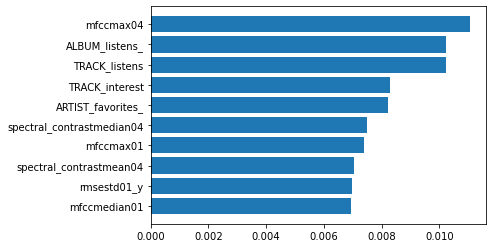

In [50]:
nbr_features = 10

tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(attributes)[sorted_idx])
#plt.title("Random Forest Feature Importances (MDI)")
#plt.savefig("feature_importance.pdf", bbox_inches="tight")
plt.show()

In [56]:
n_estimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
error_rate = list()
accuracy = list()
f1 = list()

for i in n_estimators:
    clf = RandomForestClassifier(n_estimators=i, 
                         criterion='gini', 
                         max_depth=30, 
                         min_samples_split=10, 
                         min_samples_leaf=1, 
                         min_weight_fraction_leaf=0.0, 
                         max_features='auto', 
                         random_state=0,
                         class_weight = 'balanced',
                         verbose=2,
                         n_jobs=-1,
                         oob_score=True)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred, average='weighted'))

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - clf.oob_score_
    error_rate.append(oob_error)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100



building tree 5 of 100
building tree 6 of 100building tree 7 of 100

building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200building tree 2 of 200building tree 3 of 200building tree 4 of 200



building tree 5 of 200building tree 6 of 200

building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.7s


building tree 37 of 200building tree 38 of 200

building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200building tree 55 of 200

building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.5s


building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   43.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 300building tree 2 of 300building tree 3 of 300building tree 4 of 300



building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s


building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.1s


building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400building tree 3 of 400
building tree 4 of 400


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400building tree 14 of 400

building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400building tree 47 of 400

building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.4s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400building tree 190 of 400

building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min



building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 500building tree 2 of 500building tree 3 of 500
building tree 4 of 500


building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.2s


building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.3s


building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 600building tree 2 of 600building tree 3 of 600building tree 4 of 600



building tree 5 of 600
building tree 6 of 600building tree 7 of 600

building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s


building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
building tree 43 of 600
building tree 44 of 600
building tree 45 of 600
building tree 46 of 600
building tree 47 of 600
building tree 48 of 600
building tree 49 of 600
building tree 50 of 600
building tree 51 of 600
building tree 52 of 600
building tree 53 of 600
building tree 54 of 600
building tree 55 of 600
building tree 56 of 600
building tree 57 of 600
building tree 58 of 600
building tree 59 of 600
building tree 60 of 600
building tree 61 of 600
building tree 62 of 600
building tree 63 of 600
building tree 64 of 600
building tree 65 of 600
building tree 66 of 600
building tree 67 of 600
building tree 68 of 600
building tree 69 of 600
building tree 70 of 600
building tree 71 of 600
building tree 72 of 600
building tree 73 of 600
building tree 74 of 600
building tree 75 of 600
building tree 76 of 600
building tree 77 of 600
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.4s


building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 185 of 600
building tree 186 of 600
building tree 187 of 600
building tree 188 of 600
building tree 189 of 600
building tree 190 of 600
building tree 191 of 600
building tree 192 of 600
building tree 193 of 600
building tree 194 of 600
building tree 195 of 600
building tree 196 of 600
building tree 197 of 600


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 600
building tree 362 of 600
building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600
building tree 382 of 600
building tree 383 of 600
building tree 384 of 600
building tree 385 of 600
building tree 386 of 600
building tree 387 of 600
building tree 388 of 600
building tree 389 of 600
building tree 390 of 600
building tree 391 of 600
building tree 392 of 600
building tree 393 of 600
building tree 394 of 600
building tree 395 of 600
building tree 396 of 600
building tree 397 of 600
building tree 398 of 600
building tree 399 of 600
building tree 400 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 700building tree 2 of 700
building tree 3 of 700building tree 4 of 700


building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s


building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70 of 700
building tree 71 of 700
building tree 72 of 700
building tree 73 of 700
building tree 74 of 700
building tree 75 of 700
building tree 76 of 700
building tree 77 of 700
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.2s


building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700
building tree 164 of 700
building tree 165 of 700
building tree 166 of 700
building tree 167 of 700
building tree 168 of 700
building tree 169 of 700
building tree 170 of 700
building tree 171 of 700
building tree 172 of 700
building tree 173 of 700
building tree 174 of 700
building tree 175 of 700
building tree 176 of 700
building tree 177 of 700
building tree 178 of 700
building tree 179 of 700
building tree 180 of 700
building tree 181 of 700
building tree 182 of 700
building tree 183 of 700
building tree 184 of 700
building tree 185 of 700
building tree 186 of 700
building tree 187 of 700
building tree 188 of 700
building tree 189 of 700
building tree 190 of 700
building tree 191 of 700
building tree 192 of 700
building tree 193 of 700
building tree 194 of 700
building tree 195 of 700
building tree 196 of 700
building tree 197 of 700


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 700
building tree 362 of 700
building tree 363 of 700
building tree 364 of 700
building tree 365 of 700
building tree 366 of 700
building tree 367 of 700
building tree 368 of 700
building tree 369 of 700
building tree 370 of 700
building tree 371 of 700
building tree 372 of 700building tree 373 of 700

building tree 374 of 700
building tree 375 of 700
building tree 376 of 700
building tree 377 of 700
building tree 378 of 700
building tree 379 of 700
building tree 380 of 700
building tree 381 of 700
building tree 382 of 700
building tree 383 of 700
building tree 384 of 700
building tree 385 of 700
building tree 386 of 700
building tree 387 of 700
building tree 388 of 700
building tree 389 of 700
building tree 390 of 700
building tree 391 of 700
building tree 392 of 700
building tree 393 of 700
building tree 394 of 700
building tree 395 of 700
building tree 396 of 700
building tree 397 of 700
building tree 398 of 700
building tree 399 of 700
building tree 400 of 700


[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.3min


building tree 644 of 700
building tree 645 of 700
building tree 646 of 700
building tree 647 of 700
building tree 648 of 700
building tree 649 of 700
building tree 650 of 700
building tree 651 of 700
building tree 652 of 700
building tree 653 of 700
building tree 654 of 700
building tree 655 of 700
building tree 656 of 700
building tree 657 of 700
building tree 658 of 700
building tree 659 of 700
building tree 660 of 700
building tree 661 of 700
building tree 662 of 700
building tree 663 of 700
building tree 664 of 700
building tree 665 of 700
building tree 666 of 700
building tree 667 of 700
building tree 668 of 700
building tree 669 of 700
building tree 670 of 700
building tree 671 of 700
building tree 672 of 700
building tree 673 of 700
building tree 674 of 700
building tree 675 of 700
building tree 676 of 700
building tree 677 of 700
building tree 678 of 700
building tree 679 of 700
building tree 680 of 700
building tree 681 of 700
building tree 682 of 700
building tree 683 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 800building tree 2 of 800building tree 3 of 800building tree 4 of 800



building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800building tree 18 of 800

building tree 19 of 800
building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800
building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800
building tree 34 of 800
building tree 35 of 800
building tree 36 of 800


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s


building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800
building tree 43 of 800
building tree 44 of 800
building tree 45 of 800
building tree 46 of 800
building tree 47 of 800
building tree 48 of 800
building tree 49 of 800
building tree 50 of 800
building tree 51 of 800
building tree 52 of 800
building tree 53 of 800
building tree 54 of 800
building tree 55 of 800
building tree 56 of 800
building tree 57 of 800
building tree 58 of 800
building tree 59 of 800
building tree 60 of 800
building tree 61 of 800
building tree 62 of 800
building tree 63 of 800
building tree 64 of 800
building tree 65 of 800
building tree 66 of 800
building tree 67 of 800
building tree 68 of 800
building tree 69 of 800
building tree 70 of 800
building tree 71 of 800
building tree 72 of 800
building tree 73 of 800
building tree 74 of 800
building tree 75 of 800
building tree 76 of 800
building tree 77 of 800
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.6s


building tree 158 of 800
building tree 159 of 800
building tree 160 of 800
building tree 161 of 800
building tree 162 of 800
building tree 163 of 800
building tree 164 of 800
building tree 165 of 800
building tree 166 of 800
building tree 167 of 800
building tree 168 of 800
building tree 169 of 800
building tree 170 of 800
building tree 171 of 800
building tree 172 of 800
building tree 173 of 800
building tree 174 of 800
building tree 175 of 800
building tree 176 of 800
building tree 177 of 800
building tree 178 of 800
building tree 179 of 800
building tree 180 of 800
building tree 181 of 800
building tree 182 of 800
building tree 183 of 800
building tree 184 of 800
building tree 185 of 800
building tree 186 of 800
building tree 187 of 800
building tree 188 of 800
building tree 189 of 800
building tree 190 of 800
building tree 191 of 800
building tree 192 of 800
building tree 193 of 800
building tree 194 of 800
building tree 195 of 800
building tree 196 of 800
building tree 197 of 800


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 800
building tree 362 of 800
building tree 363 of 800
building tree 364 of 800
building tree 365 of 800
building tree 366 of 800
building tree 367 of 800
building tree 368 of 800
building tree 369 of 800
building tree 370 of 800
building tree 371 of 800
building tree 372 of 800
building tree 373 of 800
building tree 374 of 800
building tree 375 of 800
building tree 376 of 800
building tree 377 of 800
building tree 378 of 800
building tree 379 of 800
building tree 380 of 800
building tree 381 of 800
building tree 382 of 800
building tree 383 of 800
building tree 384 of 800
building tree 385 of 800
building tree 386 of 800
building tree 387 of 800
building tree 388 of 800
building tree 389 of 800
building tree 390 of 800
building tree 391 of 800
building tree 392 of 800
building tree 393 of 800
building tree 394 of 800
building tree 395 of 800
building tree 396 of 800
building tree 397 of 800
building tree 398 of 800
building tree 399 of 800
building tree 400 of 800


[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.3min



building tree 645 of 800
building tree 646 of 800
building tree 647 of 800
building tree 648 of 800
building tree 649 of 800
building tree 650 of 800
building tree 651 of 800
building tree 652 of 800
building tree 653 of 800
building tree 654 of 800
building tree 655 of 800
building tree 656 of 800
building tree 657 of 800
building tree 658 of 800
building tree 659 of 800
building tree 660 of 800
building tree 661 of 800
building tree 662 of 800
building tree 663 of 800
building tree 664 of 800
building tree 665 of 800
building tree 666 of 800
building tree 667 of 800
building tree 668 of 800
building tree 669 of 800
building tree 670 of 800
building tree 671 of 800
building tree 672 of 800
building tree 673 of 800
building tree 674 of 800
building tree 675 of 800
building tree 676 of 800
building tree 677 of 800
building tree 678 of 800
building tree 679 of 800
building tree 680 of 800
building tree 681 of 800
building tree 682 of 800
building tree 683 of 800
building tree 684 of 800

[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  2.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 900
building tree 2 of 900
building tree 3 of 900
building tree 4 of 900
building tree 5 of 900
building tree 6 of 900
building tree 7 of 900building tree 8 of 900

building tree 9 of 900
building tree 10 of 900
building tree 11 of 900
building tree 12 of 900
building tree 13 of 900
building tree 14 of 900
building tree 15 of 900
building tree 16 of 900
building tree 17 of 900
building tree 18 of 900
building tree 19 of 900
building tree 20 of 900
building tree 21 of 900
building tree 22 of 900
building tree 23 of 900
building tree 24 of 900
building tree 25 of 900
building tree 26 of 900
building tree 27 of 900
building tree 28 of 900
building tree 29 of 900
building tree 30 of 900
building tree 31 of 900
building tree 32 of 900
building tree 33 of 900
building tree 34 of 900
building tree 35 of 900
building tree 36 of 900


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s


building tree 37 of 900
building tree 38 of 900
building tree 39 of 900
building tree 40 of 900
building tree 41 of 900
building tree 42 of 900
building tree 43 of 900
building tree 44 of 900
building tree 45 of 900
building tree 46 of 900
building tree 47 of 900
building tree 48 of 900
building tree 49 of 900
building tree 50 of 900
building tree 51 of 900
building tree 52 of 900
building tree 53 of 900
building tree 54 of 900
building tree 55 of 900
building tree 56 of 900
building tree 57 of 900
building tree 58 of 900
building tree 59 of 900
building tree 60 of 900
building tree 61 of 900
building tree 62 of 900
building tree 63 of 900
building tree 64 of 900
building tree 65 of 900
building tree 66 of 900
building tree 67 of 900
building tree 68 of 900
building tree 69 of 900
building tree 70 of 900
building tree 71 of 900
building tree 72 of 900
building tree 73 of 900
building tree 74 of 900
building tree 75 of 900
building tree 76 of 900
building tree 77 of 900
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.6s


building tree 158 of 900
building tree 159 of 900
building tree 160 of 900
building tree 161 of 900
building tree 162 of 900
building tree 163 of 900
building tree 164 of 900
building tree 165 of 900
building tree 166 of 900
building tree 167 of 900
building tree 168 of 900
building tree 169 of 900
building tree 170 of 900
building tree 171 of 900
building tree 172 of 900
building tree 173 of 900
building tree 174 of 900
building tree 175 of 900
building tree 176 of 900
building tree 177 of 900
building tree 178 of 900
building tree 179 of 900
building tree 180 of 900
building tree 181 of 900
building tree 182 of 900
building tree 183 of 900
building tree 184 of 900
building tree 185 of 900
building tree 186 of 900
building tree 187 of 900
building tree 188 of 900
building tree 189 of 900
building tree 190 of 900
building tree 191 of 900
building tree 192 of 900
building tree 193 of 900
building tree 194 of 900
building tree 195 of 900
building tree 196 of 900
building tree 197 of 900


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 900
building tree 362 of 900
building tree 363 of 900
building tree 364 of 900
building tree 365 of 900
building tree 366 of 900
building tree 367 of 900
building tree 368 of 900
building tree 369 of 900
building tree 370 of 900
building tree 371 of 900
building tree 372 of 900
building tree 373 of 900
building tree 374 of 900
building tree 375 of 900
building tree 376 of 900
building tree 377 of 900
building tree 378 of 900
building tree 379 of 900
building tree 380 of 900
building tree 381 of 900
building tree 382 of 900
building tree 383 of 900
building tree 384 of 900
building tree 385 of 900
building tree 386 of 900
building tree 387 of 900
building tree 388 of 900
building tree 389 of 900
building tree 390 of 900
building tree 391 of 900
building tree 392 of 900
building tree 393 of 900
building tree 394 of 900
building tree 395 of 900
building tree 396 of 900
building tree 397 of 900
building tree 398 of 900
building tree 399 of 900
building tree 400 of 900


[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.3min


building tree 644 of 900
building tree 645 of 900
building tree 646 of 900
building tree 647 of 900
building tree 648 of 900
building tree 649 of 900
building tree 650 of 900
building tree 651 of 900
building tree 652 of 900
building tree 653 of 900
building tree 654 of 900
building tree 655 of 900
building tree 656 of 900
building tree 657 of 900
building tree 658 of 900
building tree 659 of 900
building tree 660 of 900
building tree 661 of 900
building tree 662 of 900
building tree 663 of 900
building tree 664 of 900
building tree 665 of 900
building tree 666 of 900
building tree 667 of 900
building tree 668 of 900
building tree 669 of 900
building tree 670 of 900
building tree 671 of 900
building tree 672 of 900
building tree 673 of 900
building tree 674 of 900
building tree 675 of 900
building tree 676 of 900
building tree 677 of 900
building tree 678 of 900
building tree 679 of 900
building tree 680 of 900
building tree 681 of 900
building tree 682 of 900
building tree 683 of 900


[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  3.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 900 out of 900 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1000building tree 2 of 1000building tree 3 of 1000building tree 4 of 1000



building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s


building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000building tree 75 of 1000

building tree 76 of 1000


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.1s


building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.3min


building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000building tree 648 of 1000

building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1100building tree 2 of 1100

building tree 3 of 1100building tree 4 of 1100

building tree 5 of 1100
building tree 6 of 1100
building tree 7 of 1100
building tree 8 of 1100
building tree 9 of 1100
building tree 10 of 1100
building tree 11 of 1100
building tree 12 of 1100
building tree 13 of 1100
building tree 14 of 1100
building tree 15 of 1100
building tree 16 of 1100
building tree 17 of 1100
building tree 18 of 1100
building tree 19 of 1100
building tree 20 of 1100
building tree 21 of 1100
building tree 22 of 1100
building tree 23 of 1100
building tree 24 of 1100
building tree 25 of 1100
building tree 26 of 1100
building tree 27 of 1100
building tree 28 of 1100
building tree 29 of 1100
building tree 30 of 1100
building tree 31 of 1100
building tree 32 of 1100
building tree 33 of 1100
building tree 34 of 1100
building tree 35 of 1100
building tree 36 of 1100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.2s


building tree 37 of 1100
building tree 38 of 1100
building tree 39 of 1100
building tree 40 of 1100
building tree 41 of 1100
building tree 42 of 1100
building tree 43 of 1100
building tree 44 of 1100
building tree 45 of 1100
building tree 46 of 1100
building tree 47 of 1100
building tree 48 of 1100
building tree 49 of 1100
building tree 50 of 1100
building tree 51 of 1100
building tree 52 of 1100
building tree 53 of 1100
building tree 54 of 1100
building tree 55 of 1100
building tree 56 of 1100
building tree 57 of 1100
building tree 58 of 1100
building tree 59 of 1100
building tree 60 of 1100
building tree 61 of 1100
building tree 62 of 1100
building tree 63 of 1100
building tree 64 of 1100
building tree 65 of 1100
building tree 66 of 1100
building tree 67 of 1100
building tree 68 of 1100
building tree 69 of 1100
building tree 70 of 1100
building tree 71 of 1100
building tree 72 of 1100
building tree 73 of 1100
building tree 74 of 1100
building tree 75 of 1100
building tree 76 of 1100


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   32.1s


building tree 158 of 1100
building tree 159 of 1100
building tree 160 of 1100
building tree 161 of 1100
building tree 162 of 1100
building tree 163 of 1100
building tree 164 of 1100
building tree 165 of 1100
building tree 166 of 1100
building tree 167 of 1100
building tree 168 of 1100
building tree 169 of 1100
building tree 170 of 1100
building tree 171 of 1100
building tree 172 of 1100
building tree 173 of 1100
building tree 174 of 1100
building tree 175 of 1100
building tree 176 of 1100
building tree 177 of 1100
building tree 178 of 1100
building tree 179 of 1100
building tree 180 of 1100
building tree 181 of 1100
building tree 182 of 1100
building tree 183 of 1100
building tree 184 of 1100
building tree 185 of 1100
building tree 186 of 1100
building tree 187 of 1100
building tree 188 of 1100
building tree 189 of 1100
building tree 190 of 1100
building tree 191 of 1100
building tree 192 of 1100
building tree 193 of 1100
building tree 194 of 1100
building tree 195 of 1100
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min


building tree 361 of 1100
building tree 362 of 1100
building tree 363 of 1100
building tree 364 of 1100
building tree 365 of 1100
building tree 366 of 1100
building tree 367 of 1100
building tree 368 of 1100
building tree 369 of 1100
building tree 370 of 1100
building tree 371 of 1100
building tree 372 of 1100
building tree 373 of 1100
building tree 374 of 1100
building tree 375 of 1100
building tree 376 of 1100
building tree 377 of 1100
building tree 378 of 1100
building tree 379 of 1100
building tree 380 of 1100
building tree 381 of 1100
building tree 382 of 1100
building tree 383 of 1100
building tree 384 of 1100
building tree 385 of 1100
building tree 386 of 1100
building tree 387 of 1100
building tree 388 of 1100
building tree 389 of 1100
building tree 390 of 1100
building tree 391 of 1100
building tree 392 of 1100
building tree 393 of 1100
building tree 394 of 1100
building tree 395 of 1100
building tree 396 of 1100
building tree 397 of 1100
building tree 398 of 1100
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.2min


building tree 644 of 1100
building tree 645 of 1100
building tree 646 of 1100
building tree 647 of 1100
building tree 648 of 1100
building tree 649 of 1100
building tree 650 of 1100
building tree 651 of 1100
building tree 652 of 1100
building tree 653 of 1100
building tree 654 of 1100
building tree 655 of 1100
building tree 656 of 1100
building tree 657 of 1100
building tree 658 of 1100
building tree 659 of 1100
building tree 660 of 1100
building tree 661 of 1100
building tree 662 of 1100
building tree 663 of 1100
building tree 664 of 1100
building tree 665 of 1100
building tree 666 of 1100
building tree 667 of 1100
building tree 668 of 1100
building tree 669 of 1100
building tree 670 of 1100
building tree 671 of 1100
building tree 672 of 1100
building tree 673 of 1100
building tree 674 of 1100
building tree 675 of 1100
building tree 676 of 1100
building tree 677 of 1100
building tree 678 of 1100
building tree 679 of 1100
building tree 680 of 1100
building tree 681 of 1100
building tre

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.5min


building tree 1009 of 1100
building tree 1010 of 1100
building tree 1011 of 1100
building tree 1012 of 1100
building tree 1013 of 1100
building tree 1014 of 1100
building tree 1015 of 1100
building tree 1016 of 1100
building tree 1017 of 1100
building tree 1018 of 1100
building tree 1019 of 1100
building tree 1020 of 1100
building tree 1021 of 1100
building tree 1022 of 1100
building tree 1023 of 1100
building tree 1024 of 1100
building tree 1025 of 1100
building tree 1026 of 1100
building tree 1027 of 1100
building tree 1028 of 1100
building tree 1029 of 1100
building tree 1030 of 1100
building tree 1031 of 1100
building tree 1032 of 1100
building tree 1033 of 1100
building tree 1034 of 1100
building tree 1035 of 1100
building tree 1036 of 1100
building tree 1037 of 1100
building tree 1038 of 1100
building tree 1039 of 1100
building tree 1040 of 1100
building tree 1041 of 1100
building tree 1042 of 1100
building tree 1043 of 1100
building tree 1044 of 1100
building tree 1045 of 1100
b

[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1100 out of 1100 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1200building tree 2 of 1200building tree 3 of 1200building tree 4 of 1200



building tree 5 of 1200
building tree 6 of 1200
building tree 7 of 1200
building tree 8 of 1200
building tree 9 of 1200
building tree 10 of 1200
building tree 11 of 1200
building tree 12 of 1200
building tree 13 of 1200
building tree 14 of 1200
building tree 15 of 1200
building tree 16 of 1200
building tree 17 of 1200
building tree 18 of 1200
building tree 19 of 1200
building tree 20 of 1200
building tree 21 of 1200
building tree 22 of 1200
building tree 23 of 1200
building tree 24 of 1200
building tree 25 of 1200
building tree 26 of 1200
building tree 27 of 1200
building tree 28 of 1200
building tree 29 of 1200
building tree 30 of 1200
building tree 31 of 1200
building tree 32 of 1200
building tree 33 of 1200
building tree 34 of 1200
building tree 35 of 1200
building tree 36 of 1200


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.2s


building tree 37 of 1200
building tree 38 of 1200
building tree 39 of 1200
building tree 40 of 1200
building tree 41 of 1200
building tree 42 of 1200
building tree 43 of 1200
building tree 44 of 1200
building tree 45 of 1200
building tree 46 of 1200
building tree 47 of 1200
building tree 48 of 1200
building tree 49 of 1200
building tree 50 of 1200
building tree 51 of 1200
building tree 52 of 1200
building tree 53 of 1200
building tree 54 of 1200
building tree 55 of 1200
building tree 56 of 1200
building tree 57 of 1200
building tree 58 of 1200
building tree 59 of 1200
building tree 60 of 1200
building tree 61 of 1200
building tree 62 of 1200
building tree 63 of 1200
building tree 64 of 1200
building tree 65 of 1200
building tree 66 of 1200
building tree 67 of 1200
building tree 68 of 1200
building tree 69 of 1200
building tree 70 of 1200
building tree 71 of 1200
building tree 72 of 1200
building tree 73 of 1200
building tree 74 of 1200
building tree 75 of 1200
building tree 76 of 1200


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   32.1s


building tree 158 of 1200
building tree 159 of 1200
building tree 160 of 1200
building tree 161 of 1200
building tree 162 of 1200
building tree 163 of 1200
building tree 164 of 1200
building tree 165 of 1200
building tree 166 of 1200
building tree 167 of 1200
building tree 168 of 1200
building tree 169 of 1200
building tree 170 of 1200
building tree 171 of 1200
building tree 172 of 1200
building tree 173 of 1200
building tree 174 of 1200
building tree 175 of 1200
building tree 176 of 1200
building tree 177 of 1200
building tree 178 of 1200
building tree 179 of 1200
building tree 180 of 1200
building tree 181 of 1200
building tree 182 of 1200
building tree 183 of 1200
building tree 184 of 1200
building tree 185 of 1200
building tree 186 of 1200
building tree 187 of 1200
building tree 188 of 1200
building tree 189 of 1200
building tree 190 of 1200
building tree 191 of 1200
building tree 192 of 1200
building tree 193 of 1200
building tree 194 of 1200
building tree 195 of 1200
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min


building tree 361 of 1200
building tree 362 of 1200
building tree 363 of 1200
building tree 364 of 1200
building tree 365 of 1200
building tree 366 of 1200
building tree 367 of 1200
building tree 368 of 1200
building tree 369 of 1200
building tree 370 of 1200
building tree 371 of 1200
building tree 372 of 1200
building tree 373 of 1200
building tree 374 of 1200
building tree 375 of 1200
building tree 376 of 1200
building tree 377 of 1200
building tree 378 of 1200
building tree 379 of 1200
building tree 380 of 1200
building tree 381 of 1200
building tree 382 of 1200
building tree 383 of 1200
building tree 384 of 1200
building tree 385 of 1200
building tree 386 of 1200
building tree 387 of 1200
building tree 388 of 1200
building tree 389 of 1200
building tree 390 of 1200
building tree 391 of 1200
building tree 392 of 1200
building tree 393 of 1200
building tree 394 of 1200
building tree 395 of 1200
building tree 396 of 1200
building tree 397 of 1200
building tree 398 of 1200
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.2min



building tree 645 of 1200
building tree 646 of 1200
building tree 647 of 1200
building tree 648 of 1200
building tree 649 of 1200
building tree 650 of 1200
building tree 651 of 1200
building tree 652 of 1200
building tree 653 of 1200
building tree 654 of 1200
building tree 655 of 1200
building tree 656 of 1200
building tree 657 of 1200
building tree 658 of 1200
building tree 659 of 1200
building tree 660 of 1200
building tree 661 of 1200
building tree 662 of 1200
building tree 663 of 1200
building tree 664 of 1200
building tree 665 of 1200
building tree 666 of 1200
building tree 667 of 1200
building tree 668 of 1200
building tree 669 of 1200
building tree 670 of 1200
building tree 671 of 1200
building tree 672 of 1200
building tree 673 of 1200
building tree 674 of 1200
building tree 675 of 1200
building tree 676 of 1200
building tree 677 of 1200
building tree 678 of 1200
building tree 679 of 1200
building tree 680 of 1200
building tree 681 of 1200
building tree 682 of 1200
building tr

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.5min


building tree 1009 of 1200
building tree 1010 of 1200
building tree 1011 of 1200
building tree 1012 of 1200
building tree 1013 of 1200
building tree 1014 of 1200
building tree 1015 of 1200
building tree 1016 of 1200
building tree 1017 of 1200
building tree 1018 of 1200
building tree 1019 of 1200
building tree 1020 of 1200
building tree 1021 of 1200
building tree 1022 of 1200
building tree 1023 of 1200
building tree 1024 of 1200
building tree 1025 of 1200
building tree 1026 of 1200
building tree 1027 of 1200
building tree 1028 of 1200
building tree 1029 of 1200
building tree 1030 of 1200
building tree 1031 of 1200
building tree 1032 of 1200
building tree 1033 of 1200
building tree 1034 of 1200
building tree 1035 of 1200
building tree 1036 of 1200
building tree 1037 of 1200
building tree 1038 of 1200
building tree 1039 of 1200
building tree 1040 of 1200
building tree 1041 of 1200
building tree 1042 of 1200
building tree 1043 of 1200
building tree 1044 of 1200
building tree 1045 of 1200
b

[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  4.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1200 out of 1200 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1300building tree 2 of 1300building tree 3 of 1300
building tree 4 of 1300


building tree 5 of 1300building tree 6 of 1300

building tree 7 of 1300
building tree 8 of 1300
building tree 9 of 1300
building tree 10 of 1300
building tree 11 of 1300
building tree 12 of 1300
building tree 13 of 1300
building tree 14 of 1300
building tree 15 of 1300
building tree 16 of 1300
building tree 17 of 1300
building tree 18 of 1300
building tree 19 of 1300
building tree 20 of 1300
building tree 21 of 1300
building tree 22 of 1300
building tree 23 of 1300
building tree 24 of 1300
building tree 25 of 1300
building tree 26 of 1300
building tree 27 of 1300
building tree 28 of 1300
building tree 29 of 1300
building tree 30 of 1300
building tree 31 of 1300
building tree 32 of 1300
building tree 33 of 1300
building tree 34 of 1300
building tree 35 of 1300building tree 36 of 1300



[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s


building tree 37 of 1300
building tree 38 of 1300
building tree 39 of 1300
building tree 40 of 1300
building tree 41 of 1300
building tree 42 of 1300
building tree 43 of 1300
building tree 44 of 1300
building tree 45 of 1300
building tree 46 of 1300
building tree 47 of 1300
building tree 48 of 1300
building tree 49 of 1300
building tree 50 of 1300
building tree 51 of 1300
building tree 52 of 1300
building tree 53 of 1300
building tree 54 of 1300
building tree 55 of 1300
building tree 56 of 1300
building tree 57 of 1300
building tree 58 of 1300
building tree 59 of 1300
building tree 60 of 1300
building tree 61 of 1300
building tree 62 of 1300
building tree 63 of 1300
building tree 64 of 1300
building tree 65 of 1300
building tree 66 of 1300
building tree 67 of 1300
building tree 68 of 1300
building tree 69 of 1300
building tree 70 of 1300
building tree 71 of 1300building tree 72 of 1300

building tree 73 of 1300
building tree 74 of 1300
building tree 75 of 1300
building tree 76 of 1300


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   32.6s


building tree 158 of 1300
building tree 159 of 1300
building tree 160 of 1300
building tree 161 of 1300
building tree 162 of 1300
building tree 163 of 1300
building tree 164 of 1300
building tree 165 of 1300
building tree 166 of 1300
building tree 167 of 1300
building tree 168 of 1300
building tree 169 of 1300
building tree 170 of 1300
building tree 171 of 1300
building tree 172 of 1300
building tree 173 of 1300
building tree 174 of 1300
building tree 175 of 1300
building tree 176 of 1300
building tree 177 of 1300
building tree 178 of 1300
building tree 179 of 1300
building tree 180 of 1300
building tree 181 of 1300
building tree 182 of 1300
building tree 183 of 1300
building tree 184 of 1300
building tree 185 of 1300
building tree 186 of 1300
building tree 187 of 1300
building tree 188 of 1300
building tree 189 of 1300
building tree 190 of 1300
building tree 191 of 1300
building tree 192 of 1300
building tree 193 of 1300
building tree 194 of 1300
building tree 195 of 1300
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min


building tree 361 of 1300
building tree 362 of 1300
building tree 363 of 1300
building tree 364 of 1300
building tree 365 of 1300
building tree 366 of 1300
building tree 367 of 1300
building tree 368 of 1300
building tree 369 of 1300
building tree 370 of 1300
building tree 371 of 1300
building tree 372 of 1300
building tree 373 of 1300
building tree 374 of 1300
building tree 375 of 1300
building tree 376 of 1300
building tree 377 of 1300
building tree 378 of 1300
building tree 379 of 1300
building tree 380 of 1300
building tree 381 of 1300
building tree 382 of 1300
building tree 383 of 1300
building tree 384 of 1300
building tree 385 of 1300
building tree 386 of 1300
building tree 387 of 1300
building tree 388 of 1300
building tree 389 of 1300
building tree 390 of 1300
building tree 391 of 1300
building tree 392 of 1300
building tree 393 of 1300
building tree 394 of 1300
building tree 395 of 1300
building tree 396 of 1300
building tree 397 of 1300
building tree 398 of 1300
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.2min


building tree 644 of 1300
building tree 645 of 1300
building tree 646 of 1300
building tree 647 of 1300
building tree 648 of 1300
building tree 649 of 1300
building tree 650 of 1300
building tree 651 of 1300
building tree 652 of 1300
building tree 653 of 1300
building tree 654 of 1300
building tree 655 of 1300
building tree 656 of 1300
building tree 657 of 1300
building tree 658 of 1300
building tree 659 of 1300
building tree 660 of 1300
building tree 661 of 1300
building tree 662 of 1300
building tree 663 of 1300
building tree 664 of 1300
building tree 665 of 1300
building tree 666 of 1300
building tree 667 of 1300
building tree 668 of 1300
building tree 669 of 1300
building tree 670 of 1300
building tree 671 of 1300
building tree 672 of 1300
building tree 673 of 1300
building tree 674 of 1300
building tree 675 of 1300
building tree 676 of 1300
building tree 677 of 1300
building tree 678 of 1300
building tree 679 of 1300
building tree 680 of 1300
building tree 681 of 1300
building tre

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.5min



building tree 1010 of 1300
building tree 1011 of 1300
building tree 1012 of 1300
building tree 1013 of 1300
building tree 1014 of 1300
building tree 1015 of 1300
building tree 1016 of 1300
building tree 1017 of 1300
building tree 1018 of 1300
building tree 1019 of 1300
building tree 1020 of 1300
building tree 1021 of 1300
building tree 1022 of 1300
building tree 1023 of 1300
building tree 1024 of 1300
building tree 1025 of 1300
building tree 1026 of 1300
building tree 1027 of 1300
building tree 1028 of 1300
building tree 1029 of 1300
building tree 1030 of 1300
building tree 1031 of 1300
building tree 1032 of 1300
building tree 1033 of 1300
building tree 1034 of 1300
building tree 1035 of 1300
building tree 1036 of 1300
building tree 1037 of 1300
building tree 1038 of 1300
building tree 1039 of 1300
building tree 1040 of 1300
building tree 1041 of 1300
building tree 1042 of 1300
building tree 1043 of 1300
building tree 1044 of 1300
building tree 1045 of 1300
building tree 1046 of 1300


[Parallel(n_jobs=-1)]: Done 1300 out of 1300 | elapsed:  4.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1300 out of 1300 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1400building tree 2 of 1400building tree 3 of 1400building tree 4 of 1400



building tree 5 of 1400
building tree 6 of 1400
building tree 7 of 1400
building tree 8 of 1400
building tree 9 of 1400
building tree 10 of 1400
building tree 11 of 1400
building tree 12 of 1400
building tree 13 of 1400
building tree 14 of 1400
building tree 15 of 1400
building tree 16 of 1400
building tree 17 of 1400
building tree 18 of 1400
building tree 19 of 1400
building tree 20 of 1400
building tree 21 of 1400
building tree 22 of 1400
building tree 23 of 1400
building tree 24 of 1400
building tree 25 of 1400
building tree 26 of 1400
building tree 27 of 1400
building tree 28 of 1400
building tree 29 of 1400
building tree 30 of 1400
building tree 31 of 1400
building tree 32 of 1400
building tree 33 of 1400
building tree 34 of 1400
building tree 35 of 1400
building tree 36 of 1400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s


building tree 37 of 1400
building tree 38 of 1400
building tree 39 of 1400
building tree 40 of 1400
building tree 41 of 1400
building tree 42 of 1400
building tree 43 of 1400
building tree 44 of 1400
building tree 45 of 1400
building tree 46 of 1400
building tree 47 of 1400
building tree 48 of 1400
building tree 49 of 1400
building tree 50 of 1400
building tree 51 of 1400
building tree 52 of 1400
building tree 53 of 1400
building tree 54 of 1400
building tree 55 of 1400
building tree 56 of 1400
building tree 57 of 1400
building tree 58 of 1400
building tree 59 of 1400
building tree 60 of 1400
building tree 61 of 1400
building tree 62 of 1400
building tree 63 of 1400
building tree 64 of 1400
building tree 65 of 1400
building tree 66 of 1400
building tree 67 of 1400
building tree 68 of 1400
building tree 69 of 1400
building tree 70 of 1400
building tree 71 of 1400
building tree 72 of 1400
building tree 73 of 1400
building tree 74 of 1400
building tree 75 of 1400
building tree 76 of 1400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   32.8s


building tree 158 of 1400
building tree 159 of 1400
building tree 160 of 1400
building tree 161 of 1400
building tree 162 of 1400
building tree 163 of 1400
building tree 164 of 1400
building tree 165 of 1400
building tree 166 of 1400
building tree 167 of 1400
building tree 168 of 1400
building tree 169 of 1400
building tree 170 of 1400
building tree 171 of 1400
building tree 172 of 1400
building tree 173 of 1400
building tree 174 of 1400
building tree 175 of 1400
building tree 176 of 1400
building tree 177 of 1400
building tree 178 of 1400
building tree 179 of 1400
building tree 180 of 1400
building tree 181 of 1400
building tree 182 of 1400
building tree 183 of 1400
building tree 184 of 1400
building tree 185 of 1400
building tree 186 of 1400
building tree 187 of 1400
building tree 188 of 1400
building tree 189 of 1400
building tree 190 of 1400
building tree 191 of 1400
building tree 192 of 1400
building tree 193 of 1400
building tree 194 of 1400
building tree 195 of 1400
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min



building tree 362 of 1400
building tree 363 of 1400
building tree 364 of 1400
building tree 365 of 1400
building tree 366 of 1400
building tree 367 of 1400
building tree 368 of 1400
building tree 369 of 1400
building tree 370 of 1400
building tree 371 of 1400
building tree 372 of 1400
building tree 373 of 1400
building tree 374 of 1400
building tree 375 of 1400
building tree 376 of 1400
building tree 377 of 1400
building tree 378 of 1400
building tree 379 of 1400
building tree 380 of 1400
building tree 381 of 1400
building tree 382 of 1400
building tree 383 of 1400
building tree 384 of 1400
building tree 385 of 1400
building tree 386 of 1400
building tree 387 of 1400
building tree 388 of 1400
building tree 389 of 1400
building tree 390 of 1400
building tree 391 of 1400
building tree 392 of 1400
building tree 393 of 1400
building tree 394 of 1400
building tree 395 of 1400
building tree 396 of 1400
building tree 397 of 1400
building tree 398 of 1400
building tree 399 of 1400
building tr

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.3min


building tree 644 of 1400
building tree 645 of 1400
building tree 646 of 1400
building tree 647 of 1400
building tree 648 of 1400
building tree 649 of 1400
building tree 650 of 1400
building tree 651 of 1400
building tree 652 of 1400
building tree 653 of 1400
building tree 654 of 1400
building tree 655 of 1400
building tree 656 of 1400
building tree 657 of 1400
building tree 658 of 1400
building tree 659 of 1400
building tree 660 of 1400
building tree 661 of 1400
building tree 662 of 1400
building tree 663 of 1400
building tree 664 of 1400
building tree 665 of 1400
building tree 666 of 1400
building tree 667 of 1400
building tree 668 of 1400
building tree 669 of 1400
building tree 670 of 1400
building tree 671 of 1400
building tree 672 of 1400
building tree 673 of 1400
building tree 674 of 1400
building tree 675 of 1400
building tree 676 of 1400
building tree 677 of 1400
building tree 678 of 1400
building tree 679 of 1400
building tree 680 of 1400
building tree 681 of 1400
building tre

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.7min


building tree 1009 of 1400
building tree 1010 of 1400
building tree 1011 of 1400
building tree 1012 of 1400
building tree 1013 of 1400
building tree 1014 of 1400
building tree 1015 of 1400
building tree 1016 of 1400
building tree 1017 of 1400
building tree 1018 of 1400
building tree 1019 of 1400
building tree 1020 of 1400
building tree 1021 of 1400
building tree 1022 of 1400
building tree 1023 of 1400
building tree 1024 of 1400
building tree 1025 of 1400
building tree 1026 of 1400
building tree 1027 of 1400
building tree 1028 of 1400
building tree 1029 of 1400
building tree 1030 of 1400
building tree 1031 of 1400
building tree 1032 of 1400
building tree 1033 of 1400
building tree 1034 of 1400
building tree 1035 of 1400
building tree 1036 of 1400
building tree 1037 of 1400
building tree 1038 of 1400
building tree 1039 of 1400
building tree 1040 of 1400
building tree 1041 of 1400
building tree 1042 of 1400
building tree 1043 of 1400
building tree 1044 of 1400
building tree 1045 of 1400
b

[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:  5.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 1400 out of 1400 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1500building tree 2 of 1500building tree 3 of 1500


building tree 4 of 1500
building tree 5 of 1500
building tree 6 of 1500
building tree 7 of 1500
building tree 8 of 1500
building tree 9 of 1500
building tree 10 of 1500
building tree 11 of 1500
building tree 12 of 1500
building tree 13 of 1500
building tree 14 of 1500
building tree 15 of 1500
building tree 16 of 1500
building tree 17 of 1500
building tree 18 of 1500
building tree 19 of 1500
building tree 20 of 1500
building tree 21 of 1500
building tree 22 of 1500
building tree 23 of 1500
building tree 24 of 1500
building tree 25 of 1500
building tree 26 of 1500
building tree 27 of 1500
building tree 28 of 1500
building tree 29 of 1500
building tree 30 of 1500
building tree 31 of 1500
building tree 32 of 1500
building tree 33 of 1500
building tree 34 of 1500
building tree 35 of 1500
building tree 36 of 1500


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s


building tree 37 of 1500
building tree 38 of 1500
building tree 39 of 1500
building tree 40 of 1500
building tree 41 of 1500
building tree 42 of 1500
building tree 43 of 1500
building tree 44 of 1500
building tree 45 of 1500
building tree 46 of 1500
building tree 47 of 1500
building tree 48 of 1500
building tree 49 of 1500
building tree 50 of 1500
building tree 51 of 1500
building tree 52 of 1500
building tree 53 of 1500
building tree 54 of 1500
building tree 55 of 1500
building tree 56 of 1500
building tree 57 of 1500
building tree 58 of 1500
building tree 59 of 1500
building tree 60 of 1500
building tree 61 of 1500
building tree 62 of 1500
building tree 63 of 1500
building tree 64 of 1500
building tree 65 of 1500
building tree 66 of 1500
building tree 67 of 1500
building tree 68 of 1500
building tree 69 of 1500
building tree 70 of 1500
building tree 71 of 1500
building tree 72 of 1500
building tree 73 of 1500
building tree 74 of 1500
building tree 75 of 1500
building tree 76 of 1500


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.6s


building tree 158 of 1500
building tree 159 of 1500
building tree 160 of 1500
building tree 161 of 1500
building tree 162 of 1500
building tree 163 of 1500
building tree 164 of 1500
building tree 165 of 1500
building tree 166 of 1500
building tree 167 of 1500
building tree 168 of 1500
building tree 169 of 1500
building tree 170 of 1500
building tree 171 of 1500
building tree 172 of 1500
building tree 173 of 1500
building tree 174 of 1500
building tree 175 of 1500
building tree 176 of 1500
building tree 177 of 1500
building tree 178 of 1500
building tree 179 of 1500
building tree 180 of 1500
building tree 181 of 1500
building tree 182 of 1500
building tree 183 of 1500
building tree 184 of 1500
building tree 185 of 1500
building tree 186 of 1500
building tree 187 of 1500
building tree 188 of 1500
building tree 189 of 1500
building tree 190 of 1500
building tree 191 of 1500
building tree 192 of 1500
building tree 193 of 1500
building tree 194 of 1500
building tree 195 of 1500
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 1500
building tree 362 of 1500
building tree 363 of 1500
building tree 364 of 1500
building tree 365 of 1500
building tree 366 of 1500
building tree 367 of 1500
building tree 368 of 1500
building tree 369 of 1500
building tree 370 of 1500
building tree 371 of 1500
building tree 372 of 1500
building tree 373 of 1500
building tree 374 of 1500
building tree 375 of 1500
building tree 376 of 1500
building tree 377 of 1500
building tree 378 of 1500
building tree 379 of 1500
building tree 380 of 1500
building tree 381 of 1500
building tree 382 of 1500
building tree 383 of 1500
building tree 384 of 1500
building tree 385 of 1500
building tree 386 of 1500
building tree 387 of 1500
building tree 388 of 1500
building tree 389 of 1500
building tree 390 of 1500
building tree 391 of 1500
building tree 392 of 1500
building tree 393 of 1500
building tree 394 of 1500
building tree 395 of 1500
building tree 396 of 1500
building tree 397 of 1500
building tree 398 of 1500
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.3min


building tree 644 of 1500
building tree 645 of 1500
building tree 646 of 1500
building tree 647 of 1500
building tree 648 of 1500
building tree 649 of 1500
building tree 650 of 1500
building tree 651 of 1500
building tree 652 of 1500
building tree 653 of 1500
building tree 654 of 1500
building tree 655 of 1500
building tree 656 of 1500
building tree 657 of 1500
building tree 658 of 1500
building tree 659 of 1500
building tree 660 of 1500
building tree 661 of 1500
building tree 662 of 1500
building tree 663 of 1500
building tree 664 of 1500
building tree 665 of 1500
building tree 666 of 1500
building tree 667 of 1500
building tree 668 of 1500
building tree 669 of 1500
building tree 670 of 1500
building tree 671 of 1500
building tree 672 of 1500
building tree 673 of 1500
building tree 674 of 1500
building tree 675 of 1500
building tree 676 of 1500
building tree 677 of 1500
building tree 678 of 1500
building tree 679 of 1500
building tree 680 of 1500
building tree 681 of 1500
building tre

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.6min


building tree 1009 of 1500
building tree 1010 of 1500
building tree 1011 of 1500
building tree 1012 of 1500
building tree 1013 of 1500
building tree 1014 of 1500
building tree 1015 of 1500
building tree 1016 of 1500
building tree 1017 of 1500
building tree 1018 of 1500
building tree 1019 of 1500
building tree 1020 of 1500
building tree 1021 of 1500
building tree 1022 of 1500
building tree 1023 of 1500
building tree 1024 of 1500
building tree 1025 of 1500
building tree 1026 of 1500
building tree 1027 of 1500
building tree 1028 of 1500
building tree 1029 of 1500
building tree 1030 of 1500
building tree 1031 of 1500
building tree 1032 of 1500
building tree 1033 of 1500
building tree 1034 of 1500
building tree 1035 of 1500
building tree 1036 of 1500
building tree 1037 of 1500
building tree 1038 of 1500
building tree 1039 of 1500
building tree 1040 of 1500
building tree 1041 of 1500
building tree 1042 of 1500
building tree 1043 of 1500
building tree 1044 of 1500
building tree 1045 of 1500
b

[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.2min


building tree 1454 of 1500
building tree 1455 of 1500
building tree 1456 of 1500
building tree 1457 of 1500
building tree 1458 of 1500
building tree 1459 of 1500
building tree 1460 of 1500
building tree 1461 of 1500
building tree 1462 of 1500
building tree 1463 of 1500
building tree 1464 of 1500
building tree 1465 of 1500
building tree 1466 of 1500
building tree 1467 of 1500
building tree 1468 of 1500
building tree 1469 of 1500
building tree 1470 of 1500
building tree 1471 of 1500
building tree 1472 of 1500
building tree 1473 of 1500
building tree 1474 of 1500
building tree 1475 of 1500
building tree 1476 of 1500
building tree 1477 of 1500
building tree 1478 of 1500
building tree 1479 of 1500
building tree 1480 of 1500
building tree 1481 of 1500
building tree 1482 of 1500
building tree 1483 of 1500
building tree 1484 of 1500
building tree 1485 of 1500
building tree 1486 of 1500
building tree 1487 of 1500
building tree 1488 of 1500
building tree 1489 of 1500
building tree 1490 of 1500
b

[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  5.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1600building tree 2 of 1600building tree 3 of 1600building tree 4 of 1600



building tree 5 of 1600
building tree 6 of 1600
building tree 7 of 1600
building tree 8 of 1600
building tree 9 of 1600
building tree 10 of 1600
building tree 11 of 1600
building tree 12 of 1600
building tree 13 of 1600
building tree 14 of 1600
building tree 15 of 1600
building tree 16 of 1600
building tree 17 of 1600
building tree 18 of 1600
building tree 19 of 1600
building tree 20 of 1600
building tree 21 of 1600
building tree 22 of 1600
building tree 23 of 1600
building tree 24 of 1600
building tree 25 of 1600
building tree 26 of 1600
building tree 27 of 1600
building tree 28 of 1600
building tree 29 of 1600
building tree 30 of 1600
building tree 31 of 1600
building tree 32 of 1600
building tree 33 of 1600
building tree 34 of 1600
building tree 35 of 1600
building tree 36 of 1600


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s


building tree 37 of 1600
building tree 38 of 1600
building tree 39 of 1600
building tree 40 of 1600
building tree 41 of 1600
building tree 42 of 1600
building tree 43 of 1600
building tree 44 of 1600
building tree 45 of 1600
building tree 46 of 1600
building tree 47 of 1600
building tree 48 of 1600
building tree 49 of 1600
building tree 50 of 1600
building tree 51 of 1600
building tree 52 of 1600
building tree 53 of 1600
building tree 54 of 1600
building tree 55 of 1600
building tree 56 of 1600
building tree 57 of 1600
building tree 58 of 1600
building tree 59 of 1600
building tree 60 of 1600
building tree 61 of 1600
building tree 62 of 1600
building tree 63 of 1600building tree 64 of 1600

building tree 65 of 1600
building tree 66 of 1600
building tree 67 of 1600
building tree 68 of 1600
building tree 69 of 1600
building tree 70 of 1600
building tree 71 of 1600
building tree 72 of 1600
building tree 73 of 1600
building tree 74 of 1600
building tree 75 of 1600
building tree 76 of 1600


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.0s



building tree 159 of 1600
building tree 160 of 1600
building tree 161 of 1600
building tree 162 of 1600
building tree 163 of 1600
building tree 164 of 1600
building tree 165 of 1600
building tree 166 of 1600
building tree 167 of 1600
building tree 168 of 1600
building tree 169 of 1600
building tree 170 of 1600
building tree 171 of 1600
building tree 172 of 1600
building tree 173 of 1600
building tree 174 of 1600
building tree 175 of 1600
building tree 176 of 1600
building tree 177 of 1600
building tree 178 of 1600
building tree 179 of 1600
building tree 180 of 1600
building tree 181 of 1600
building tree 182 of 1600
building tree 183 of 1600
building tree 184 of 1600
building tree 185 of 1600
building tree 186 of 1600
building tree 187 of 1600
building tree 188 of 1600
building tree 189 of 1600
building tree 190 of 1600
building tree 191 of 1600
building tree 192 of 1600
building tree 193 of 1600
building tree 194 of 1600
building tree 195 of 1600
building tree 196 of 1600
building tr

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 1600
building tree 362 of 1600
building tree 363 of 1600
building tree 364 of 1600
building tree 365 of 1600
building tree 366 of 1600
building tree 367 of 1600
building tree 368 of 1600
building tree 369 of 1600
building tree 370 of 1600
building tree 371 of 1600
building tree 372 of 1600
building tree 373 of 1600
building tree 374 of 1600
building tree 375 of 1600
building tree 376 of 1600
building tree 377 of 1600
building tree 378 of 1600
building tree 379 of 1600
building tree 380 of 1600
building tree 381 of 1600
building tree 382 of 1600
building tree 383 of 1600
building tree 384 of 1600
building tree 385 of 1600
building tree 386 of 1600
building tree 387 of 1600
building tree 388 of 1600
building tree 389 of 1600
building tree 390 of 1600
building tree 391 of 1600
building tree 392 of 1600
building tree 393 of 1600
building tree 394 of 1600
building tree 395 of 1600
building tree 396 of 1600
building tree 397 of 1600
building tree 398 of 1600
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.3min


building tree 644 of 1600
building tree 645 of 1600
building tree 646 of 1600
building tree 647 of 1600
building tree 648 of 1600
building tree 649 of 1600
building tree 650 of 1600
building tree 651 of 1600
building tree 652 of 1600
building tree 653 of 1600
building tree 654 of 1600
building tree 655 of 1600
building tree 656 of 1600
building tree 657 of 1600
building tree 658 of 1600
building tree 659 of 1600
building tree 660 of 1600
building tree 661 of 1600
building tree 662 of 1600
building tree 663 of 1600
building tree 664 of 1600
building tree 665 of 1600
building tree 666 of 1600
building tree 667 of 1600
building tree 668 of 1600
building tree 669 of 1600
building tree 670 of 1600
building tree 671 of 1600
building tree 672 of 1600
building tree 673 of 1600
building tree 674 of 1600
building tree 675 of 1600
building tree 676 of 1600
building tree 677 of 1600
building tree 678 of 1600
building tree 679 of 1600
building tree 680 of 1600
building tree 681 of 1600
building tre

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.6min


building tree 1009 of 1600
building tree 1010 of 1600
building tree 1011 of 1600
building tree 1012 of 1600
building tree 1013 of 1600
building tree 1014 of 1600
building tree 1015 of 1600
building tree 1016 of 1600
building tree 1017 of 1600
building tree 1018 of 1600
building tree 1019 of 1600
building tree 1020 of 1600
building tree 1021 of 1600
building tree 1022 of 1600
building tree 1023 of 1600
building tree 1024 of 1600
building tree 1025 of 1600
building tree 1026 of 1600
building tree 1027 of 1600
building tree 1028 of 1600
building tree 1029 of 1600
building tree 1030 of 1600
building tree 1031 of 1600
building tree 1032 of 1600
building tree 1033 of 1600
building tree 1034 of 1600
building tree 1035 of 1600
building tree 1036 of 1600
building tree 1037 of 1600
building tree 1038 of 1600
building tree 1039 of 1600
building tree 1040 of 1600
building tree 1041 of 1600
building tree 1042 of 1600
building tree 1043 of 1600
building tree 1044 of 1600
building tree 1045 of 1600
b

[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.2min


building tree 1454 of 1600
building tree 1455 of 1600
building tree 1456 of 1600
building tree 1457 of 1600
building tree 1458 of 1600
building tree 1459 of 1600
building tree 1460 of 1600
building tree 1461 of 1600
building tree 1462 of 1600
building tree 1463 of 1600
building tree 1464 of 1600
building tree 1465 of 1600
building tree 1466 of 1600
building tree 1467 of 1600
building tree 1468 of 1600
building tree 1469 of 1600
building tree 1470 of 1600
building tree 1471 of 1600
building tree 1472 of 1600
building tree 1473 of 1600
building tree 1474 of 1600
building tree 1475 of 1600
building tree 1476 of 1600
building tree 1477 of 1600
building tree 1478 of 1600
building tree 1479 of 1600
building tree 1480 of 1600
building tree 1481 of 1600
building tree 1482 of 1600
building tree 1483 of 1600
building tree 1484 of 1600
building tree 1485 of 1600
building tree 1486 of 1600
building tree 1487 of 1600
building tree 1488 of 1600
building tree 1489 of 1600
building tree 1490 of 1600
b

[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  5.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1700building tree 2 of 1700building tree 3 of 1700
building tree 4 of 1700


building tree 5 of 1700
building tree 6 of 1700
building tree 7 of 1700
building tree 8 of 1700
building tree 9 of 1700
building tree 10 of 1700
building tree 11 of 1700
building tree 12 of 1700
building tree 13 of 1700
building tree 14 of 1700
building tree 15 of 1700
building tree 16 of 1700
building tree 17 of 1700
building tree 18 of 1700
building tree 19 of 1700
building tree 20 of 1700
building tree 21 of 1700
building tree 22 of 1700
building tree 23 of 1700
building tree 24 of 1700
building tree 25 of 1700
building tree 26 of 1700
building tree 27 of 1700
building tree 28 of 1700
building tree 29 of 1700
building tree 30 of 1700
building tree 31 of 1700
building tree 32 of 1700
building tree 33 of 1700
building tree 34 of 1700
building tree 35 of 1700
building tree 36 of 1700


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s


building tree 37 of 1700
building tree 38 of 1700
building tree 39 of 1700
building tree 40 of 1700
building tree 41 of 1700
building tree 42 of 1700
building tree 43 of 1700
building tree 44 of 1700
building tree 45 of 1700
building tree 46 of 1700
building tree 47 of 1700
building tree 48 of 1700
building tree 49 of 1700
building tree 50 of 1700
building tree 51 of 1700
building tree 52 of 1700
building tree 53 of 1700
building tree 54 of 1700
building tree 55 of 1700
building tree 56 of 1700
building tree 57 of 1700
building tree 58 of 1700
building tree 59 of 1700
building tree 60 of 1700
building tree 61 of 1700
building tree 62 of 1700
building tree 63 of 1700
building tree 64 of 1700
building tree 65 of 1700
building tree 66 of 1700
building tree 67 of 1700
building tree 68 of 1700
building tree 69 of 1700
building tree 70 of 1700
building tree 71 of 1700
building tree 72 of 1700
building tree 73 of 1700
building tree 74 of 1700
building tree 75 of 1700
building tree 76 of 1700


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.9s


building tree 158 of 1700
building tree 159 of 1700
building tree 160 of 1700
building tree 161 of 1700
building tree 162 of 1700
building tree 163 of 1700
building tree 164 of 1700
building tree 165 of 1700
building tree 166 of 1700
building tree 167 of 1700
building tree 168 of 1700
building tree 169 of 1700
building tree 170 of 1700
building tree 171 of 1700
building tree 172 of 1700
building tree 173 of 1700
building tree 174 of 1700
building tree 175 of 1700
building tree 176 of 1700
building tree 177 of 1700
building tree 178 of 1700
building tree 179 of 1700
building tree 180 of 1700
building tree 181 of 1700
building tree 182 of 1700
building tree 183 of 1700
building tree 184 of 1700
building tree 185 of 1700
building tree 186 of 1700
building tree 187 of 1700
building tree 188 of 1700
building tree 189 of 1700
building tree 190 of 1700
building tree 191 of 1700
building tree 192 of 1700
building tree 193 of 1700
building tree 194 of 1700
building tree 195 of 1700
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 1700
building tree 362 of 1700
building tree 363 of 1700
building tree 364 of 1700
building tree 365 of 1700
building tree 366 of 1700
building tree 367 of 1700
building tree 368 of 1700
building tree 369 of 1700
building tree 370 of 1700
building tree 371 of 1700
building tree 372 of 1700
building tree 373 of 1700
building tree 374 of 1700
building tree 375 of 1700
building tree 376 of 1700
building tree 377 of 1700
building tree 378 of 1700
building tree 379 of 1700
building tree 380 of 1700
building tree 381 of 1700
building tree 382 of 1700
building tree 383 of 1700
building tree 384 of 1700
building tree 385 of 1700
building tree 386 of 1700
building tree 387 of 1700
building tree 388 of 1700
building tree 389 of 1700
building tree 390 of 1700
building tree 391 of 1700
building tree 392 of 1700
building tree 393 of 1700
building tree 394 of 1700
building tree 395 of 1700
building tree 396 of 1700
building tree 397 of 1700
building tree 398 of 1700
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.3min


building tree 644 of 1700
building tree 645 of 1700
building tree 646 of 1700
building tree 647 of 1700
building tree 648 of 1700
building tree 649 of 1700
building tree 650 of 1700
building tree 651 of 1700
building tree 652 of 1700
building tree 653 of 1700
building tree 654 of 1700
building tree 655 of 1700
building tree 656 of 1700
building tree 657 of 1700
building tree 658 of 1700
building tree 659 of 1700
building tree 660 of 1700
building tree 661 of 1700
building tree 662 of 1700
building tree 663 of 1700
building tree 664 of 1700
building tree 665 of 1700
building tree 666 of 1700
building tree 667 of 1700
building tree 668 of 1700
building tree 669 of 1700
building tree 670 of 1700
building tree 671 of 1700
building tree 672 of 1700
building tree 673 of 1700
building tree 674 of 1700
building tree 675 of 1700
building tree 676 of 1700
building tree 677 of 1700
building tree 678 of 1700
building tree 679 of 1700building tree 680 of 1700

building tree 681 of 1700
building tre

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.6min


building tree 1009 of 1700building tree 1010 of 1700

building tree 1011 of 1700
building tree 1012 of 1700
building tree 1013 of 1700
building tree 1014 of 1700
building tree 1015 of 1700
building tree 1016 of 1700
building tree 1017 of 1700
building tree 1018 of 1700
building tree 1019 of 1700
building tree 1020 of 1700
building tree 1021 of 1700
building tree 1022 of 1700
building tree 1023 of 1700
building tree 1024 of 1700
building tree 1025 of 1700
building tree 1026 of 1700
building tree 1027 of 1700
building tree 1028 of 1700
building tree 1029 of 1700
building tree 1030 of 1700
building tree 1031 of 1700
building tree 1032 of 1700
building tree 1033 of 1700
building tree 1034 of 1700
building tree 1035 of 1700
building tree 1036 of 1700
building tree 1037 of 1700
building tree 1038 of 1700
building tree 1039 of 1700
building tree 1040 of 1700
building tree 1041 of 1700
building tree 1042 of 1700
building tree 1043 of 1700
building tree 1044 of 1700
building tree 1045 of 1700
b

[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.2min


building tree 1454 of 1700
building tree 1455 of 1700
building tree 1456 of 1700
building tree 1457 of 1700
building tree 1458 of 1700
building tree 1459 of 1700
building tree 1460 of 1700
building tree 1461 of 1700
building tree 1462 of 1700
building tree 1463 of 1700
building tree 1464 of 1700
building tree 1465 of 1700
building tree 1466 of 1700
building tree 1467 of 1700
building tree 1468 of 1700
building tree 1469 of 1700
building tree 1470 of 1700
building tree 1471 of 1700
building tree 1472 of 1700
building tree 1473 of 1700
building tree 1474 of 1700
building tree 1475 of 1700
building tree 1476 of 1700
building tree 1477 of 1700
building tree 1478 of 1700
building tree 1479 of 1700
building tree 1480 of 1700
building tree 1481 of 1700
building tree 1482 of 1700
building tree 1483 of 1700
building tree 1484 of 1700
building tree 1485 of 1700
building tree 1486 of 1700
building tree 1487 of 1700
building tree 1488 of 1700
building tree 1489 of 1700
building tree 1490 of 1700
b

[Parallel(n_jobs=-1)]: Done 1700 out of 1700 | elapsed:  6.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 1700 out of 1700 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1800building tree 2 of 1800building tree 3 of 1800building tree 4 of 1800



building tree 5 of 1800
building tree 6 of 1800
building tree 7 of 1800
building tree 8 of 1800
building tree 9 of 1800
building tree 10 of 1800
building tree 11 of 1800
building tree 12 of 1800
building tree 13 of 1800
building tree 14 of 1800
building tree 15 of 1800
building tree 16 of 1800
building tree 17 of 1800
building tree 18 of 1800
building tree 19 of 1800
building tree 20 of 1800
building tree 21 of 1800
building tree 22 of 1800
building tree 23 of 1800
building tree 24 of 1800
building tree 25 of 1800
building tree 26 of 1800
building tree 27 of 1800
building tree 28 of 1800
building tree 29 of 1800
building tree 30 of 1800
building tree 31 of 1800
building tree 32 of 1800
building tree 33 of 1800
building tree 34 of 1800
building tree 35 of 1800
building tree 36 of 1800


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s


building tree 37 of 1800
building tree 38 of 1800
building tree 39 of 1800
building tree 40 of 1800
building tree 41 of 1800
building tree 42 of 1800
building tree 43 of 1800
building tree 44 of 1800
building tree 45 of 1800
building tree 46 of 1800
building tree 47 of 1800
building tree 48 of 1800
building tree 49 of 1800
building tree 50 of 1800
building tree 51 of 1800
building tree 52 of 1800
building tree 53 of 1800
building tree 54 of 1800
building tree 55 of 1800
building tree 56 of 1800
building tree 57 of 1800
building tree 58 of 1800
building tree 59 of 1800
building tree 60 of 1800
building tree 61 of 1800
building tree 62 of 1800
building tree 63 of 1800
building tree 64 of 1800
building tree 65 of 1800
building tree 66 of 1800
building tree 67 of 1800
building tree 68 of 1800
building tree 69 of 1800
building tree 70 of 1800
building tree 71 of 1800
building tree 72 of 1800
building tree 73 of 1800
building tree 74 of 1800
building tree 75 of 1800
building tree 76 of 1800


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.2s


building tree 158 of 1800
building tree 159 of 1800
building tree 160 of 1800
building tree 161 of 1800
building tree 162 of 1800
building tree 163 of 1800
building tree 164 of 1800
building tree 165 of 1800
building tree 166 of 1800
building tree 167 of 1800
building tree 168 of 1800
building tree 169 of 1800
building tree 170 of 1800
building tree 171 of 1800
building tree 172 of 1800
building tree 173 of 1800
building tree 174 of 1800
building tree 175 of 1800
building tree 176 of 1800
building tree 177 of 1800
building tree 178 of 1800
building tree 179 of 1800
building tree 180 of 1800
building tree 181 of 1800
building tree 182 of 1800
building tree 183 of 1800
building tree 184 of 1800
building tree 185 of 1800
building tree 186 of 1800
building tree 187 of 1800
building tree 188 of 1800
building tree 189 of 1800
building tree 190 of 1800
building tree 191 of 1800
building tree 192 of 1800
building tree 193 of 1800
building tree 194 of 1800
building tree 195 of 1800
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 1800
building tree 362 of 1800
building tree 363 of 1800
building tree 364 of 1800
building tree 365 of 1800
building tree 366 of 1800
building tree 367 of 1800
building tree 368 of 1800
building tree 369 of 1800
building tree 370 of 1800
building tree 371 of 1800
building tree 372 of 1800
building tree 373 of 1800
building tree 374 of 1800
building tree 375 of 1800
building tree 376 of 1800
building tree 377 of 1800
building tree 378 of 1800
building tree 379 of 1800
building tree 380 of 1800
building tree 381 of 1800
building tree 382 of 1800
building tree 383 of 1800
building tree 384 of 1800
building tree 385 of 1800
building tree 386 of 1800
building tree 387 of 1800
building tree 388 of 1800
building tree 389 of 1800
building tree 390 of 1800
building tree 391 of 1800
building tree 392 of 1800
building tree 393 of 1800
building tree 394 of 1800
building tree 395 of 1800
building tree 396 of 1800
building tree 397 of 1800
building tree 398 of 1800
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.3min



building tree 645 of 1800
building tree 646 of 1800
building tree 647 of 1800
building tree 648 of 1800
building tree 649 of 1800
building tree 650 of 1800
building tree 651 of 1800
building tree 652 of 1800
building tree 653 of 1800
building tree 654 of 1800
building tree 655 of 1800
building tree 656 of 1800
building tree 657 of 1800
building tree 658 of 1800
building tree 659 of 1800
building tree 660 of 1800
building tree 661 of 1800
building tree 662 of 1800
building tree 663 of 1800
building tree 664 of 1800
building tree 665 of 1800
building tree 666 of 1800
building tree 667 of 1800
building tree 668 of 1800
building tree 669 of 1800
building tree 670 of 1800
building tree 671 of 1800
building tree 672 of 1800
building tree 673 of 1800
building tree 674 of 1800
building tree 675 of 1800
building tree 676 of 1800
building tree 677 of 1800
building tree 678 of 1800
building tree 679 of 1800
building tree 680 of 1800
building tree 681 of 1800
building tree 682 of 1800
building tr

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.6min


building tree 1009 of 1800
building tree 1010 of 1800
building tree 1011 of 1800
building tree 1012 of 1800
building tree 1013 of 1800
building tree 1014 of 1800
building tree 1015 of 1800
building tree 1016 of 1800
building tree 1017 of 1800
building tree 1018 of 1800
building tree 1019 of 1800
building tree 1020 of 1800
building tree 1021 of 1800
building tree 1022 of 1800
building tree 1023 of 1800
building tree 1024 of 1800
building tree 1025 of 1800
building tree 1026 of 1800
building tree 1027 of 1800
building tree 1028 of 1800
building tree 1029 of 1800
building tree 1030 of 1800
building tree 1031 of 1800
building tree 1032 of 1800
building tree 1033 of 1800
building tree 1034 of 1800
building tree 1035 of 1800
building tree 1036 of 1800
building tree 1037 of 1800
building tree 1038 of 1800
building tree 1039 of 1800
building tree 1040 of 1800
building tree 1041 of 1800
building tree 1042 of 1800
building tree 1043 of 1800
building tree 1044 of 1800
building tree 1045 of 1800
b

[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.2min


building tree 1454 of 1800
building tree 1455 of 1800
building tree 1456 of 1800
building tree 1457 of 1800
building tree 1458 of 1800
building tree 1459 of 1800
building tree 1460 of 1800
building tree 1461 of 1800
building tree 1462 of 1800
building tree 1463 of 1800
building tree 1464 of 1800
building tree 1465 of 1800
building tree 1466 of 1800
building tree 1467 of 1800
building tree 1468 of 1800
building tree 1469 of 1800
building tree 1470 of 1800
building tree 1471 of 1800
building tree 1472 of 1800
building tree 1473 of 1800
building tree 1474 of 1800
building tree 1475 of 1800
building tree 1476 of 1800
building tree 1477 of 1800
building tree 1478 of 1800
building tree 1479 of 1800
building tree 1480 of 1800
building tree 1481 of 1800
building tree 1482 of 1800
building tree 1483 of 1800
building tree 1484 of 1800
building tree 1485 of 1800
building tree 1486 of 1800
building tree 1487 of 1800
building tree 1488 of 1800
building tree 1489 of 1800
building tree 1490 of 1800
b

[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  6.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 1800 out of 1800 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1900building tree 2 of 1900building tree 3 of 1900building tree 4 of 1900



building tree 5 of 1900
building tree 6 of 1900building tree 7 of 1900

building tree 8 of 1900
building tree 9 of 1900
building tree 10 of 1900
building tree 11 of 1900
building tree 12 of 1900
building tree 13 of 1900
building tree 14 of 1900
building tree 15 of 1900
building tree 16 of 1900
building tree 17 of 1900
building tree 18 of 1900
building tree 19 of 1900
building tree 20 of 1900
building tree 21 of 1900
building tree 22 of 1900
building tree 23 of 1900
building tree 24 of 1900
building tree 25 of 1900
building tree 26 of 1900
building tree 27 of 1900
building tree 28 of 1900
building tree 29 of 1900
building tree 30 of 1900
building tree 31 of 1900
building tree 32 of 1900
building tree 33 of 1900
building tree 34 of 1900
building tree 35 of 1900
building tree 36 of 1900


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s


building tree 37 of 1900
building tree 38 of 1900
building tree 39 of 1900
building tree 40 of 1900
building tree 41 of 1900
building tree 42 of 1900
building tree 43 of 1900
building tree 44 of 1900
building tree 45 of 1900
building tree 46 of 1900
building tree 47 of 1900
building tree 48 of 1900
building tree 49 of 1900
building tree 50 of 1900
building tree 51 of 1900
building tree 52 of 1900
building tree 53 of 1900
building tree 54 of 1900
building tree 55 of 1900
building tree 56 of 1900
building tree 57 of 1900
building tree 58 of 1900
building tree 59 of 1900
building tree 60 of 1900
building tree 61 of 1900
building tree 62 of 1900
building tree 63 of 1900
building tree 64 of 1900
building tree 65 of 1900
building tree 66 of 1900
building tree 67 of 1900
building tree 68 of 1900
building tree 69 of 1900
building tree 70 of 1900
building tree 71 of 1900building tree 72 of 1900

building tree 73 of 1900
building tree 74 of 1900
building tree 75 of 1900
building tree 76 of 1900


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.4s


building tree 158 of 1900
building tree 159 of 1900
building tree 160 of 1900
building tree 161 of 1900
building tree 162 of 1900
building tree 163 of 1900
building tree 164 of 1900
building tree 165 of 1900
building tree 166 of 1900
building tree 167 of 1900
building tree 168 of 1900
building tree 169 of 1900
building tree 170 of 1900
building tree 171 of 1900
building tree 172 of 1900
building tree 173 of 1900
building tree 174 of 1900
building tree 175 of 1900
building tree 176 of 1900
building tree 177 of 1900
building tree 178 of 1900
building tree 179 of 1900
building tree 180 of 1900
building tree 181 of 1900
building tree 182 of 1900
building tree 183 of 1900
building tree 184 of 1900
building tree 185 of 1900
building tree 186 of 1900
building tree 187 of 1900
building tree 188 of 1900
building tree 189 of 1900
building tree 190 of 1900
building tree 191 of 1900
building tree 192 of 1900
building tree 193 of 1900
building tree 194 of 1900
building tree 195 of 1900
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min



building tree 362 of 1900
building tree 363 of 1900
building tree 364 of 1900
building tree 365 of 1900
building tree 366 of 1900
building tree 367 of 1900
building tree 368 of 1900
building tree 369 of 1900
building tree 370 of 1900
building tree 371 of 1900
building tree 372 of 1900
building tree 373 of 1900
building tree 374 of 1900
building tree 375 of 1900
building tree 376 of 1900
building tree 377 of 1900
building tree 378 of 1900
building tree 379 of 1900
building tree 380 of 1900
building tree 381 of 1900
building tree 382 of 1900
building tree 383 of 1900
building tree 384 of 1900
building tree 385 of 1900
building tree 386 of 1900
building tree 387 of 1900
building tree 388 of 1900
building tree 389 of 1900
building tree 390 of 1900
building tree 391 of 1900
building tree 392 of 1900
building tree 393 of 1900
building tree 394 of 1900
building tree 395 of 1900
building tree 396 of 1900
building tree 397 of 1900
building tree 398 of 1900
building tree 399 of 1900
building tr

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.3min


building tree 644 of 1900
building tree 645 of 1900
building tree 646 of 1900
building tree 647 of 1900
building tree 648 of 1900
building tree 649 of 1900
building tree 650 of 1900
building tree 651 of 1900
building tree 652 of 1900
building tree 653 of 1900
building tree 654 of 1900
building tree 655 of 1900
building tree 656 of 1900
building tree 657 of 1900
building tree 658 of 1900
building tree 659 of 1900
building tree 660 of 1900
building tree 661 of 1900
building tree 662 of 1900
building tree 663 of 1900
building tree 664 of 1900
building tree 665 of 1900
building tree 666 of 1900
building tree 667 of 1900
building tree 668 of 1900
building tree 669 of 1900
building tree 670 of 1900
building tree 671 of 1900
building tree 672 of 1900
building tree 673 of 1900
building tree 674 of 1900
building tree 675 of 1900
building tree 676 of 1900
building tree 677 of 1900
building tree 678 of 1900
building tree 679 of 1900
building tree 680 of 1900
building tree 681 of 1900
building tre

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.6min


building tree 1009 of 1900
building tree 1010 of 1900
building tree 1011 of 1900
building tree 1012 of 1900
building tree 1013 of 1900
building tree 1014 of 1900
building tree 1015 of 1900
building tree 1016 of 1900
building tree 1017 of 1900
building tree 1018 of 1900
building tree 1019 of 1900
building tree 1020 of 1900
building tree 1021 of 1900
building tree 1022 of 1900
building tree 1023 of 1900
building tree 1024 of 1900
building tree 1025 of 1900
building tree 1026 of 1900
building tree 1027 of 1900
building tree 1028 of 1900
building tree 1029 of 1900
building tree 1030 of 1900
building tree 1031 of 1900
building tree 1032 of 1900
building tree 1033 of 1900
building tree 1034 of 1900
building tree 1035 of 1900
building tree 1036 of 1900
building tree 1037 of 1900
building tree 1038 of 1900
building tree 1039 of 1900
building tree 1040 of 1900
building tree 1041 of 1900
building tree 1042 of 1900
building tree 1043 of 1900
building tree 1044 of 1900
building tree 1045 of 1900
b

[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.2min


building tree 1454 of 1900
building tree 1455 of 1900
building tree 1456 of 1900
building tree 1457 of 1900
building tree 1458 of 1900
building tree 1459 of 1900
building tree 1460 of 1900
building tree 1461 of 1900
building tree 1462 of 1900
building tree 1463 of 1900
building tree 1464 of 1900
building tree 1465 of 1900
building tree 1466 of 1900
building tree 1467 of 1900
building tree 1468 of 1900
building tree 1469 of 1900
building tree 1470 of 1900
building tree 1471 of 1900
building tree 1472 of 1900building tree 1473 of 1900

building tree 1474 of 1900
building tree 1475 of 1900
building tree 1476 of 1900building tree 1477 of 1900

building tree 1478 of 1900
building tree 1479 of 1900
building tree 1480 of 1900
building tree 1481 of 1900
building tree 1482 of 1900
building tree 1483 of 1900
building tree 1484 of 1900
building tree 1485 of 1900
building tree 1486 of 1900
building tree 1487 of 1900
building tree 1488 of 1900
building tree 1489 of 1900
building tree 1490 of 1900
b

[Parallel(n_jobs=-1)]: Done 1900 out of 1900 | elapsed:  6.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 1900 out of 1900 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 2000building tree 2 of 2000building tree 3 of 2000


building tree 4 of 2000
building tree 5 of 2000
building tree 6 of 2000
building tree 7 of 2000
building tree 8 of 2000
building tree 9 of 2000
building tree 10 of 2000
building tree 11 of 2000
building tree 12 of 2000
building tree 13 of 2000
building tree 14 of 2000
building tree 15 of 2000
building tree 16 of 2000
building tree 17 of 2000
building tree 18 of 2000
building tree 19 of 2000
building tree 20 of 2000
building tree 21 of 2000
building tree 22 of 2000
building tree 23 of 2000
building tree 24 of 2000
building tree 25 of 2000
building tree 26 of 2000
building tree 27 of 2000
building tree 28 of 2000
building tree 29 of 2000
building tree 30 of 2000
building tree 31 of 2000
building tree 32 of 2000
building tree 33 of 2000
building tree 34 of 2000
building tree 35 of 2000
building tree 36 of 2000


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s


building tree 37 of 2000
building tree 38 of 2000
building tree 39 of 2000
building tree 40 of 2000
building tree 41 of 2000
building tree 42 of 2000
building tree 43 of 2000
building tree 44 of 2000
building tree 45 of 2000
building tree 46 of 2000
building tree 47 of 2000
building tree 48 of 2000
building tree 49 of 2000
building tree 50 of 2000
building tree 51 of 2000
building tree 52 of 2000
building tree 53 of 2000
building tree 54 of 2000
building tree 55 of 2000
building tree 56 of 2000
building tree 57 of 2000
building tree 58 of 2000
building tree 59 of 2000
building tree 60 of 2000
building tree 61 of 2000
building tree 62 of 2000
building tree 63 of 2000
building tree 64 of 2000
building tree 65 of 2000
building tree 66 of 2000
building tree 67 of 2000
building tree 68 of 2000
building tree 69 of 2000
building tree 70 of 2000
building tree 71 of 2000
building tree 72 of 2000
building tree 73 of 2000
building tree 74 of 2000
building tree 75 of 2000
building tree 76 of 2000


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.2s


building tree 158 of 2000
building tree 159 of 2000
building tree 160 of 2000
building tree 161 of 2000
building tree 162 of 2000
building tree 163 of 2000
building tree 164 of 2000
building tree 165 of 2000
building tree 166 of 2000
building tree 167 of 2000
building tree 168 of 2000
building tree 169 of 2000
building tree 170 of 2000
building tree 171 of 2000
building tree 172 of 2000
building tree 173 of 2000
building tree 174 of 2000
building tree 175 of 2000
building tree 176 of 2000
building tree 177 of 2000
building tree 178 of 2000
building tree 179 of 2000
building tree 180 of 2000
building tree 181 of 2000
building tree 182 of 2000
building tree 183 of 2000
building tree 184 of 2000
building tree 185 of 2000
building tree 186 of 2000
building tree 187 of 2000
building tree 188 of 2000
building tree 189 of 2000
building tree 190 of 2000
building tree 191 of 2000
building tree 192 of 2000
building tree 193 of 2000
building tree 194 of 2000
building tree 195 of 2000
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 2000
building tree 362 of 2000
building tree 363 of 2000
building tree 364 of 2000
building tree 365 of 2000
building tree 366 of 2000
building tree 367 of 2000
building tree 368 of 2000
building tree 369 of 2000
building tree 370 of 2000
building tree 371 of 2000
building tree 372 of 2000
building tree 373 of 2000
building tree 374 of 2000
building tree 375 of 2000
building tree 376 of 2000
building tree 377 of 2000
building tree 378 of 2000
building tree 379 of 2000
building tree 380 of 2000
building tree 381 of 2000
building tree 382 of 2000
building tree 383 of 2000
building tree 384 of 2000building tree 385 of 2000

building tree 386 of 2000
building tree 387 of 2000
building tree 388 of 2000
building tree 389 of 2000
building tree 390 of 2000
building tree 391 of 2000
building tree 392 of 2000
building tree 393 of 2000
building tree 394 of 2000
building tree 395 of 2000
building tree 396 of 2000
building tree 397 of 2000
building tree 398 of 2000
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.3min


building tree 644 of 2000
building tree 645 of 2000
building tree 646 of 2000
building tree 647 of 2000
building tree 648 of 2000
building tree 649 of 2000
building tree 650 of 2000
building tree 651 of 2000
building tree 652 of 2000
building tree 653 of 2000
building tree 654 of 2000
building tree 655 of 2000
building tree 656 of 2000
building tree 657 of 2000
building tree 658 of 2000
building tree 659 of 2000
building tree 660 of 2000
building tree 661 of 2000
building tree 662 of 2000
building tree 663 of 2000
building tree 664 of 2000
building tree 665 of 2000
building tree 666 of 2000
building tree 667 of 2000
building tree 668 of 2000
building tree 669 of 2000
building tree 670 of 2000
building tree 671 of 2000
building tree 672 of 2000
building tree 673 of 2000
building tree 674 of 2000
building tree 675 of 2000
building tree 676 of 2000
building tree 677 of 2000
building tree 678 of 2000
building tree 679 of 2000
building tree 680 of 2000
building tree 681 of 2000
building tre

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.6min


building tree 1009 of 2000
building tree 1010 of 2000
building tree 1011 of 2000
building tree 1012 of 2000
building tree 1013 of 2000
building tree 1014 of 2000
building tree 1015 of 2000
building tree 1016 of 2000
building tree 1017 of 2000
building tree 1018 of 2000
building tree 1019 of 2000
building tree 1020 of 2000
building tree 1021 of 2000
building tree 1022 of 2000
building tree 1023 of 2000
building tree 1024 of 2000
building tree 1025 of 2000
building tree 1026 of 2000
building tree 1027 of 2000
building tree 1028 of 2000
building tree 1029 of 2000
building tree 1030 of 2000
building tree 1031 of 2000
building tree 1032 of 2000
building tree 1033 of 2000
building tree 1034 of 2000
building tree 1035 of 2000
building tree 1036 of 2000
building tree 1037 of 2000
building tree 1038 of 2000
building tree 1039 of 2000
building tree 1040 of 2000
building tree 1041 of 2000
building tree 1042 of 2000
building tree 1043 of 2000
building tree 1044 of 2000
building tree 1045 of 2000
b

[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.2min


building tree 1454 of 2000
building tree 1455 of 2000
building tree 1456 of 2000
building tree 1457 of 2000
building tree 1458 of 2000
building tree 1459 of 2000
building tree 1460 of 2000
building tree 1461 of 2000
building tree 1462 of 2000
building tree 1463 of 2000
building tree 1464 of 2000
building tree 1465 of 2000
building tree 1466 of 2000
building tree 1467 of 2000
building tree 1468 of 2000
building tree 1469 of 2000
building tree 1470 of 2000
building tree 1471 of 2000
building tree 1472 of 2000
building tree 1473 of 2000
building tree 1474 of 2000
building tree 1475 of 2000
building tree 1476 of 2000
building tree 1477 of 2000
building tree 1478 of 2000
building tree 1479 of 2000
building tree 1480 of 2000
building tree 1481 of 2000
building tree 1482 of 2000
building tree 1483 of 2000
building tree 1484 of 2000
building tree 1485 of 2000
building tree 1486 of 2000
building tree 1487 of 2000
building tree 1488 of 2000
building tree 1489 of 2000
building tree 1490 of 2000
b

[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  7.2min


building tree 1981 of 2000
building tree 1982 of 2000
building tree 1983 of 2000
building tree 1984 of 2000
building tree 1985 of 2000
building tree 1986 of 2000
building tree 1987 of 2000
building tree 1988 of 2000
building tree 1989 of 2000
building tree 1990 of 2000
building tree 1991 of 2000
building tree 1992 of 2000
building tree 1993 of 2000
building tree 1994 of 2000
building tree 1995 of 2000
building tree 1996 of 2000
building tree 1997 of 2000
building tree 1998 of 2000
building tree 1999 of 2000
building tree 2000 of 2000


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  7.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    4.3s finished


In [57]:
error_rate

[0.3561405543314392,
 0.3419343615910936,
 0.33831033283080136,
 0.33532413313232057,
 0.33500521860141486,
 0.33393250608836833,
 0.33387452162820364,
 0.33358459932738027,
 0.3334686304070509,
 0.33358459932738027,
 0.33314971587614517,
 0.33370056824770966,
 0.33262785573466314,
 0.3327148324249102,
 0.33219297228342803,
 0.3325408790444161,
 0.33268584019482783,
 0.3328018091151571,
 0.332105995593181,
 0.33213498782326334]

In [58]:
accuracy

[0.6552120679158493,
 0.659473719813299,
 0.6587296218629507,
 0.6596766556179395,
 0.6600825272272205,
 0.6605560441047149,
 0.6615707231279172,
 0.6611648515186362,
 0.6608942704457823,
 0.6603531083000744,
 0.6610295609822093,
 0.6617060136643442,
 0.6617060136643442,
 0.6614354325914902,
 0.6613001420550633,
 0.6617060136643442,
 0.6621118852736251,
 0.6619089494689846,
 0.662382466346479,
 0.662517756882906]

In [59]:
f1

[0.6394678412464215,
 0.6429249634498145,
 0.6417704348320771,
 0.64332358191624,
 0.643449049545053,
 0.6438428737646641,
 0.6445104584466007,
 0.6440158829541233,
 0.6435068023533719,
 0.6430163599187139,
 0.6439397428165978,
 0.6444844583817525,
 0.6444214257369797,
 0.6440693975275446,
 0.6440952931250158,
 0.6444116222815539,
 0.6448646190867708,
 0.6445882978620049,
 0.644988101088683,
 0.6450329014112861]

No handles with labels found to put in legend.


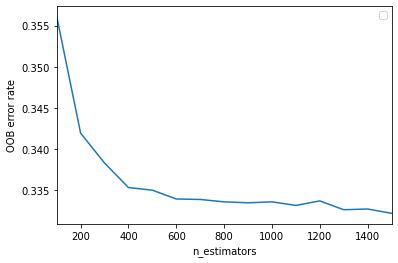

In [68]:
plt.plot(n_estimators, error_rate)
plt.xlim(100, 1500)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
#plt.savefig('oob_err.pdf', bbox_incehs='tight')
plt.show()

No handles with labels found to put in legend.


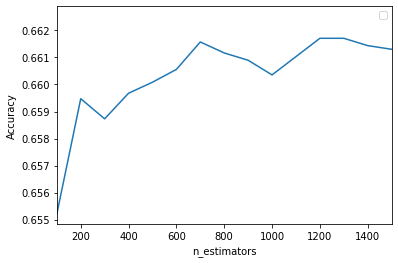

In [69]:
plt.plot(n_estimators, accuracy)
plt.xlim(100, 1500)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
#plt.savefig('oob_err.pdf', bbox_incehs='tight')
plt.show()

No handles with labels found to put in legend.


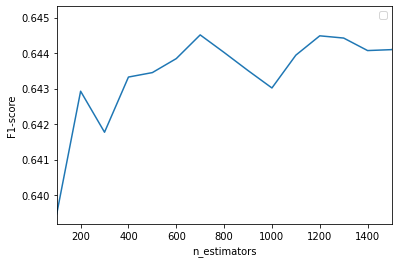

In [70]:
plt.plot(n_estimators, f1)
plt.xlim(100, 1500)
plt.xlabel("n_estimators")
plt.ylabel("F1-score")
plt.legend(loc="upper right")
#plt.savefig('oob_err.pdf', bbox_incehs='tight')
plt.show()

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = {#'min_samples_split': [2,5,10,20,30,50,100],
              #'min_samples_leaf': [1,2,5,10,20,30,50],
              #'max_features': ['auto','log2'],
              #'max_depth': [None] + [5, 10, 20, 30]
              'n_estimators' : [100, 200, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400]
}

clf =  RandomForestClassifier(criterion='gini', 
                             max_depth=None, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=0,
                             class_weight = 'balanced')

grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=10, scoring='accuracy', cv=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=24,
             param_grid={'max_depth': [None], 'min_samples_leaf': [1],
                         'min_samples_split': [20],
                         'n_estimators': range(1300, 1501, 50)},
             scoring='accuracy', verbose=10)

# Bagging

In [42]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=30, min_samples_leaf=1, random_state=0,
                                                              min_samples_split=10, class_weight = 'balanced'),
                        n_estimators=500,
                        random_state=0, max_samples=1.0, verbose=3, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

In [43]:
clf = BaggingClassifier(base_estimator=GaussianNB(),
                        n_estimators=500,
                        random_state=0, max_samples=1.0, verbose=3, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.9min remaining:  8.8min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  3.0min remaining:  1.8min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.0min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  3.1min remaining:  9.2min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  3.1min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.1min finished


Accuracy 0.34519380369343167
F1-score [0.33463035 0.43745428 0.10636704 0.66294537 0.10385572 0.05367913
 0.37400531 0.30342523 0.08020699 0.16309013]
              precision    recall  f1-score   support

           0       0.41      0.28      0.33       611
           1       0.30      0.82      0.44       364
           2       0.11      0.10      0.11       697
           3       0.67      0.66      0.66      4247
           4       0.38      0.06      0.10      2778
           5       0.58      0.03      0.05      3163
           6       0.30      0.51      0.37       832
           7       0.18      0.86      0.30      1061
           8       0.20      0.05      0.08       621
           9       0.10      0.37      0.16       409

    accuracy                           0.35     14783
   macro avg       0.32      0.37      0.26     14783
weighted avg       0.46      0.35      0.30     14783



# Boosting

In [24]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
clf = AdaBoostClassifier(base_estimator=None, n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))